<a id='home'></a>
### purpose

Using a type II ANOVA, answer Q1: How do different evolutionary scenarios affect performance?

### notes

scatter plots showing relationships between degree of local adaptation and performance are in `02_analysis/02_main_questions/02_Q1_performance_vs_local-adaptation_figures.ipynb`

### outline

1. [load data](#data)

    - best case scenario data sets (all loci, all selective envs are known: ntraits=2).

1. [Estimate ANOVAs](#anova)

   1. [see the formulas used](#formulas)
   1. [output from super simple IBE ANOVA](#ss_ibe)
       - score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
   
   1. [output from super simple ANOVA](#ss_anova)
       - score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
   1. [output from simple ANOVA](#simp_anova)
       - score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)
   1. [output from combined architecture ANOVA](#comb_anova)
       - score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
   1. [output from sanity check ANOVA](#sanity_anova)
       - sanity check looked for confounding between architecture (defined by 'combined' formula) and local adaptation. Because slevel was included in architecture, there is confounding between architecture and LA. The super simple model excludes slevel - [compare with simple formula results](#ss_anova_sos)
1. [look at figures for percent sum of squares of factors across methods](#sos)

   1. [super simple ANOVA](#ss_anova_sos)
   1. [simple ANOVA](#simp_anova_sos)
   1. [combined architecture ANOVA](#comb_anova_sos)
   1. [sanity check ANOVA](#sanity_anova_sos)
   
1. [visualize rank of sum of squares](#vis)

1. [make figs](#figs)
    1. [performance by program by landscape](#landscape)
    1. [performance by program by genic level](#genic)
    1. [performance by program by demography](#demo)

### Notes

- cor_TPR_\<env> = percentage of causal markers that were clinal

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf

import MVP_summary_functions as mvp

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
# from scipy.stats import levene  # brown-forsythe test of equal variance
plt.rcParams.update({'font.family' : 'serif'})

t1 = dt.now()  # notebook timer

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1'
figdir = makedir(op.join(summarydir, 'figs'))
pkldir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/all_performance_dicts'

mvp.latest_commit()
session_info.show()

#########################################################
Today:	January 11, 2024 - 12:39:54 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit c5bc403582e5bafc1036be8cd2a4bb0b4d154623  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Dec 18 14:38:19 2023 -0500
#########################################################



<a id='data'></a>
# 1. load data

[top](#home)

In [2]:
# get bcs data
bcs = mvp.combine_level_dicts(use_bcs_data=True,
#                               repdirs = ['/work/lotterhos/MVP-Offsets/run_20220919_0-225']
                             )

# how many validation scores per seed (= num gardens)
for program, df in bcs.items():
    # create 'architecture' factor by combining glevel + plevel + pleio + slevel
    df.loc[df['slevel'].isnull(), 'slevel'] = 'NA'  # str.cat will skip anything with np.nan (i.e., isnull()) - 1-trait sims
    df['architecture'] = df['glevel'].str.cat(df[['plevel', 'pleio', 'slevel']], sep='_').str.replace(' ', '-')
    
    print(program, df.index.value_counts().unique())
    
# show preview of last dataframe
df.head()

filtering criteria:
	use_bcs_data = True
	performance = garden_performance
	num_traits = 2
	ntraits = None
	marker_set = all
	remove_structcrxn = False
	keep_nuisance = False
	remove_rda_outliers = True


reading reps: 100%|███████████████| 10/10 [00:21<00:00,  2.18s/it]


0-225
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


225-450
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


450-675
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


675-900
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


900-1125
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1125-1350
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1350-1575
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1575-1800
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1800-2025
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


2025-2250
	 RONA num seeds =  180
	 lfmm2 num seeds =  18

garden     score            glevel   plevel          pleio   slevel  \
1231109       1 -0.677172  highly-polygenic  2-trait  no pleiotropy  equal-S   
1231109       2 -0.727548  highly-polygenic  2-trait  no pleiotropy  equal-S   
1231109       3 -0.779798  highly-polygenic  2-trait  no pleiotropy  equal-S   
1231109       4 -0.835152  highly-polygenic  2-trait  no pleiotropy  equal-S   
1231109       5 -0.898252  highly-polygenic  2-trait  no pleiotropy  equal-S   

          landscape                 popsize   migration marker_set     seed  \
1231109  Est-Clines  N-cline-center-to-edge  m-constant        all  1231109   
1231109  Est-Clines  N-cline-center-to-edge  m-constant        all  1231109   
1231109  Est-Clines  N-cline-center-to-edge  m-constant        all  1231109   
1231109  Est-Clines  N-cline-center-to-edge  m-constant        all  1231109   
1231109  Est-Clines  N-cline-center-to-edge  m-constant        all  1231109   

                                          simulation_level    ntraits  \
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  ntraits-2   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  ntraits-2   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  ntraits-2   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  ntraits-2   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  ntraits-2   

        structcrxn   noncausal_env  \
1231109     nocorr  2-trait 2-envs   
1231109     nocorr  2-trait 2-envs   
1231109     nocorr  2-trait 2-envs   
1231109     nocorr  2-trait 2-envs   
1231109     nocorr  2-trait 2-envs   

                                              offset_level     program    rep  \
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  rda-nocorr  0-225   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  rda-nocorr  0-225   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  rda-nocorr  0-225   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  rda-nocorr  0-225   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  rda-nocorr  0-225   

                                         simulation_garden  final_LA  \
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  0.501332   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  0.501332   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  0.501332   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  0.501332   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  0.501332   

         cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
1231109      0.495283     0.013652               0.490294   
1231109      0.495283     0.013652               0.490294   
1231109      0.495283     0.013652               0.490294   
1231109      0.495283     0.013652               0.490294   
1231109      0.495283     0.013652               0.490294   

         cor_FPR_sal_neutSNPs           plevel_pleio  \
1231109                   0.0  2-trait_no pleiotropy   
1231109                   0.0  2-trait_no pleiotropy   
1231109                   0.0  2-trait_no pleiotropy   
1231109                   0.0  2-trait_no pleiotropy   
1231109                   0.0  2-trait_no pleiotropy   

                                demography  \
1231109  N-cline-center-to-edge_m-constant   
1231109  N-cline-center-to-edge_m-constant   
1231109  N-cline-center-to-edge_m-constant   
1231109  N-cline-center-to-edge_m-constant   
1231109  N-cline-center-to-edge_m-constant   

                                           architecture  
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S  
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S  
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S  
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S  
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S

In [3]:
# coombine programs into one dataframe
bcs_garden_data = mvp.combine_program_data(bcs)

bcs_garden_data.shape

(1080000, 28)

In [4]:
programs = bcs_garden_data.program.unique().tolist()

programs

['RONA-sal_opt',
 'RONA-temp_opt',
 'lfmm2',
 'GF',
 'rda-nocorr',
 'rda-structcorr']

In [5]:
# load IBE data created in 02_analysis/02_main_questions/10_ibe_vs_performance.ipynb
ibe = pd.read_table('/home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/ibe_corrs.txt', index_col=0)

# reduce to only 2-trait sims, and IBE from 'all' markers
ibe = ibe.loc['all', bcs_garden_data.index.unique()]

print(ibe.shape)

# add ibe to garden data
bcs_garden_data['ibe'] = bcs_garden_data.index.map(ibe)

bcs_garden_data

(1800,)


garden     score            glevel   plevel          pleio  \
1231109       1 -0.315152  highly-polygenic  2-trait  no pleiotropy   
1231109       2 -0.235152  highly-polygenic  2-trait  no pleiotropy   
1231109       3 -0.160000  highly-polygenic  2-trait  no pleiotropy   
1231109       4 -0.098586  highly-polygenic  2-trait  no pleiotropy   
1231109       5 -0.086869  highly-polygenic  2-trait  no pleiotropy   
...         ...       ...               ...      ...            ...   
1233343      96 -0.792984        oligogenic  2-trait     pleiotropy   
1233343      97 -0.727080        oligogenic  2-trait     pleiotropy   
1233343      98 -0.457888        oligogenic  2-trait     pleiotropy   
1233343      99 -0.466233        oligogenic  2-trait     pleiotropy   
1233343     100 -0.667487        oligogenic  2-trait     pleiotropy   

            slevel   landscape                 popsize   migration marker_set  \
1231109    equal-S  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231109    equal-S  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231109    equal-S  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231109    equal-S  Est-Clines  N-cline-center-to-edge  m-constant        all   
1231109    equal-S  Est-Clines  N-cline-center-to-edge  m-constant        all   
...            ...         ...                     ...         ...        ...   
1233343  unequal-S      SS-Mtn              N-variable  m-variable        all   
1233343  unequal-S      SS-Mtn              N-variable  m-variable        all   
1233343  unequal-S      SS-Mtn              N-variable  m-variable        all   
1233343  unequal-S      SS-Mtn              N-variable  m-variable        all   
1233343  unequal-S      SS-Mtn              N-variable  m-variable        all   

            seed                                   simulation_level      env  \
1231109  1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  sal_opt   
1231109  1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  sal_opt   
1231109  1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  sal_opt   
1231109  1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  sal_opt   
1231109  1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...  sal_opt   
...          ...                                                ...      ...   
1233343  1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...      NaN   
1233343  1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...      NaN   
1233343  1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...      NaN   
1233343  1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...      NaN   
1233343  1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...      NaN   

                                              offset_level         program  \
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...    RONA-sal_opt   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...    RONA-sal_opt   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...    RONA-sal_opt   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...    RONA-sal_opt   
1231109  highly-polygenic_2-trait_no-pleiotropy_equal-S...    RONA-sal_opt   
...                                                    ...             ...   
1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   
1233343  oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...  rda-structcorr   

               rep                                  simulation_garden  \
1231109      0-225  highly-polygenic_2-trait_no-pleiotropy_equal-S...   
1231109      0-225  highly-polygenic_2-trait_no-pleiotropy_equal-S...   
1231109      0-225  highly-polygenic_2-trait_no-pleiotropy_equal-S

<a id='anova'></a>
# 2. ANOVAs

[top](#home)

<a id='formulas'></a>
### formulas

[top](#home)

In [6]:
# FORMULA BUILDING
formulas = {
    # same as 'simple' but without `slevel`
    'super_simple' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
                     '+ cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)',
    
    # same as 'super_simple' but without `garden_ID`
    'super_simple_evo' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
                         '+ cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA',
    
    # same as 'super_simple' but with `slevel`
    'simple' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
               '+ slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)',
    
    # same as 'simple' but without `garden_ID`
    'simple_evo' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
               '+ slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA',    
    
    # combining factors from 'simple*' models into fewer factors
    'combined' : 'score ~ architecture + landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)',
    
    # with local adaptation without architecture
    'withLA_woArch' : 'score ~ landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)',
    
    # with architecture without local adaptation
    'woLA_withArch' : 'score ~ architecture + landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)',
}

# add IBE formula
formulas.update({
    # same as 'super_simple' but with IBE
    'super_simple_ibe' : formulas['super_simple'] + ' + ibe'
}
)




interactions = ' + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel'

# add interactions to formulas
for formula_key in keys(formulas):
    formula = formulas[formula_key]
    formulas[f'{formula_key}_interactions'] = formula + interactions


# set up blank dictionaries to fill in later
lms = {}  # linear models
res = {}  # anova output
sos = {}  # rank of factors

### functions

In [7]:
def print_summary_table(lm):
    """Do lm.summary2().__repr__() but just display the first table in lm.summary2().tables.
    
    summary - return from lm.summary2()
    """
    from statsmodels.iolib.summary2 import _simple_tables, _measure_tables

    summary = lm.summary2()
    
    tables = [summary.tables[0]]
    settings = [summary.settings[0]]
    pad_col, pad_index, widest = _measure_tables(tables, settings)
    rule_equal = widest * '='

    simple_tables = _simple_tables(tables, settings, pad_col, pad_index)
    tab = [x.as_text() for x in simple_tables]

    tab = '\n'.join(tab)
    tab = tab.split('\n')
    tab[0] = rule_equal
    tab.append(rule_equal)
    tab = '\n'.join(tab)
    
    print(tab)
    
    pass


def get_anova(formula_key, typ=None):
    """Estimate ANOVA using evolutionary parameters as factors.
    
    Parameters
    ----------
    formula_key : str
        used to index formulas just above
    typ : int
        the Type of ANOVA - 1, 2, or 3
    
    Notes
    -----
    - displays statistical info from ANOVA and qqplot
    - C(factor) treats a numerical entry as a category (gardens are integer IDs)
    """
    # determine formula
    formula = formulas[formula_key]
    
    # determine Type of ANOVA
    if typ is None:
        typ = 3 if 'interaction' in formula_key else 2
    
    # get anovas
    lms = {}
    res = {}
    sos = []
    for program in bcs_garden_data.program.unique():
        _df = bcs_garden_data[bcs_garden_data.program == program].copy()

        print(f'\n{ColorText(formula_key).bold()} {ColorText(formula).blue()}')
        print(f'{ColorText(program).green().bold()}')

        # perform type 2 anova
        lms[program] = ols(formula, data=_df).fit()
        res[program] = anova_lm(lms[program], typ=typ)
        
        # get percentages for sum of squares
        res[program]['perc_sum_sq'] = (
            (
                (res[program]['sum_sq'] / res[program]['sum_sq'].sum()) * 100
            ).round(2)
        )
        if round(abs(res[program]['perc_sum_sq'].sum() - 100), 2) > 0.03:  # account for compounding error rounding percs
            raise Exception('bad percentage', abs(res[program]['perc_sum_sq'].sum() - 100))

#         res[program].index = res[program].index.map(mvp.factor_names)

        # brown-forsythe test?
        # TODO?

        # show more info
        display(res[program])
        print_summary_table(lms[program])

        sm.qqplot(lms[program].resid, line="45")
        plt.show()

        # get sum of squares
        sos.append(
            pd.Series(
                res[program]['sum_sq'].tolist(),
                name=program,
                index=res[program]['sum_sq'].index#.map(mvp.factor_names)
            )
        )
        
    return lms, res, sos

<a id='ss_ibe'></a>
### super simple ibe (excludes slevel)

[top](#home)


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
glevel                   15.464882       2.0   206.277352   3.291973e-90   
landscape                18.139958       2.0   241.958686  1.147537e-105   
demography              155.908087       4.0  1039.785092   0.000000e+00   
plevel_pleio              0.008719       1.0     0.232586   6.296136e-01   
C(garden)              1941.690095      99.0   523.214361   0.000000e+00   
cor_TPR_temp              0.544703       1.0    14.530969   1.379202e-04   
cor_TPR_sal               3.765889       1.0   100.462137   1.224201e-23   
cor_FPR_temp_neutSNPs     1.315210       1.0    35.085704   3.160792e-09   
cor_FPR_sal_neutSNPs     22.945569       1.0   612.116039  6.529547e-135   
final_LA                 90.700385       1.0  2419.602725   0.000000e+00   
ibe                      28.889401       1.0   770.678905  2.921059e-169   
Residual               6743.106447  179885.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.17  
landscape                     0.20  
demography                    1.73  
plevel_pleio                  0.00  
C(garden)                    21.52  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.04  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.25  
final_LA                      1.01  
ibe                           0.32  
Residual                     74.74

Model:              OLS              Adj. R-squared:     0.404      
Dependent Variable: score            AIC:                -80150.6323
Date:               2024-01-11 12:40 BIC:                -78989.0504
No. Observations:   180000           Log-Likelihood:     40190.     
Df Model:           114              F-statistic:        1073.      
Df Residuals:       179885           Prob (F-statistic): 0.00       
R-squared:          0.405            Scale:              0.037486   


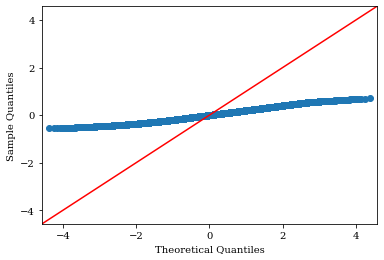


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
RONA-temp_opt


sum_sq        df              F         PR(>F)  \
glevel                    3.419296       2.0     104.902638   2.937047e-46   
landscape                69.993801       2.0    2147.382088   0.000000e+00   
demography                5.345311       4.0      81.996018   1.149979e-69   
plevel_pleio              1.628300       1.0      99.911188   1.616568e-23   
C(garden)              4962.472456      99.0    3075.690685   0.000000e+00   
cor_TPR_temp              0.913273       1.0      56.037733   7.141533e-14   
cor_TPR_sal               0.017106       1.0       1.049595   3.056017e-01   
cor_FPR_temp_neutSNPs     0.064654       1.0       3.967149   4.639778e-02   
cor_FPR_sal_neutSNPs      0.555596       1.0      34.090942   5.268548e-09   
final_LA               3645.825707       1.0  223704.976531   0.000000e+00   
ibe                       8.616369       1.0     528.693547  8.020304e-117   
Residual               2931.670843  179885.0            NaN            NaN   

                       perc_sum_sq  
glevel                        0.03  
landscape                     0.60  
demography                    0.05  
plevel_pleio                  0.01  
C(garden)                    42.67  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     31.35  
ibe                           0.07  
Residual                     25.21

Model:              OLS              Adj. R-squared:     0.769       
Dependent Variable: score            AIC:                -230081.3086
Date:               2024-01-11 12:40 BIC:                -228919.7267
No. Observations:   180000           Log-Likelihood:     1.1516e+05  
Df Model:           114              F-statistic:        5265.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.769            Scale:              0.016297    


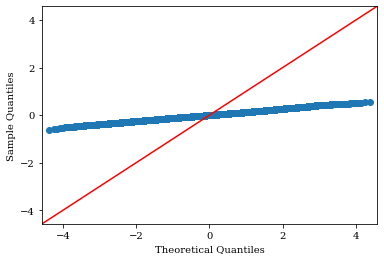


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
lfmm2


sum_sq        df              F        PR(>F)  \
glevel                    0.822149       2.0      33.476838  2.910040e-15   
landscape                39.125231       2.0    1593.129352  0.000000e+00   
demography               53.786573       4.0    1095.060218  0.000000e+00   
plevel_pleio              0.149189       1.0      12.149596  4.911019e-04   
C(garden)               391.270017      99.0     321.858878  0.000000e+00   
cor_TPR_temp              2.934841       1.0     239.005918  7.017740e-54   
cor_TPR_sal               1.369265       1.0     111.509400  4.657476e-26   
cor_FPR_temp_neutSNPs    35.785430       1.0    2914.273856  0.000000e+00   
cor_FPR_sal_neutSNPs      0.968983       1.0      78.911468  6.553530e-19   
final_LA               2401.463548       1.0  195569.045753  0.000000e+00   
ibe                      28.405540       1.0    2313.274502  0.000000e+00   
Residual               2208.873437  179885.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.02  
landscape                     0.76  
demography                    1.04  
plevel_pleio                  0.00  
C(garden)                     7.58  
cor_TPR_temp                  0.06  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.69  
cor_FPR_sal_neutSNPs          0.02  
final_LA                     46.50  
ibe                           0.55  
Residual                     42.77

Model:              OLS              Adj. R-squared:     0.670       
Dependent Variable: score            AIC:                -281037.4881
Date:               2024-01-11 12:40 BIC:                -279875.9062
No. Observations:   180000           Log-Likelihood:     1.4063e+05  
Df Model:           114              F-statistic:        3202.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.670            Scale:              0.012279    


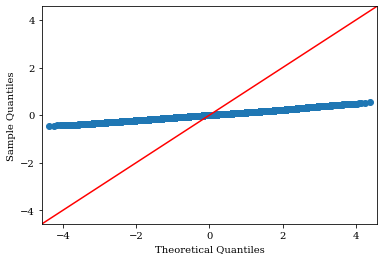


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
GF


sum_sq        df              F        PR(>F)  \
glevel                    3.118638       2.0     159.201494  8.332741e-70   
landscape               224.824776       2.0   11476.947843  0.000000e+00   
demography               74.034922       4.0    1889.682604  0.000000e+00   
plevel_pleio              0.377643       1.0      38.556101  5.331786e-10   
C(garden)               392.397617      99.0     404.672228  0.000000e+00   
cor_TPR_temp              3.288432       1.0     335.738438  6.328992e-75   
cor_TPR_sal               0.496674       1.0      50.708803  1.075365e-12   
cor_FPR_temp_neutSNPs    40.992124       1.0    4185.165638  0.000000e+00   
cor_FPR_sal_neutSNPs     36.692059       1.0    3746.142716  0.000000e+00   
final_LA               3877.186360       1.0  395848.415241  0.000000e+00   
ibe                       0.040471       1.0       4.131959  4.208209e-02   
Residual               1761.905926  179885.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.05  
landscape                     3.50  
demography                    1.15  
plevel_pleio                  0.01  
C(garden)                     6.12  
cor_TPR_temp                  0.05  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.64  
cor_FPR_sal_neutSNPs          0.57  
final_LA                     60.44  
ibe                           0.00  
Residual                     27.46

Model:              OLS              Adj. R-squared:     0.818       
Dependent Variable: score            AIC:                -321733.0568
Date:               2024-01-11 12:40 BIC:                -320571.4749
No. Observations:   180000           Log-Likelihood:     1.6098e+05  
Df Model:           114              F-statistic:        7080.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.818            Scale:              0.0097946   


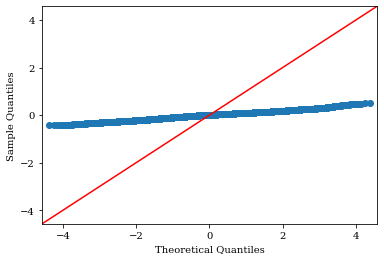


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
rda-nocorr


sum_sq        df              F        PR(>F)  \
glevel                    2.772062       2.0     116.514599  2.698360e-51   
landscape               198.806316       2.0    8356.175841  0.000000e+00   
demography               68.392383       4.0    1437.325518  0.000000e+00   
plevel_pleio              0.057311       1.0       4.817743  2.816947e-02   
C(garden)               384.324179      99.0     326.339694  0.000000e+00   
cor_TPR_temp              4.483788       1.0     376.922878  7.095624e-84   
cor_TPR_sal               1.635319       1.0     137.470610  9.770882e-32   
cor_FPR_temp_neutSNPs    59.278484       1.0    4983.155887  0.000000e+00   
cor_FPR_sal_neutSNPs     42.374239       1.0    3562.126206  0.000000e+00   
final_LA               3718.444388       1.0  312585.392704  0.000000e+00   
ibe                       3.457409       1.0     290.641818  4.055001e-65   
Residual               2139.870846  179885.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.04  
landscape                     3.00  
demography                    1.03  
plevel_pleio                  0.00  
C(garden)                     5.80  
cor_TPR_temp                  0.07  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.89  
cor_FPR_sal_neutSNPs          0.64  
final_LA                     56.14  
ibe                           0.05  
Residual                     32.31

Model:              OLS              Adj. R-squared:     0.796       
Dependent Variable: score            AIC:                -286750.1757
Date:               2024-01-11 12:40 BIC:                -285588.5938
No. Observations:   180000           Log-Likelihood:     1.4349e+05  
Df Model:           114              F-statistic:        6149.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.796            Scale:              0.011896    


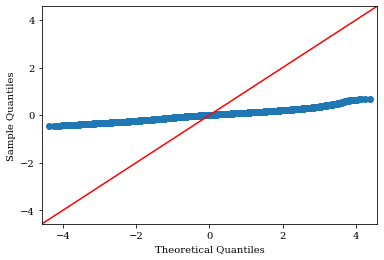


super_simple_ibe score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + ibe
rda-structcorr


sum_sq        df            F         PR(>F)  \
glevel                   19.047215       2.0   302.859204  4.907615e-132   
landscape                19.974187       2.0   317.598473  2.049701e-138   
demography              680.176948       4.0  5407.558140   0.000000e+00   
plevel_pleio              2.413900       1.0    76.764184   1.942646e-18   
C(garden)               184.307173      99.0    59.203356   0.000000e+00   
cor_TPR_temp             12.762050       1.0   405.844551   3.701910e-90   
cor_TPR_sal               0.000857       1.0     0.027257   8.688671e-01   
cor_FPR_temp_neutSNPs    14.671374       1.0   466.562743  2.429227e-103   
cor_FPR_sal_neutSNPs     62.652047       1.0  1992.390867   0.000000e+00   
final_LA                 88.847656       1.0  2825.434559   0.000000e+00   
ibe                      47.143660       1.0  1499.210353   0.000000e+00   
Residual               5656.602627  179885.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.28  
landscape                     0.29  
demography                   10.02  
plevel_pleio                  0.04  
C(garden)                     2.71  
cor_TPR_temp                  0.19  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.22  
cor_FPR_sal_neutSNPs          0.92  
final_LA                      1.31  
ibe                           0.69  
Residual                     83.33

Model:              OLS              Adj. R-squared:     0.392       
Dependent Variable: score            AIC:                -111776.1367
Date:               2024-01-11 12:40 BIC:                -110614.5548
No. Observations:   180000           Log-Likelihood:     56003.      
Df Model:           114              F-statistic:        1018.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.392            Scale:              0.031446    


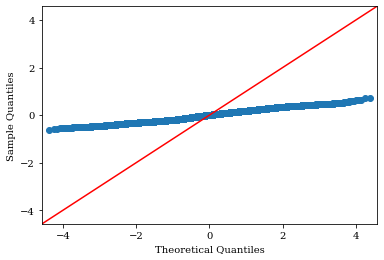

In [8]:
formula_key = 'super_simple_ibe'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='ss_anova'></a>
### super simple (excludes slevel)
[top](#home)


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
glevel                   15.864775       2.0   210.709735  3.953193e-92   
landscape               149.664742       2.0  1987.788561  0.000000e+00   
demography              433.301763       4.0  2877.472267  0.000000e+00   
plevel_pleio              0.033619       1.0     0.893039  3.446564e-01   
C(garden)              1941.690095      99.0   520.985219  0.000000e+00   
cor_TPR_temp              0.724989       1.0    19.258049  1.142528e-05   
cor_TPR_sal               3.874653       1.0   102.923263  3.536502e-24   
cor_FPR_temp_neutSNPs     0.897974       1.0    23.853067  1.040651e-06   
cor_FPR_sal_neutSNPs     14.829886       1.0   393.929492  1.433616e-87   
final_LA                 87.744615       1.0  2330.779320  0.000000e+00   
Residual               6771.995848  179886.0          NaN           NaN   

                       perc_sum_sq  
glevel                        0.17  
landscape                     1.59  
demography                    4.60  
plevel_pleio                  0.00  
C(garden)                    20.61  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.04  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.93  
Residual                     71.88

Model:              OLS              Adj. R-squared:     0.402      
Dependent Variable: score            AIC:                -79383.1080
Date:               2024-01-11 12:40 BIC:                -78231.6268
No. Observations:   180000           Log-Likelihood:     39806.     
Df Model:           113              F-statistic:        1071.      
Df Residuals:       179886           Prob (F-statistic): 0.00       
R-squared:          0.402            Scale:              0.037646   


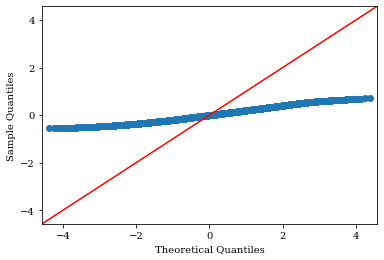


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-temp_opt


sum_sq        df              F        PR(>F)  \
glevel                    3.264399       2.0      99.857527  4.534018e-44   
landscape                74.659979       2.0    2283.838967  0.000000e+00   
demography               26.679201       4.0     408.056627  0.000000e+00   
plevel_pleio              1.505757       1.0      92.121798  8.249029e-22   
C(garden)              4962.472456      99.0    3066.694571  0.000000e+00   
cor_TPR_temp              1.035753       1.0      63.367084  1.725510e-15   
cor_TPR_sal               0.021308       1.0       1.303608  2.535568e-01   
cor_FPR_temp_neutSNPs     2.155381       1.0     131.865626  1.640714e-30   
cor_FPR_sal_neutSNPs      0.039487       1.0       2.415797  1.201186e-01   
final_LA               3659.697867       1.0  223899.355101  0.000000e+00   
Residual               2940.287212  179886.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.03  
landscape                     0.64  
demography                    0.23  
plevel_pleio                  0.01  
C(garden)                    42.52  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.02  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     31.35  
Residual                     25.19

Model:              OLS              Adj. R-squared:     0.769       
Dependent Variable: score            AIC:                -229555.0530
Date:               2024-01-11 12:40 BIC:                -228403.5718
No. Observations:   180000           Log-Likelihood:     1.1489e+05  
Df Model:           113              F-statistic:        5291.       
Df Residuals:       179886           Prob (F-statistic): 0.00        
R-squared:          0.769            Scale:              0.016345    


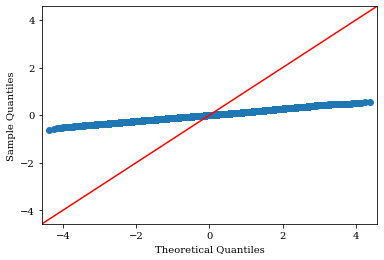


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
lfmm2


sum_sq        df              F         PR(>F)  \
glevel                    0.648503       2.0      26.071108   4.776417e-12   
landscape                69.824926       2.0    2807.098902   0.000000e+00   
demography               75.595816       4.0    1519.549983   0.000000e+00   
plevel_pleio              0.088264       1.0       7.096738   7.723125e-03   
C(garden)               391.270017      99.0     317.774174   0.000000e+00   
cor_TPR_temp              3.333636       1.0     268.037430   3.359626e-60   
cor_TPR_sal               1.434571       1.0     115.345148   6.738112e-27   
cor_FPR_temp_neutSNPs    18.408493       1.0    1480.114981  1.679823e-322   
cor_FPR_sal_neutSNPs      0.000221       1.0       0.017772   8.939475e-01   
final_LA               2419.263042       1.0  194518.232194   0.000000e+00   
Residual               2237.278977  179886.0            NaN            NaN   

                       perc_sum_sq  
glevel                        0.01  
landscape                     1.34  
demography                    1.45  
plevel_pleio                  0.00  
C(garden)                     7.50  
cor_TPR_temp                  0.06  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.35  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     46.37  
Residual                     42.88

Model:              OLS              Adj. R-squared:     0.665       
Dependent Variable: score            AIC:                -278739.4919
Date:               2024-01-11 12:40 BIC:                -277588.0107
No. Observations:   180000           Log-Likelihood:     1.3948e+05  
Df Model:           113              F-statistic:        3169.       
Df Residuals:       179886           Prob (F-statistic): 0.00        
R-squared:          0.666            Scale:              0.012437    


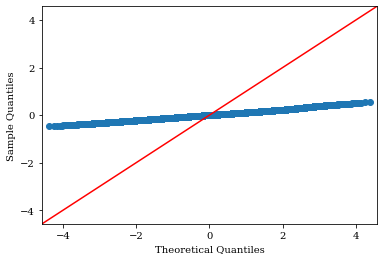


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
GF


sum_sq        df              F        PR(>F)  \
glevel                    3.109424       2.0     158.728388  1.336264e-69   
landscape               344.465503       2.0   17584.110829  0.000000e+00   
demography              104.816048       4.0    2675.299841  0.000000e+00   
plevel_pleio              0.373620       1.0      38.144788  6.582481e-10   
C(garden)               392.397617      99.0     404.665183  0.000000e+00   
cor_TPR_temp              3.305288       1.0     337.453511  2.682308e-75   
cor_TPR_sal               0.498155       1.0      50.859112  9.961078e-13   
cor_FPR_temp_neutSNPs    46.646231       1.0    4762.349106  0.000000e+00   
cor_FPR_sal_neutSNPs     37.556091       1.0    3834.290889  0.000000e+00   
final_LA               3881.402690       1.0  396271.989655  0.000000e+00   
Residual               1761.946397  179886.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.05  
landscape                     5.24  
demography                    1.59  
plevel_pleio                  0.01  
C(garden)                     5.97  
cor_TPR_temp                  0.05  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.71  
cor_FPR_sal_neutSNPs          0.57  
final_LA                     59.02  
Residual                     26.79

Model:              OLS              Adj. R-squared:     0.818       
Dependent Variable: score            AIC:                -321730.9223
Date:               2024-01-11 12:41 BIC:                -320579.4411
No. Observations:   180000           Log-Likelihood:     1.6098e+05  
Df Model:           113              F-statistic:        7143.       
Df Residuals:       179886           Prob (F-statistic): 0.00        
R-squared:          0.818            Scale:              0.0097948   


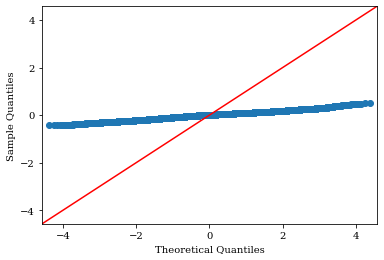


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-nocorr


sum_sq        df              F        PR(>F)  \
glevel                    2.722620       2.0     114.252516  2.583753e-50   
landscape               351.685552       2.0   14758.193717  0.000000e+00   
demography               86.983434       4.0    1825.093984  0.000000e+00   
plevel_pleio              0.043391       1.0       3.641764  5.634878e-02   
C(garden)               384.324179      99.0     325.815086  0.000000e+00   
cor_TPR_temp              4.653284       1.0     390.542466  7.801493e-87   
cor_TPR_sal               1.660051       1.0     139.325332  3.842628e-32   
cor_FPR_temp_neutSNPs    57.083425       1.0    4790.917538  0.000000e+00   
cor_FPR_sal_neutSNPs     39.340402       1.0    3301.774980  0.000000e+00   
final_LA               3728.556367       1.0  312931.576881  0.000000e+00   
Residual               2143.328255  179886.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.04  
landscape                     5.17  
demography                    1.28  
plevel_pleio                  0.00  
C(garden)                     5.65  
cor_TPR_temp                  0.07  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.84  
cor_FPR_sal_neutSNPs          0.58  
final_LA                     54.83  
Residual                     31.52

Model:              OLS              Adj. R-squared:     0.795       
Dependent Variable: score            AIC:                -286461.5828
Date:               2024-01-11 12:41 BIC:                -285310.1016
No. Observations:   180000           Log-Likelihood:     1.4334e+05  
Df Model:           113              F-statistic:        6191.       
Df Residuals:       179886           Prob (F-statistic): 0.00        
R-squared:          0.795            Scale:              0.011915    


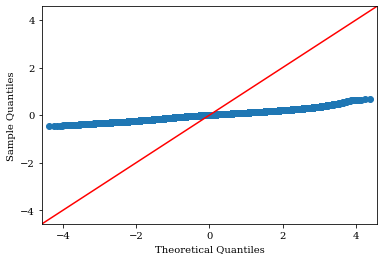


super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-structcorr


sum_sq        df            F         PR(>F)  \
glevel                   19.270968       2.0   303.886012  1.763727e-132   
landscape                54.926356       2.0   866.139726   0.000000e+00   
demography              644.354351       4.0  5080.447174   0.000000e+00   
plevel_pleio              2.784965       1.0    87.832851   7.201110e-21   
C(garden)               184.307173      99.0    58.714343   0.000000e+00   
cor_TPR_temp             13.822608       1.0   435.940440   1.078989e-96   
cor_TPR_sal               0.004197       1.0     0.132380   7.159771e-01   
cor_FPR_temp_neutSNPs     1.803296       1.0    56.872745   4.671127e-14   
cor_FPR_sal_neutSNPs     45.534733       1.0  1436.084373  5.262511e-313   
final_LA                 85.096985       1.0  2683.807346   0.000000e+00   
Residual               5703.746286  179886.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.29  
landscape                     0.81  
demography                    9.54  
plevel_pleio                  0.04  
C(garden)                     2.73  
cor_TPR_temp                  0.20  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.03  
cor_FPR_sal_neutSNPs          0.67  
final_LA                      1.26  
Residual                     84.43

Model:              OLS              Adj. R-squared:     0.387       
Dependent Variable: score            AIC:                -110284.1848
Date:               2024-01-11 12:41 BIC:                -109132.7036
No. Observations:   180000           Log-Likelihood:     55256.      
Df Model:           113              F-statistic:        1006.       
Df Residuals:       179886           Prob (F-statistic): 0.00        
R-squared:          0.387            Scale:              0.031708    


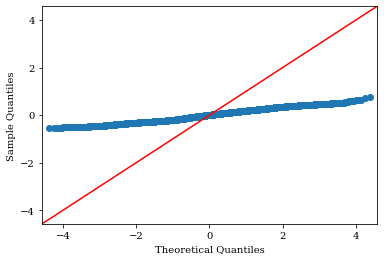

In [9]:
formula_key = 'super_simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 0.867746       1.0    27.203208   1.833568e-07   
glevel                    3.545690       2.0    55.577407   7.421604e-25   
landscape               155.274878       2.0  2433.877768   0.000000e+00   
demography              284.456054       4.0  2229.373069   0.000000e+00   
plevel_pleio              0.549595       1.0    17.229393   3.314235e-05   
C(garden)               901.165763      99.0   285.362598   0.000000e+00   
cor_TPR_temp              0.001866       1.0     0.058499   8.088853e-01   
cor_TPR_sal               0.221581       1.0     6.946404   8.399511e-03   
cor_FPR_temp_neutSNPs     0.190998       1.0     5.987659   1.440726e-02   
cor_FPR_sal_neutSNPs      8.800994       1.0   275.904823   6.520624e-62   
final_LA                  0.004743       1.0     0.148684   6.997964e-01   
final_LA:architecture    25.401926      11.0    72.393825  2.743632e-163   
final_LA:landscape       86.730403       2.0  1359.467809   0.000000e+00   
final_LA:C(garden)      911.385509      99.0   288.598777   0.000000e+00   
final_LA:slevel          11.158280       1.0   349.804050   5.546727e-78   
Residual               5734.549689  179774.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.01  
glevel                        0.04  
landscape                     1.91  
demography                    3.50  
plevel_pleio                  0.01  
C(garden)                    11.09  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.11  
final_LA                      0.00  
final_LA:architecture         0.31  
final_LA:landscape            1.07  
final_LA:C(garden)           11.22  
final_LA:slevel               0.14  
Residual                     70.59

Model:              OLS              Adj. R-squared:     0.493       
Dependent Variable: score            AIC:                -109090.7002
Date:               2024-01-11 12:41 BIC:                -106807.9393
No. Observations:   180000           Log-Likelihood:     54771.      
Df Model:           225              F-statistic:        779.5       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.494            Scale:              0.031899    


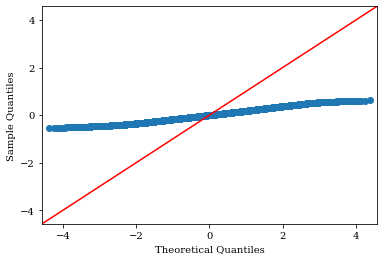


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
Intercept                12.131832       1.0   897.438416  1.082834e-196   
glevel                    1.168440       2.0    43.217008   1.720292e-19   
landscape                14.396828       2.0   532.494463  2.647862e-231   
demography               43.037538       4.0   795.913172   0.000000e+00   
plevel_pleio              0.249996       1.0    18.493172   1.706038e-05   
C(garden)               345.684857      99.0   258.299414   0.000000e+00   
cor_TPR_temp              0.583739       1.0    43.181410   5.002794e-11   
cor_TPR_sal               0.070452       1.0     5.211622   2.243755e-02   
cor_FPR_temp_neutSNPs     5.458132       1.0   403.759046   1.050612e-89   
cor_FPR_sal_neutSNPs      0.033407       1.0     2.471219   1.159498e-01   
final_LA                 32.439053       1.0  2399.641864   0.000000e+00   
final_LA:architecture    29.204403      11.0   196.396576   0.000000e+00   
final_LA:landscape       56.246131       2.0  2080.371625   0.000000e+00   
final_LA:C(garden)      442.780039      99.0   330.849970   0.000000e+00   
final_LA:slevel           6.789024       1.0   502.210276  4.463825e-111   
Residual               2430.236958  179774.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.35  
glevel                        0.03  
landscape                     0.42  
demography                    1.26  
plevel_pleio                  0.01  
C(garden)                    10.11  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.16  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.95  
final_LA:architecture         0.85  
final_LA:landscape            1.64  
final_LA:C(garden)           12.94  
final_LA:slevel               0.20  
Residual                     71.05

Model:              OLS              Adj. R-squared:     0.809       
Dependent Variable: score            AIC:                -263624.3833
Date:               2024-01-11 12:41 BIC:                -261341.6223
No. Observations:   180000           Log-Likelihood:     1.3204e+05  
Df Model:           225              F-statistic:        3381.       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.013518    


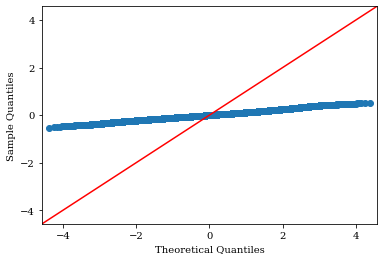


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df             F         PR(>F)  \
Intercept                 3.588132       1.0    347.185914   2.056254e-77   
glevel                    0.224863       2.0     10.878823   1.886571e-05   
landscape               156.057498       2.0   7550.024736   0.000000e+00   
demography               87.527538       4.0   2117.280758   0.000000e+00   
plevel_pleio              0.035373       1.0      3.422628   6.431019e-02   
C(garden)               177.140650      99.0    173.131770   0.000000e+00   
cor_TPR_temp              0.646714       1.0     62.575734   2.578373e-15   
cor_TPR_sal               0.691948       1.0     66.952557   2.799109e-16   
cor_FPR_temp_neutSNPs    11.032100       1.0   1067.460722  1.896528e-233   
cor_FPR_sal_neutSNPs      0.837722       1.0     81.057600   2.212949e-19   
final_LA                 33.685649       1.0   3259.407447   0.000000e+00   
final_LA:architecture    29.172099      11.0    256.607132   0.000000e+00   
final_LA:landscape      214.198175       2.0  10362.856865   0.000000e+00   
final_LA:C(garden)      141.505541      99.0    138.303121   0.000000e+00   
final_LA:slevel          10.228120       1.0    989.668036  1.232064e-216   
Residual               1857.946279  179774.0           NaN            NaN   

                       perc_sum_sq  
Intercept                     0.13  
glevel                        0.01  
landscape                     5.73  
demography                    3.21  
plevel_pleio                  0.00  
C(garden)                     6.50  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.40  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      1.24  
final_LA:architecture         1.07  
final_LA:landscape            7.86  
final_LA:C(garden)            5.19  
final_LA:slevel               0.38  
Residual                     68.19

Model:              OLS              Adj. R-squared:     0.722       
Dependent Variable: score            AIC:                -311957.4504
Date:               2024-01-11 12:41 BIC:                -309674.6895
No. Observations:   180000           Log-Likelihood:     1.5620e+05  
Df Model:           225              F-statistic:        2078.       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.722            Scale:              0.010335    


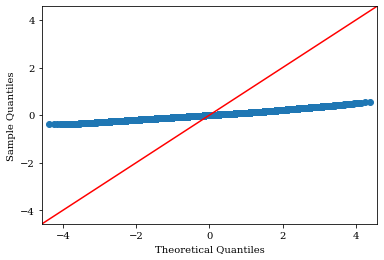


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F         PR(>F)  \
Intercept                 0.096790       1.0    11.150273   8.403640e-04   
glevel                    0.544064       2.0    31.338240   2.468012e-14   
landscape                93.986020       2.0  5413.616678   0.000000e+00   
demography               65.916596       4.0  1898.405667   0.000000e+00   
plevel_pleio              0.211433       1.0    24.357168   8.009979e-07   
C(garden)                61.531391      99.0    71.600454   0.000000e+00   
cor_TPR_temp              2.473919       1.0   284.996639   6.856800e-64   
cor_TPR_sal               0.119711       1.0    13.790763   2.044002e-04   
cor_FPR_temp_neutSNPs    33.797024       1.0  3893.432899   0.000000e+00   
cor_FPR_sal_neutSNPs     32.086688       1.0  3696.401491   0.000000e+00   
final_LA                 28.914684       1.0  3330.985085   0.000000e+00   
final_LA:architecture    34.156336      11.0   357.711439   0.000000e+00   
final_LA:landscape       92.023560       2.0  5300.578558   0.000000e+00   
final_LA:C(garden)       96.450713      99.0   112.234012   0.000000e+00   
final_LA:slevel           8.759963       1.0  1009.151778  7.568001e-221   
Residual               1560.531869  179774.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
glevel                        0.03  
landscape                     4.45  
demography                    3.12  
plevel_pleio                  0.01  
C(garden)                     2.91  
cor_TPR_temp                  0.12  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.60  
cor_FPR_sal_neutSNPs          1.52  
final_LA                      1.37  
final_LA:architecture         1.62  
final_LA:landscape            4.36  
final_LA:C(garden)            4.57  
final_LA:slevel               0.41  
Residual                     73.90

Model:              OLS              Adj. R-squared:     0.838       
Dependent Variable: score            AIC:                -343357.5544
Date:               2024-01-11 12:41 BIC:                -341074.7934
No. Observations:   180000           Log-Likelihood:     1.7190e+05  
Df Model:           225              F-statistic:        4151.       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.839            Scale:              0.0086805   


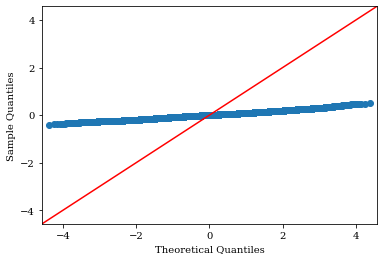


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F         PR(>F)  \
Intercept                 0.023392       1.0     2.232104   1.351714e-01   
glevel                    0.777468       2.0    37.093198   7.833426e-17   
landscape               164.751960       2.0  7860.354662   0.000000e+00   
demography               63.706115       4.0  1519.716840   0.000000e+00   
plevel_pleio              0.168935       1.0    16.119856   5.948148e-05   
C(garden)                66.573056      99.0    64.165982   0.000000e+00   
cor_TPR_temp              3.747719       1.0   357.609148   1.116230e-79   
cor_TPR_sal               0.391156       1.0    37.324264   1.002365e-09   
cor_FPR_temp_neutSNPs    43.425905       1.0  4143.720200   0.000000e+00   
cor_FPR_sal_neutSNPs     30.511154       1.0  2911.388580   0.000000e+00   
final_LA                 32.274341       1.0  3079.632759   0.000000e+00   
final_LA:architecture    31.199952      11.0   270.646728   0.000000e+00   
final_LA:landscape      142.102190       2.0  6779.728797   0.000000e+00   
final_LA:C(garden)       99.545283      99.0    95.946036   0.000000e+00   
final_LA:slevel           5.777119       1.0   551.255356  1.024986e-121   
Residual               1884.019247  179774.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
glevel                        0.03  
landscape                     6.41  
demography                    2.48  
plevel_pleio                  0.01  
C(garden)                     2.59  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         1.69  
cor_FPR_sal_neutSNPs          1.19  
final_LA                      1.26  
final_LA:architecture         1.21  
final_LA:landscape            5.53  
final_LA:C(garden)            3.87  
final_LA:slevel               0.22  
Residual                     73.34

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -309449.0306
Date:               2024-01-11 12:41 BIC:                -307166.2697
No. Observations:   180000           Log-Likelihood:     1.5495e+05  
Df Model:           225              F-statistic:        3645.       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.820            Scale:              0.010480    


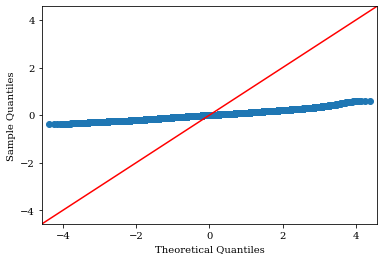


super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept                34.850737       1.0  1132.403387  1.773670e-247   
glevel                   10.442155       2.0   169.648227   2.466899e-74   
landscape                52.337011       2.0   850.292045   0.000000e+00   
demography              605.329838       4.0  4917.238613   0.000000e+00   
plevel_pleio              0.000773       1.0     0.025132   8.740380e-01   
C(garden)                20.501152      99.0     6.728717   1.040819e-84   
cor_TPR_temp              6.641454       1.0   215.800474   7.958107e-49   
cor_TPR_sal               0.225220       1.0     7.318071   6.827108e-03   
cor_FPR_temp_neutSNPs     0.549060       1.0    17.840588   2.403224e-05   
cor_FPR_sal_neutSNPs     49.714288       1.0  1615.364078   0.000000e+00   
final_LA                  1.269946       1.0    41.264292   1.333064e-10   
final_LA:architecture    24.173354      11.0    71.405788  5.772490e-161   
final_LA:landscape       67.915744       2.0  1103.391567   0.000000e+00   
final_LA:C(garden)       12.761812      99.0     4.188576   3.567051e-40   
final_LA:slevel           1.010719       1.0    32.841253   1.001591e-08   
Residual               5532.707221  179774.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.54  
glevel                        0.16  
landscape                     0.82  
demography                    9.43  
plevel_pleio                  0.00  
C(garden)                     0.32  
cor_TPR_temp                  0.10  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.77  
final_LA                      0.02  
final_LA:architecture         0.38  
final_LA:landscape            1.06  
final_LA:C(garden)            0.20  
final_LA:slevel               0.02  
Residual                     86.17

Model:              OLS              Adj. R-squared:     0.405       
Dependent Variable: score            AIC:                -115540.4567
Date:               2024-01-11 12:41 BIC:                -113257.6957
No. Observations:   180000           Log-Likelihood:     57996.      
Df Model:           225              F-statistic:        545.0       
Df Residuals:       179774           Prob (F-statistic): 0.00        
R-squared:          0.406            Scale:              0.030776    


In [10]:
formula_key = 'super_simple_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='simp_evo'></a>
### super simple evo factors (same as 'super_simple' but excludes garden_ID)
[top](#home)


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
glevel                   15.864775       2.0   163.846938  8.070085e-72   
landscape               149.664742       2.0  1545.695401  0.000000e+00   
demography              433.301763       4.0  2237.509430  0.000000e+00   
plevel_pleio              0.033619       1.0     0.694423  4.046651e-01   
cor_TPR_temp              0.724989       1.0    14.974972  1.089850e-04   
cor_TPR_sal               3.874653       1.0    80.032664  3.716434e-19   
cor_FPR_temp_neutSNPs     0.897974       1.0    18.548037  1.657633e-05   
cor_FPR_sal_neutSNPs     14.829886       1.0   306.317792  1.578668e-68   
final_LA                 87.744615       1.0  1812.403465  0.000000e+00   
Residual               8713.685943  179985.0          NaN           NaN   

                       perc_sum_sq  
glevel                        0.17  
landscape                     1.59  
demography                    4.60  
plevel_pleio                  0.00  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.04  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.93  
Residual                     92.50

Model:              OLS              Adj. R-squared:     0.231      
Dependent Variable: score            AIC:                -34203.2816
Date:               2024-01-11 12:41 BIC:                -34051.7710
No. Observations:   180000           Log-Likelihood:     17117.     
Df Model:           14               F-statistic:        3859.      
Df Residuals:       179985           Prob (F-statistic): 0.00       
R-squared:          0.231            Scale:              0.048413   


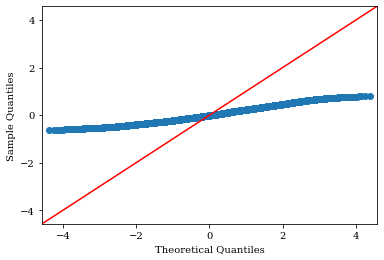


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
RONA-temp_opt


sum_sq        df             F         PR(>F)  \
glevel                    3.264399       2.0     37.173267   7.230837e-17   
landscape                74.659979       2.0    850.188853   0.000000e+00   
demography               26.679201       4.0    151.904403  5.784888e-130   
plevel_pleio              1.505757       1.0     34.293541   4.747715e-09   
cor_TPR_temp              1.035753       1.0     23.589224   1.193534e-06   
cor_TPR_sal               0.021308       1.0      0.485285   4.860390e-01   
cor_FPR_temp_neutSNPs     2.155381       1.0     49.088700   2.454988e-12   
cor_FPR_sal_neutSNPs      0.039487       1.0      0.899312   3.429676e-01   
final_LA               3659.697867       1.0  83349.456178   0.000000e+00   
Residual               7902.759668  179985.0           NaN            NaN   

                       perc_sum_sq  
glevel                        0.03  
landscape                     0.64  
demography                    0.23  
plevel_pleio                  0.01  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.02  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     31.35  
Residual                     67.71

Model:              OLS              Adj. R-squared:     0.378      
Dependent Variable: score            AIC:                -51786.1970
Date:               2024-01-11 12:41 BIC:                -51634.6863
No. Observations:   180000           Log-Likelihood:     25908.     
Df Model:           14               F-statistic:        7825.      
Df Residuals:       179985           Prob (F-statistic): 0.00       
R-squared:          0.378            Scale:              0.043908   


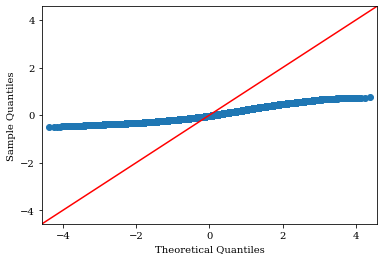


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
lfmm2


sum_sq        df              F         PR(>F)  \
glevel                    0.648503       2.0      22.202532   2.284295e-10   
landscape                69.824926       2.0    2390.565939   0.000000e+00   
demography               75.595816       4.0    1294.070696   0.000000e+00   
plevel_pleio              0.088264       1.0       6.043685   1.395706e-02   
cor_TPR_temp              3.333636       1.0     228.264544   1.532859e-51   
cor_TPR_sal               1.434571       1.0      98.229593   3.777081e-23   
cor_FPR_temp_neutSNPs    18.408493       1.0    1260.487280  3.939991e-275   
cor_FPR_sal_neutSNPs      0.000221       1.0       0.015135   9.020887e-01   
final_LA               2419.263042       1.0  165654.533934   0.000000e+00   
Residual               2628.548995  179985.0            NaN            NaN   

                       perc_sum_sq  
glevel                        0.01  
landscape                     1.34  
demography                    1.45  
plevel_pleio                  0.00  
cor_TPR_temp                  0.06  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.35  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     46.37  
Residual                     50.38

Model:              OLS              Adj. R-squared:     0.607       
Dependent Variable: score            AIC:                -249926.6047
Date:               2024-01-11 12:41 BIC:                -249775.0940
No. Observations:   180000           Log-Likelihood:     1.2498e+05  
Df Model:           14               F-statistic:        1.987e+04   
Df Residuals:       179985           Prob (F-statistic): 0.00        
R-squared:          0.607            Scale:              0.014604    


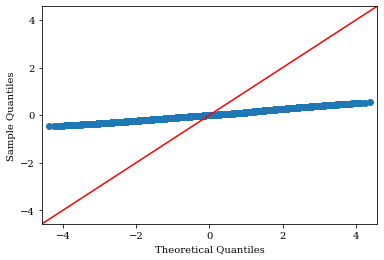


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
GF


sum_sq        df              F        PR(>F)  \
glevel                    3.109424       2.0     129.888647  4.273142e-57   
landscape               344.465503       2.0   14389.211547  0.000000e+00   
demography              104.816048       4.0    2189.218195  0.000000e+00   
plevel_pleio              0.373620       1.0      31.214170  2.314059e-08   
cor_TPR_temp              3.305288       1.0     276.140773  5.792866e-62   
cor_TPR_sal               0.498155       1.0      41.618398  1.112242e-10   
cor_FPR_temp_neutSNPs    46.646231       1.0    3897.066472  0.000000e+00   
cor_FPR_sal_neutSNPs     37.556091       1.0    3137.629379  0.000000e+00   
final_LA               3881.402690       1.0  324272.381164  0.000000e+00   
Residual               2154.344013  179985.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.05  
landscape                     5.24  
demography                    1.59  
plevel_pleio                  0.01  
cor_TPR_temp                  0.05  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.71  
cor_FPR_sal_neutSNPs          0.57  
final_LA                     59.02  
Residual                     32.76

Model:              OLS              Adj. R-squared:     0.777       
Dependent Variable: score            AIC:                -285736.8317
Date:               2024-01-11 12:41 BIC:                -285585.3210
No. Observations:   180000           Log-Likelihood:     1.4288e+05  
Df Model:           14               F-statistic:        4.483e+04   
Df Residuals:       179985           Prob (F-statistic): 0.00        
R-squared:          0.777            Scale:              0.011970    


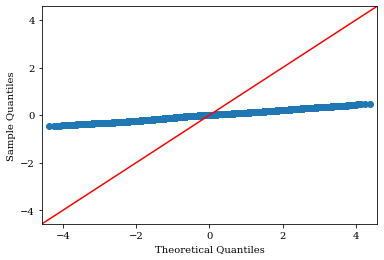


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
rda-nocorr


sum_sq        df              F        PR(>F)  \
glevel                    2.722620       2.0      96.933982  8.409355e-43   
landscape               351.685552       2.0   12521.128931  0.000000e+00   
demography               86.983434       4.0    1548.444039  0.000000e+00   
plevel_pleio              0.043391       1.0       3.089741  7.878903e-02   
cor_TPR_temp              4.653284       1.0     331.343568  5.710897e-74   
cor_TPR_sal               1.660051       1.0     118.206230  1.593789e-27   
cor_FPR_temp_neutSNPs    57.083425       1.0    4064.704485  0.000000e+00   
cor_FPR_sal_neutSNPs     39.340402       1.0    2801.287950  0.000000e+00   
final_LA               3728.556367       1.0  265497.031413  0.000000e+00   
Residual               2527.652434  179985.0            NaN           NaN   

                       perc_sum_sq  
glevel                        0.04  
landscape                     5.17  
demography                    1.28  
plevel_pleio                  0.00  
cor_TPR_temp                  0.07  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.84  
cor_FPR_sal_neutSNPs          0.58  
final_LA                     54.83  
Residual                     37.17

Model:              OLS              Adj. R-squared:     0.759       
Dependent Variable: score            AIC:                -256971.9848
Date:               2024-01-11 12:42 BIC:                -256820.4741
No. Observations:   180000           Log-Likelihood:     1.2850e+05  
Df Model:           14               F-statistic:        4.044e+04   
Df Residuals:       179985           Prob (F-statistic): 0.00        
R-squared:          0.759            Scale:              0.014044    


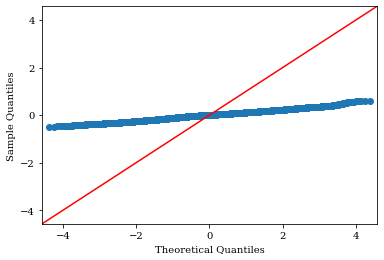


super_simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
rda-structcorr


sum_sq        df            F         PR(>F)  \
glevel                   19.270968       2.0   294.535815  1.966037e-128   
landscape                54.926356       2.0   839.489677   0.000000e+00   
demography              644.354351       4.0  4924.128096   0.000000e+00   
plevel_pleio              2.784965       1.0    85.130343   2.822225e-20   
cor_TPR_temp             13.822608       1.0   422.527091   8.819309e-94   
cor_TPR_sal               0.004197       1.0     0.128307   7.201942e-01   
cor_FPR_temp_neutSNPs     1.803296       1.0    55.122841   1.137235e-13   
cor_FPR_sal_neutSNPs     45.534733       1.0  1391.897832  1.767794e-303   
final_LA                 85.096985       1.0  2601.229912   0.000000e+00   
Residual               5888.053459  179985.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.29  
landscape                     0.81  
demography                    9.54  
plevel_pleio                  0.04  
cor_TPR_temp                  0.20  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.03  
cor_FPR_sal_neutSNPs          0.67  
final_LA                      1.26  
Residual                     87.16

Model:              OLS              Adj. R-squared:     0.367       
Dependent Variable: score            AIC:                -104757.7783
Date:               2024-01-11 12:42 BIC:                -104606.2676
No. Observations:   180000           Log-Likelihood:     52394.      
Df Model:           14               F-statistic:        7464.       
Df Residuals:       179985           Prob (F-statistic): 0.00        
R-squared:          0.367            Scale:              0.032714    


In [11]:
formula_key = 'super_simple_evo'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 0.003290       1.0     0.089188   7.652125e-01   
glevel                    3.545690       2.0    48.056146   1.364755e-21   
landscape               155.274878       2.0  2104.502401   0.000000e+00   
demography              284.456054       4.0  1927.673213   0.000000e+00   
plevel_pleio              0.549595       1.0    14.897749   1.135380e-04   
cor_TPR_temp              0.001866       1.0     0.050582   8.220540e-01   
cor_TPR_sal               0.221581       1.0     6.006351   1.425542e-02   
cor_FPR_temp_neutSNPs     0.190998       1.0     5.177352   2.288434e-02   
cor_FPR_sal_neutSNPs      8.800994       1.0   238.566772   8.746374e-54   
final_LA                  3.211362       1.0    87.049753   1.069711e-20   
final_LA:architecture    25.401926      11.0    62.596808  2.890961e-140   
final_LA:landscape       86.730403       2.0  1175.491763   0.000000e+00   
final_LA:C(garden)     1951.909841      99.0   534.444710   0.000000e+00   
final_LA:slevel          11.158280       1.0   302.465256   1.086942e-67   
Residual               6635.715453  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
glevel                        0.04  
landscape                     1.69  
demography                    3.10  
plevel_pleio                  0.01  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.10  
final_LA                      0.04  
final_LA:architecture         0.28  
final_LA:landscape            0.95  
final_LA:C(garden)           21.29  
final_LA:slevel               0.12  
Residual                     72.39

Model:              OLS              Adj. R-squared:     0.414      
Dependent Variable: score            AIC:                -83016.3926
Date:               2024-01-11 12:42 BIC:                -81733.6022
No. Observations:   180000           Log-Likelihood:     41635.     
Df Model:           126              F-statistic:        1010.      
Df Residuals:       179873           Prob (F-statistic): 0.00       
R-squared:          0.414            Scale:              0.036891   


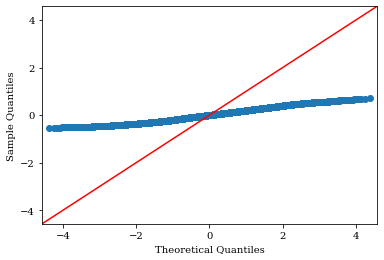


super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
Intercept                 7.324732       1.0   474.624867  4.321974e-105   
glevel                    1.168440       2.0    37.856041   3.654177e-17   
landscape                14.396828       2.0   466.439782  8.938608e-203   
demography               43.037538       4.0   697.182022   0.000000e+00   
plevel_pleio              0.249996       1.0    16.199137   5.704339e-05   
cor_TPR_temp              0.583739       1.0    37.824858   7.755142e-10   
cor_TPR_sal               0.070452       1.0     4.565133   3.263049e-02   
cor_FPR_temp_neutSNPs     5.458132       1.0   353.673690   7.998037e-79   
cor_FPR_sal_neutSNPs      0.033407       1.0     2.164670   1.412167e-01   
final_LA                 41.893189       1.0  2714.577009   0.000000e+00   
final_LA:architecture    29.204403      11.0   172.034044   0.000000e+00   
final_LA:landscape       56.246131       2.0  1822.306437   0.000000e+00   
final_LA:C(garden)     5059.567638      99.0  3311.593029   0.000000e+00   
final_LA:slevel           6.789024       1.0   439.912277   1.481463e-97   
Residual               2775.921815  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.09  
glevel                        0.01  
landscape                     0.18  
demography                    0.54  
plevel_pleio                  0.00  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.07  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.52  
final_LA:architecture         0.36  
final_LA:landscape            0.70  
final_LA:C(garden)           62.91  
final_LA:slevel               0.08  
Residual                     34.52

Model:              OLS              Adj. R-squared:     0.781       
Dependent Variable: score            AIC:                -239883.4433
Date:               2024-01-11 12:42 BIC:                -238600.6528
No. Observations:   180000           Log-Likelihood:     1.2007e+05  
Df Model:           126              F-statistic:        5110.       
Df Residuals:       179873           Prob (F-statistic): 0.00        
R-squared:          0.782            Scale:              0.015433    



super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df            F         PR(>F)  \
Intercept                 0.029567       1.0     2.613287   1.059737e-01   
glevel                    0.224863       2.0     9.937364   4.836111e-05   
landscape               156.057498       2.0  6896.641619   0.000000e+00   
demography               87.527538       4.0  1934.050166   0.000000e+00   
plevel_pleio              0.035373       1.0     3.126432   7.703384e-02   
cor_TPR_temp              0.646714       1.0    57.160397   4.035702e-14   
cor_TPR_sal               0.691948       1.0    61.158447   5.294468e-15   
cor_FPR_temp_neutSNPs    11.032100       1.0   975.082109  1.752263e-213   
cor_FPR_sal_neutSNPs      0.837722       1.0    74.042833   7.704055e-18   
final_LA                 44.265305       1.0  3912.429033   0.000000e+00   
final_LA:architecture    29.172099      11.0   234.400216   0.000000e+00   
final_LA:landscape      214.198175       2.0  9466.049774   0.000000e+00   
final_LA:C(garden)      355.634909      99.0   317.506195   0.000000e+00   
final_LA:slevel          10.228120       1.0   904.021643  4.076739e-198   
Residual               2035.086929  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
glevel                        0.01  
landscape                     5.30  
demography                    2.97  
plevel_pleio                  0.00  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.37  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      1.50  
final_LA:architecture         0.99  
final_LA:landscape            7.27  
final_LA:C(garden)           12.07  
final_LA:slevel               0.35  
Residual                     69.09

Model:              OLS              Adj. R-squared:     0.696       
Dependent Variable: score            AIC:                -295763.4249
Date:               2024-01-11 12:42 BIC:                -294480.6345
No. Observations:   180000           Log-Likelihood:     1.4801e+05  
Df Model:           126              F-statistic:        3266.       
Df Residuals:       179873           Prob (F-statistic): 0.00        
R-squared:          0.696            Scale:              0.011314    



super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F         PR(>F)  \
Intercept                 2.149388       1.0   238.348874   9.756135e-54   
glevel                    0.544064       2.0    30.166057   7.966076e-14   
landscape                93.986020       2.0  5211.124540   0.000000e+00   
demography               65.916596       4.0  1827.397273   0.000000e+00   
plevel_pleio              0.211433       1.0    23.446107   1.285688e-06   
cor_TPR_temp              2.473919       1.0   274.336561   1.430588e-61   
cor_TPR_sal               0.119711       1.0    13.274930   2.690545e-04   
cor_FPR_temp_neutSNPs    33.797024       1.0  3747.802058   0.000000e+00   
cor_FPR_sal_neutSNPs     32.086688       1.0  3558.140457   0.000000e+00   
final_LA                 63.641372       1.0  7057.286068   0.000000e+00   
final_LA:architecture    34.156336      11.0   344.331520   0.000000e+00   
final_LA:landscape       92.023560       2.0  5102.314523   0.000000e+00   
final_LA:C(garden)      427.316939      99.0   478.644535   0.000000e+00   
final_LA:slevel           8.759963       1.0   971.405237  1.092796e-212   
Residual               1622.063260  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.09  
glevel                        0.02  
landscape                     3.79  
demography                    2.66  
plevel_pleio                  0.01  
cor_TPR_temp                  0.10  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         1.36  
cor_FPR_sal_neutSNPs          1.29  
final_LA                      2.57  
final_LA:architecture         1.38  
final_LA:landscape            3.71  
final_LA:C(garden)           17.24  
final_LA:slevel               0.35  
Residual                     65.43

Model:              OLS              Adj. R-squared:     0.832       
Dependent Variable: score            AIC:                -336594.5491
Date:               2024-01-11 12:42 BIC:                -335311.7587
No. Observations:   180000           Log-Likelihood:     1.6842e+05  
Df Model:           126              F-statistic:        7081.       
Df Residuals:       179873           Prob (F-statistic): 0.00        
R-squared:          0.832            Scale:              0.0090178   


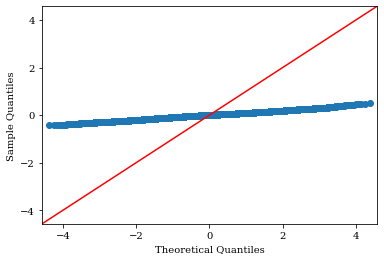


super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F         PR(>F)  \
Intercept                 0.755497       1.0    69.667838   7.066967e-17   
glevel                    0.777468       2.0    35.846949   2.722510e-16   
landscape               164.751960       2.0  7596.264309   0.000000e+00   
demography               63.706115       4.0  1468.657750   0.000000e+00   
plevel_pleio              0.168935       1.0    15.578265   7.918940e-05   
cor_TPR_temp              3.747719       1.0   345.594280   4.560174e-77   
cor_TPR_sal               0.391156       1.0    36.070253   1.906936e-09   
cor_FPR_temp_neutSNPs    43.425905       1.0  4004.500460   0.000000e+00   
cor_FPR_sal_neutSNPs     30.511154       1.0  2813.572430   0.000000e+00   
final_LA                 69.429646       1.0  6402.423836   0.000000e+00   
final_LA:architecture    31.199952      11.0   261.553602   0.000000e+00   
final_LA:landscape      142.102190       2.0  6551.945059   0.000000e+00   
final_LA:C(garden)      417.296406      99.0   388.694971   0.000000e+00   
final_LA:slevel           5.777119       1.0   532.734408  1.065809e-117   
Residual               1950.592303  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.03  
glevel                        0.03  
landscape                     5.63  
demography                    2.18  
plevel_pleio                  0.01  
cor_TPR_temp                  0.13  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.48  
cor_FPR_sal_neutSNPs          1.04  
final_LA                      2.37  
final_LA:architecture         1.07  
final_LA:landscape            4.86  
final_LA:C(garden)           14.27  
final_LA:slevel               0.20  
Residual                     66.70

Model:              OLS              Adj. R-squared:     0.814       
Dependent Variable: score            AIC:                -303396.4083
Date:               2024-01-11 12:42 BIC:                -302113.6179
No. Observations:   180000           Log-Likelihood:     1.5183e+05  
Df Model:           126              F-statistic:        6241.       
Df Residuals:       179873           Prob (F-statistic): 0.00        
R-squared:          0.814            Scale:              0.010844    


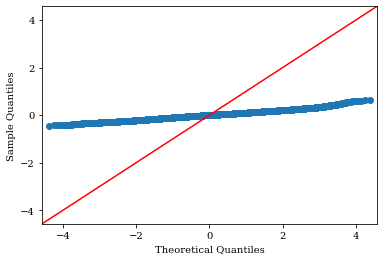


super_simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept                78.260444       1.0  2534.920330   0.000000e+00   
glevel                   10.442155       2.0   169.115004   4.200041e-74   
landscape                52.337011       2.0   847.619484   0.000000e+00   
demography              605.329838       4.0  4901.783197   0.000000e+00   
plevel_pleio              0.000773       1.0     0.025053   8.742344e-01   
cor_TPR_temp              6.641454       1.0   215.122189   1.118361e-48   
cor_TPR_sal               0.225220       1.0     7.295070   6.915057e-03   
cor_FPR_temp_neutSNPs     0.549060       1.0    17.784513   2.475095e-05   
cor_FPR_sal_neutSNPs     49.714288       1.0  1610.286813   0.000000e+00   
final_LA                  1.632867       1.0    52.889917   3.542016e-13   
final_LA:architecture    24.173354      11.0    71.181352  1.944552e-160   
final_LA:landscape       67.915744       2.0  1099.923487   0.000000e+00   
final_LA:C(garden)      176.567833      99.0    57.769472   0.000000e+00   
final_LA:slevel           1.010719       1.0    32.738030   1.056204e-08   
Residual               5553.208373  179873.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     1.18  
glevel                        0.16  
landscape                     0.79  
demography                    9.13  
plevel_pleio                  0.00  
cor_TPR_temp                  0.10  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.75  
final_LA                      0.02  
final_LA:architecture         0.36  
final_LA:landscape            1.02  
final_LA:C(garden)            2.66  
final_LA:slevel               0.02  
Residual                     83.78

Model:              OLS              Adj. R-squared:     0.403       
Dependent Variable: score            AIC:                -115072.7089
Date:               2024-01-11 12:42 BIC:                -113789.9185
No. Observations:   180000           Log-Likelihood:     57663.      
Df Model:           126              F-statistic:        964.9       
Df Residuals:       179873           Prob (F-statistic): 0.00        
R-squared:          0.403            Scale:              0.030873    


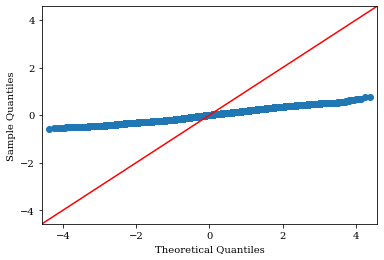

In [12]:
formula_key = 'super_simple_evo_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='simp_anova'></a>
### simple factors (includes slevel)
[top](#home)


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
glevel                    4.616944       2.0    61.445568  2.106881e-27   
landscape               119.219845       2.0  1586.662467  0.000000e+00   
demography              332.851689       4.0  2214.913475  0.000000e+00   
plevel_pleio              0.328588       1.0     8.746159  3.102952e-03   
slevel                   13.828228       1.0   368.071779  5.944736e-82   
C(garden)              1941.690095      99.0   522.048331  0.000000e+00   
cor_TPR_temp              0.407068       1.0    10.835107  9.961272e-04   
cor_TPR_sal               2.192265       1.0    58.352449  2.201984e-14   
cor_FPR_temp_neutSNPs     0.387899       1.0    10.324863  1.312731e-03   
cor_FPR_sal_neutSNPs     14.574025       1.0   387.922981  2.892109e-86   
final_LA                  4.417093       1.0   117.571631  2.194300e-27   
Residual               6758.167620  179885.0          NaN           NaN   

                       perc_sum_sq  
glevel                        0.05  
landscape                     1.30  
demography                    3.62  
plevel_pleio                  0.00  
slevel                        0.15  
C(garden)                    21.12  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.05  
Residual                     73.52

Model:              OLS              Adj. R-squared:     0.403      
Dependent Variable: score            AIC:                -79749.0388
Date:               2024-01-11 12:42 BIC:                -78587.4569
No. Observations:   180000           Log-Likelihood:     39990.     
Df Model:           114              F-statistic:        1067.      
Df Residuals:       179885           Prob (F-statistic): 0.00       
R-squared:          0.403            Scale:              0.037569   


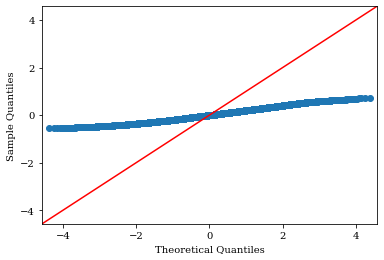


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-temp_opt


sum_sq        df            F        PR(>F)  \
glevel                    0.349429       2.0    10.712305  2.228344e-05   
landscape                43.213875       2.0  1324.790549  0.000000e+00   
demography               32.144928       4.0   492.727122  0.000000e+00   
plevel_pleio              0.474572       1.0    29.097513  6.891181e-08   
slevel                    6.416695       1.0   393.428102  1.842238e-87   
C(garden)              4962.472456      99.0  3073.384681  0.000000e+00   
cor_TPR_temp              1.346799       1.0    82.576569  1.026460e-19   
cor_TPR_sal               0.217370       1.0    13.327648  2.615954e-04   
cor_FPR_temp_neutSNPs     2.827347       1.0   173.353681  1.429108e-39   
cor_FPR_sal_neutSNPs      0.048986       1.0     3.003509  8.308608e-02   
final_LA                 57.875947       1.0  3548.559731  0.000000e+00   
Residual               2933.870517  179885.0          NaN           NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                     0.54  
demography                    0.40  
plevel_pleio                  0.01  
slevel                        0.08  
C(garden)                    61.71  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.04  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.72  
Residual                     36.49

Model:              OLS              Adj. R-squared:     0.769       
Dependent Variable: score            AIC:                -229946.3027
Date:               2024-01-11 12:42 BIC:                -228784.7209
No. Observations:   180000           Log-Likelihood:     1.1509e+05  
Df Model:           114              F-statistic:        5260.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.769            Scale:              0.016310    


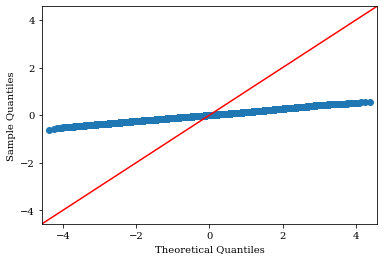


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
lfmm2


sum_sq        df            F         PR(>F)  \
glevel                    0.103142       2.0     4.156437   1.566478e-02   
landscape                55.872644       2.0  2251.571101   0.000000e+00   
demography               79.354415       4.0  1598.922986   0.000000e+00   
plevel_pleio              0.031582       1.0     2.545411   1.106169e-01   
slevel                    5.359565       1.0   431.962443   7.883635e-96   
C(garden)               391.270017      99.0   318.535482   0.000000e+00   
cor_TPR_temp              3.821528       1.0   308.001961   6.792854e-69   
cor_TPR_sal               2.195798       1.0   176.973723   2.319070e-40   
cor_FPR_temp_neutSNPs    16.601300       1.0  1338.007479  7.423153e-292   
cor_FPR_sal_neutSNPs      0.000034       1.0     0.002720   9.584051e-01   
final_LA                 35.206185       1.0  2837.497006   0.000000e+00   
Residual               2231.919412  179885.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                     1.98  
demography                    2.81  
plevel_pleio                  0.00  
slevel                        0.19  
C(garden)                    13.87  
cor_TPR_temp                  0.14  
cor_TPR_sal                   0.08  
cor_FPR_temp_neutSNPs         0.59  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      1.25  
Residual                     79.10

Model:              OLS              Adj. R-squared:     0.666       
Dependent Variable: score            AIC:                -279169.2123
Date:               2024-01-11 12:42 BIC:                -278007.6304
No. Observations:   180000           Log-Likelihood:     1.3970e+05  
Df Model:           114              F-statistic:        3153.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.666            Scale:              0.012407    


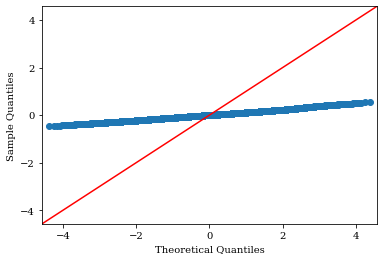


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
GF


sum_sq        df             F         PR(>F)  \
glevel                    0.012646       2.0      0.650283   5.218991e-01   
landscape               290.536767       2.0  14940.243176   0.000000e+00   
demography               72.704216       4.0   1869.330824   0.000000e+00   
plevel_pleio              0.016305       1.0      1.676874   1.953421e-01   
slevel                   12.871575       1.0   1323.787391  8.670877e-289   
C(garden)               392.397617      99.0    407.640879   0.000000e+00   
cor_TPR_temp              4.079100       1.0    419.518351   3.970538e-93   
cor_TPR_sal               1.334839       1.0    137.282549   1.074069e-31   
cor_FPR_temp_neutSNPs    42.176256       1.0   4337.650788   0.000000e+00   
cor_FPR_sal_neutSNPs     37.946832       1.0   3902.672335   0.000000e+00   
final_LA                 47.189316       1.0   4853.223009   0.000000e+00   
Residual               1749.074822  179885.0           NaN            NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                    10.96  
demography                    2.74  
plevel_pleio                  0.00  
slevel                        0.49  
C(garden)                    14.81  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.05  
cor_FPR_temp_neutSNPs         1.59  
cor_FPR_sal_neutSNPs          1.43  
final_LA                      1.78  
Residual                     65.99

Model:              OLS              Adj. R-squared:     0.819       
Dependent Variable: score            AIC:                -323048.7057
Date:               2024-01-11 12:42 BIC:                -321887.1238
No. Observations:   180000           Log-Likelihood:     1.6164e+05  
Df Model:           114              F-statistic:        7144.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.819            Scale:              0.0097233   


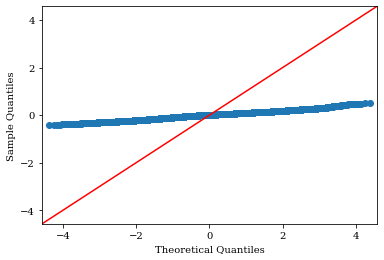


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-nocorr


sum_sq        df             F         PR(>F)  \
glevel                    0.226225       2.0      9.536480   7.220692e-05   
landscape               306.626941       2.0  12925.804927   0.000000e+00   
demography               65.918686       4.0   1389.395315   0.000000e+00   
plevel_pleio              0.182042       1.0     15.347899   8.945334e-05   
slevel                    9.705334       1.0    818.253299  1.470278e-179   
C(garden)               384.324179      99.0    327.295320   0.000000e+00   
cor_TPR_temp              5.434922       1.0    458.216394  1.574348e-101   
cor_TPR_sal               2.800040       1.0    236.070348   3.058197e-53   
cor_FPR_temp_neutSNPs    52.678167       1.0   4441.277789   0.000000e+00   
cor_FPR_sal_neutSNPs     39.687051       1.0   3346.001319   0.000000e+00   
final_LA                 50.811355       1.0   4283.887543   0.000000e+00   
Residual               2133.622921  179885.0           NaN            NaN   

                       perc_sum_sq  
glevel                        0.01  
landscape                    10.05  
demography                    2.16  
plevel_pleio                  0.01  
slevel                        0.32  
C(garden)                    12.59  
cor_TPR_temp                  0.18  
cor_TPR_sal                   0.09  
cor_FPR_temp_neutSNPs         1.73  
cor_FPR_sal_neutSNPs          1.30  
final_LA                      1.66  
Residual                     69.91

Model:              OLS              Adj. R-squared:     0.796       
Dependent Variable: score            AIC:                -287276.5026
Date:               2024-01-11 12:43 BIC:                -286114.9207
No. Observations:   180000           Log-Likelihood:     1.4375e+05  
Df Model:           114              F-statistic:        6172.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.796            Scale:              0.011861    


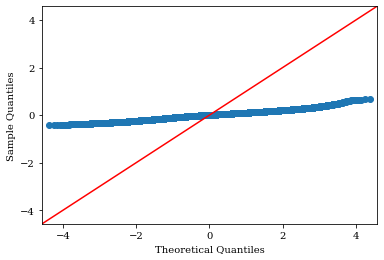


simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-structcorr


sum_sq        df            F         PR(>F)  \
glevel                   45.183955       2.0   719.637611  5.117234e-312   
landscape                26.489685       2.0   421.896968  1.588079e-183   
demography              698.887475       4.0  5565.534464   0.000000e+00   
plevel_pleio              0.012631       1.0     0.402330   5.258894e-01   
slevel                   56.518051       1.0  1800.307888   0.000000e+00   
C(garden)               184.307173      99.0    59.301633   0.000000e+00   
cor_TPR_temp             10.778840       1.0   343.345731   1.405129e-76   
cor_TPR_sal               0.791575       1.0    25.214590   5.134159e-07   
cor_FPR_temp_neutSNPs     3.949453       1.0   125.804620   3.469597e-29   
cor_FPR_sal_neutSNPs     44.629499       1.0  1421.613760  6.932178e-310   
final_LA                 34.472323       1.0  1098.070339  4.617652e-240   
Residual               5647.228236  179885.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.67  
landscape                     0.39  
demography                   10.35  
plevel_pleio                  0.00  
slevel                        0.84  
C(garden)                     2.73  
cor_TPR_temp                  0.16  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.06  
cor_FPR_sal_neutSNPs          0.66  
final_LA                      0.51  
Residual                     83.62

Model:              OLS              Adj. R-squared:     0.393       
Dependent Variable: score            AIC:                -112074.6887
Date:               2024-01-11 12:43 BIC:                -110913.1068
No. Observations:   180000           Log-Likelihood:     56152.      
Df Model:           114              F-statistic:        1023.       
Df Residuals:       179885           Prob (F-statistic): 0.00        
R-squared:          0.393            Scale:              0.031394    


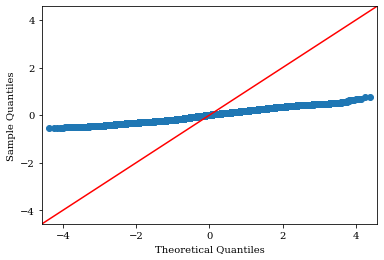

In [13]:
formula_key = 'simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 9.238663       1.0   290.169843   5.136836e-65   
glevel                    5.764251       2.0    90.522405   5.086293e-40   
landscape               135.018574       2.0  2120.345737   0.000000e+00   
demography              292.450519       4.0  2296.336699   0.000000e+00   
plevel_pleio              0.158082       1.0     4.965082   2.586532e-02   
slevel                   10.791155       1.0   338.930836   1.280607e-75   
C(garden)               901.165763      99.0   285.899010   0.000000e+00   
cor_TPR_temp              0.006589       1.0     0.206948   6.491704e-01   
cor_TPR_sal               0.221052       1.0     6.942859   8.416174e-03   
cor_FPR_temp_neutSNPs     0.247984       1.0     7.788728   5.257872e-03   
cor_FPR_sal_neutSNPs      9.433703       1.0   296.295714   2.388620e-66   
final_LA                  5.458768       1.0   171.450125   3.718781e-39   
final_LA:architecture    22.797070      11.0    65.092282  3.976798e-146   
final_LA:landscape       79.377228       2.0  1246.548247   0.000000e+00   
final_LA:C(garden)      911.385509      99.0   289.141271   0.000000e+00   
final_LA:slevel          17.337361       1.0   544.535436  2.938617e-120   
Residual               5723.758535  179773.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.11  
glevel                        0.07  
landscape                     1.66  
demography                    3.60  
plevel_pleio                  0.00  
slevel                        0.13  
C(garden)                    11.09  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.12  
final_LA                      0.07  
final_LA:architecture         0.28  
final_LA:landscape            0.98  
final_LA:C(garden)           11.22  
final_LA:slevel               0.21  
Residual                     70.45

Model:              OLS              Adj. R-squared:     0.494       
Dependent Variable: score            AIC:                -109427.7395
Date:               2024-01-11 12:43 BIC:                -107134.8779
No. Observations:   180000           Log-Likelihood:     54941.      
Df Model:           226              F-statistic:        779.1       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.495            Scale:              0.031839    


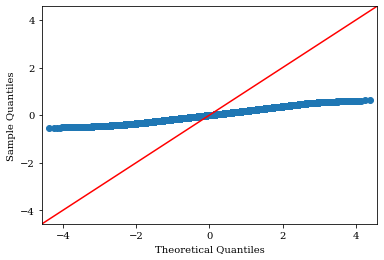


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df           F         PR(>F)  \
Intercept                 2.343910       1.0  173.481459   1.340290e-39   
glevel                    1.527972       2.0   56.545419   2.820704e-25   
landscape                 3.694031       2.0  136.704439   4.732792e-60   
demography               44.020872       4.0  814.536853   0.000000e+00   
plevel_pleio              0.143192       1.0   10.598143   1.132222e-03   
slevel                    1.321616       1.0   97.817688   4.649999e-23   
C(garden)               345.684857      99.0  258.438522   0.000000e+00   
cor_TPR_temp              0.604145       1.0   44.715013   2.285657e-11   
cor_TPR_sal               0.070557       1.0    5.222157   2.230204e-02   
cor_FPR_temp_neutSNPs     5.556470       1.0  411.254852   2.474370e-91   
cor_FPR_sal_neutSNPs      0.048353       1.0    3.578821   5.852227e-02   
final_LA                  9.514744       1.0  704.221342  7.200005e-155   
final_LA:architecture     3.999023      11.0   26.907495   6.893620e-57   
final_LA:landscape        7.716853       2.0  285.576403  1.487117e-124   
final_LA:C(garden)      442.780039      99.0  331.028150   0.000000e+00   
final_LA:slevel           0.077560       1.0    5.740538   1.657873e-02   
Residual               2428.915342  179773.0         NaN            NaN   

                       perc_sum_sq  
Intercept                     0.07  
glevel                        0.05  
landscape                     0.11  
demography                    1.33  
plevel_pleio                  0.00  
slevel                        0.04  
C(garden)                    10.48  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.17  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.29  
final_LA:architecture         0.12  
final_LA:landscape            0.23  
final_LA:C(garden)           13.43  
final_LA:slevel               0.00  
Residual                     73.65

Model:              OLS              Adj. R-squared:     0.809       
Dependent Variable: score            AIC:                -263720.2979
Date:               2024-01-11 12:43 BIC:                -261427.4362
No. Observations:   180000           Log-Likelihood:     1.3209e+05  
Df Model:           226              F-statistic:        3368.       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.013511    


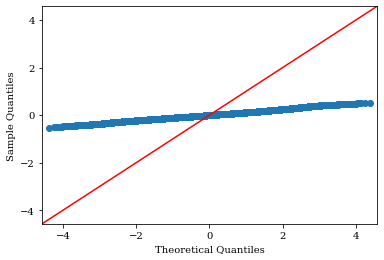


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df            F         PR(>F)  \
Intercept                 0.437352       1.0    42.334531   7.712324e-11   
glevel                    0.101804       2.0     4.927202   7.247727e-03   
landscape               108.039393       2.0  5228.968612   0.000000e+00   
demography               88.049078       4.0  2130.731450   0.000000e+00   
plevel_pleio              0.009644       1.0     0.933468   3.339648e-01   
slevel                    0.738167       1.0    71.452646   2.860721e-17   
C(garden)               177.140650      99.0   173.199619   0.000000e+00   
cor_TPR_temp              0.662701       1.0    64.147748   1.161127e-15   
cor_TPR_sal               0.691704       1.0    66.955133   2.795456e-16   
cor_FPR_temp_neutSNPs    10.922546       1.0  1057.274561  3.012529e-231   
cor_FPR_sal_neutSNPs      0.786732       1.0    76.153642   2.646109e-18   
final_LA                 11.356587       1.0  1099.288610  2.521712e-240   
final_LA:architecture     2.656438      11.0    23.376040   9.733881e-49   
final_LA:landscape       76.520618       2.0  3703.500150   0.000000e+00   
final_LA:C(garden)      141.505541      99.0   138.357322   0.000000e+00   
final_LA:slevel           0.033294       1.0     3.222799   7.262102e-02   
Residual               1857.208113  179773.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.02  
glevel                        0.00  
landscape                     4.36  
demography                    3.55  
plevel_pleio                  0.00  
slevel                        0.03  
C(garden)                     7.15  
cor_TPR_temp                  0.03  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.44  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      0.46  
final_LA:architecture         0.11  
final_LA:landscape            3.09  
final_LA:C(garden)            5.71  
final_LA:slevel               0.00  
Residual                     74.98

Model:              OLS              Adj. R-squared:     0.722       
Dependent Variable: score            AIC:                -312026.9791
Date:               2024-01-11 12:43 BIC:                -309734.1174
No. Observations:   180000           Log-Likelihood:     1.5624e+05  
Df Model:           226              F-statistic:        2070.       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.722            Scale:              0.010331    


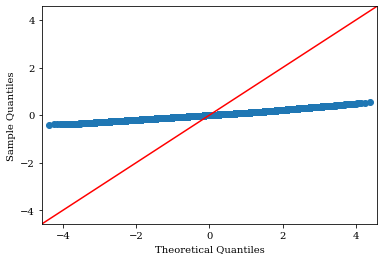


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F         PR(>F)  \
Intercept                 1.058153       1.0   121.996335   2.361787e-28   
glevel                    0.712874       2.0    41.094277   1.435690e-18   
landscape                75.924672       2.0  4376.745058   0.000000e+00   
demography               63.870331       4.0  1840.930937   0.000000e+00   
plevel_pleio              0.116939       1.0    13.482061   2.409249e-04   
slevel                    1.244562       1.0   143.487739   4.733592e-33   
C(garden)                61.531391      99.0    71.657205   0.000000e+00   
cor_TPR_temp              2.514324       1.0   289.880912   5.936762e-65   
cor_TPR_sal               0.119579       1.0    13.786475   2.048671e-04   
cor_FPR_temp_neutSNPs    33.544882       1.0  3867.448968   0.000000e+00   
cor_FPR_sal_neutSNPs     32.463290       1.0  3742.750329   0.000000e+00   
final_LA                  8.353721       1.0   963.115325  6.779529e-211   
final_LA:architecture     5.589087      11.0    58.579619  7.807941e-131   
final_LA:landscape       23.419845       2.0  1350.057730   0.000000e+00   
final_LA:C(garden)       96.450713      99.0   112.322968   0.000000e+00   
final_LA:slevel           0.018386       1.0     2.119701   1.454167e-01   
Residual               1559.287307  179773.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.05  
glevel                        0.04  
landscape                     3.86  
demography                    3.25  
plevel_pleio                  0.01  
slevel                        0.06  
C(garden)                     3.13  
cor_TPR_temp                  0.13  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.71  
cor_FPR_sal_neutSNPs          1.65  
final_LA                      0.42  
final_LA:architecture         0.28  
final_LA:landscape            1.19  
final_LA:C(garden)            4.91  
final_LA:slevel               0.00  
Residual                     79.30

Model:              OLS              Adj. R-squared:     0.839       
Dependent Variable: score            AIC:                -343499.1660
Date:               2024-01-11 12:43 BIC:                -341206.3043
No. Observations:   180000           Log-Likelihood:     1.7198e+05  
Df Model:           226              F-statistic:        4136.       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.839            Scale:              0.0086736   


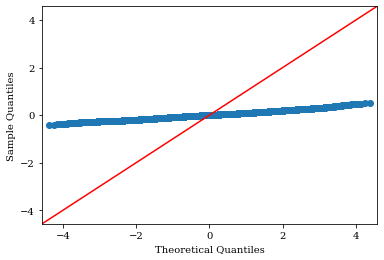


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F         PR(>F)  \
Intercept                 0.337252       1.0    32.195537   1.396240e-08   
glevel                    0.875405       2.0    41.784969   7.198389e-19   
landscape               141.046203       2.0  6732.437590   0.000000e+00   
demography               62.217131       4.0  1484.878511   0.000000e+00   
plevel_pleio              0.097373       1.0     9.295685   2.297276e-03   
slevel                    0.875238       1.0    83.553938   6.262015e-20   
C(garden)                66.573056      99.0    64.195448   0.000000e+00   
cor_TPR_temp              3.789210       1.0   361.734193   1.416865e-80   
cor_TPR_sal               0.390956       1.0    37.322300   1.003375e-09   
cor_FPR_temp_neutSNPs    43.182218       1.0  4122.359677   0.000000e+00   
cor_FPR_sal_neutSNPs     30.814494       1.0  2941.683709   0.000000e+00   
final_LA                 10.432779       1.0   995.957766  5.382387e-218   
final_LA:architecture     9.458026      11.0    82.082156  4.458316e-186   
final_LA:landscape       57.853812       2.0  2761.486433   0.000000e+00   
final_LA:C(garden)       99.545283      99.0    95.990095   0.000000e+00   
final_LA:slevel           0.019102       1.0     1.823527   1.768957e-01   
Residual               1883.144009  179773.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.01  
glevel                        0.04  
landscape                     5.85  
demography                    2.58  
plevel_pleio                  0.00  
slevel                        0.04  
C(garden)                     2.76  
cor_TPR_temp                  0.16  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         1.79  
cor_FPR_sal_neutSNPs          1.28  
final_LA                      0.43  
final_LA:architecture         0.39  
final_LA:landscape            2.40  
final_LA:C(garden)            4.13  
final_LA:slevel               0.00  
Residual                     78.12

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -309530.6706
Date:               2024-01-11 12:43 BIC:                -307237.8090
No. Observations:   180000           Log-Likelihood:     1.5499e+05  
Df Model:           226              F-statistic:        3631.       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.820            Scale:              0.010475    


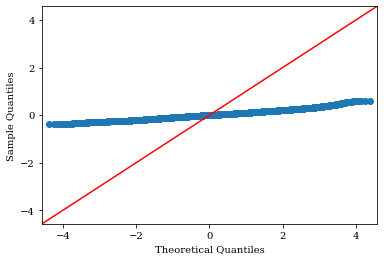


simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept               118.737325       1.0  3920.600288   0.000000e+00   
glevel                   22.634025       2.0   373.677631  1.122701e-162   
landscape               134.364717       2.0  2218.301392   0.000000e+00   
demography              627.987729       4.0  5183.898310   0.000000e+00   
plevel_pleio              0.890536       1.0    29.404713   5.881002e-08   
slevel                   88.192723       1.0  2912.044834   0.000000e+00   
C(garden)                20.501152      99.0     6.837674   1.046407e-86   
cor_TPR_temp              6.092794       1.0   201.178623   1.222648e-45   
cor_TPR_sal               0.223698       1.0     7.386320   6.572810e-03   
cor_FPR_temp_neutSNPs     0.837786       1.0    27.662935   1.445680e-07   
cor_FPR_sal_neutSNPs     45.469844       1.0  1501.373571   0.000000e+00   
final_LA                 57.610003       1.0  1902.230783   0.000000e+00   
final_LA:architecture   104.162621      11.0   312.668780   0.000000e+00   
final_LA:landscape      156.079543       2.0  2576.803475   0.000000e+00   
final_LA:C(garden)       12.761812      99.0     4.256400   2.710853e-41   
final_LA:slevel          85.293151       1.0  2816.303573   0.000000e+00   
Residual               5444.514498  179773.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     1.71  
glevel                        0.33  
landscape                     1.94  
demography                    9.07  
plevel_pleio                  0.01  
slevel                        1.27  
C(garden)                     0.30  
cor_TPR_temp                  0.09  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.66  
final_LA                      0.83  
final_LA:architecture         1.50  
final_LA:landscape            2.25  
final_LA:C(garden)            0.18  
final_LA:slevel               1.23  
Residual                     78.61

Model:              OLS              Adj. R-squared:     0.414       
Dependent Variable: score            AIC:                -118430.8154
Date:               2024-01-11 12:43 BIC:                -116137.9538
No. Observations:   180000           Log-Likelihood:     59442.      
Df Model:           226              F-statistic:        564.3       
Df Residuals:       179773           Prob (F-statistic): 0.00        
R-squared:          0.415            Scale:              0.030285    


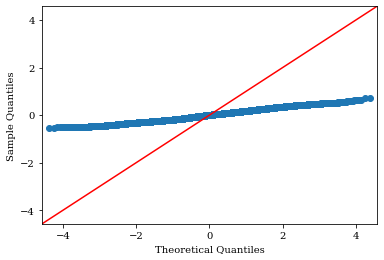

In [14]:
formula_key = 'simple_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='simple_evo'></a>
### simple evo (includes slevel excludes garden_ID)

[top](#home)


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
glevel                    4.616944       2.0    47.758021  1.838470e-21   
landscape               119.219845       2.0  1233.219282  0.000000e+00   
demography              332.851689       4.0  1721.521787  0.000000e+00   
plevel_pleio              0.328588       1.0     6.797874  9.127401e-03   
slevel                   13.828228       1.0   286.080514  3.983446e-64   
cor_TPR_temp              0.407068       1.0     8.421491  3.708566e-03   
cor_TPR_sal               2.192265       1.0    45.353921  1.649495e-11   
cor_FPR_temp_neutSNPs     0.387899       1.0     8.024908  4.614351e-03   
cor_FPR_sal_neutSNPs     14.574025       1.0   301.509685  1.753903e-67   
final_LA                  4.417093       1.0    91.381504  1.198908e-21   
Residual               8699.857715  179984.0          NaN           NaN   

                       perc_sum_sq  
glevel                        0.05  
landscape                     1.30  
demography                    3.62  
plevel_pleio                  0.00  
slevel                        0.15  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.05  
Residual                     94.64

Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -34487.1604
Date:               2024-01-11 12:43 BIC:                -34325.5490
No. Observations:   180000           Log-Likelihood:     17260.     
Df Model:           15               F-statistic:        3627.      
Df Residuals:       179984           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.048337   


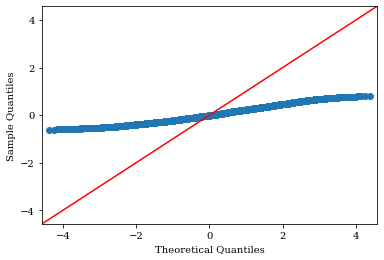


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
glevel                    0.349429       2.0     3.982326   1.864387e-02   
landscape                43.213875       2.0   492.494188  4.961698e-214   
demography               32.144928       4.0   183.172536  6.090264e-157   
plevel_pleio              0.474572       1.0    10.817073   1.005877e-03   
slevel                    6.416695       1.0   146.257877   1.175002e-33   
cor_TPR_temp              1.346799       1.0    30.698045   3.018888e-08   
cor_TPR_sal               0.217370       1.0     4.954586   2.602278e-02   
cor_FPR_temp_neutSNPs     2.827347       1.0    64.444663   9.987391e-16   
cor_FPR_sal_neutSNPs      0.048986       1.0     1.116562   2.906613e-01   
final_LA                 57.875947       1.0  1319.185923  8.514294e-288   
Residual               7896.342974  179984.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                     0.54  
demography                    0.40  
plevel_pleio                  0.01  
slevel                        0.08  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.04  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.72  
Residual                     98.20

Model:              OLS              Adj. R-squared:     0.379      
Dependent Variable: score            AIC:                -51930.4084
Date:               2024-01-11 12:43 BIC:                -51768.7970
No. Observations:   180000           Log-Likelihood:     25981.     
Df Model:           15               F-statistic:        7319.      
Df Residuals:       179984           Prob (F-statistic): 0.00       
R-squared:          0.379            Scale:              0.043872   


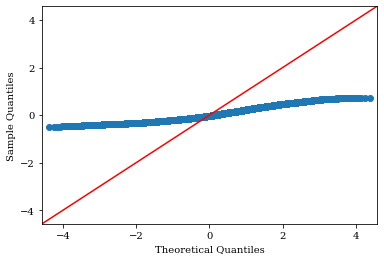


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
lfmm2


sum_sq        df            F         PR(>F)  \
glevel                    0.103142       2.0     3.538417   2.906132e-02   
landscape                55.872644       2.0  1916.785302   0.000000e+00   
demography               79.354415       4.0  1361.179346   0.000000e+00   
plevel_pleio              0.031582       1.0     2.166934   1.410089e-01   
slevel                    5.359565       1.0   367.734007   7.038531e-82   
cor_TPR_temp              3.821528       1.0   262.205191   6.245882e-59   
cor_TPR_sal               2.195798       1.0   150.659525   1.284314e-34   
cor_FPR_temp_neutSNPs    16.601300       1.0  1139.059330  6.463329e-249   
cor_FPR_sal_neutSNPs      0.000034       1.0     0.002316   9.616192e-01   
final_LA                 35.206185       1.0  2415.589965   0.000000e+00   
Residual               2623.189430  179984.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                     1.98  
demography                    2.81  
plevel_pleio                  0.00  
slevel                        0.19  
cor_TPR_temp                  0.14  
cor_TPR_sal                   0.08  
cor_FPR_temp_neutSNPs         0.59  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      1.25  
Residual                     92.96

Model:              OLS              Adj. R-squared:     0.608       
Dependent Variable: score            AIC:                -250291.9962
Date:               2024-01-11 12:43 BIC:                -250130.3848
No. Observations:   180000           Log-Likelihood:     1.2516e+05  
Df Model:           15               F-statistic:        1.861e+04   
Df Residuals:       179984           Prob (F-statistic): 0.00        
R-squared:          0.608            Scale:              0.014575    


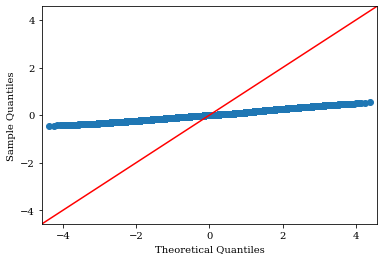


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
GF


sum_sq        df             F         PR(>F)  \
glevel                    0.012646       2.0      0.531419   5.877710e-01   
landscape               290.536767       2.0  12209.349169   0.000000e+00   
demography               72.704216       4.0   1527.639977   0.000000e+00   
plevel_pleio              0.016305       1.0      1.370362   2.417513e-01   
slevel                   12.871575       1.0   1081.815221  1.498800e-236   
cor_TPR_temp              4.079100       1.0    342.835520   1.813751e-76   
cor_TPR_sal               1.334839       1.0    112.188976   3.306543e-26   
cor_FPR_temp_neutSNPs    42.176256       1.0   3544.781194   0.000000e+00   
cor_FPR_sal_neutSNPs     37.946832       1.0   3189.311491   0.000000e+00   
final_LA                 47.189316       1.0   3966.113110   0.000000e+00   
Residual               2141.472439  179984.0           NaN            NaN   

                       perc_sum_sq  
glevel                        0.00  
landscape                    10.96  
demography                    2.74  
plevel_pleio                  0.00  
slevel                        0.49  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.05  
cor_FPR_temp_neutSNPs         1.59  
cor_FPR_sal_neutSNPs          1.43  
final_LA                      1.78  
Residual                     80.80

Model:              OLS              Adj. R-squared:     0.778       
Dependent Variable: score            AIC:                -286813.5046
Date:               2024-01-11 12:43 BIC:                -286651.8932
No. Observations:   180000           Log-Likelihood:     1.4342e+05  
Df Model:           15               F-statistic:        4.217e+04   
Df Residuals:       179984           Prob (F-statistic): 0.00        
R-squared:          0.778            Scale:              0.011898    


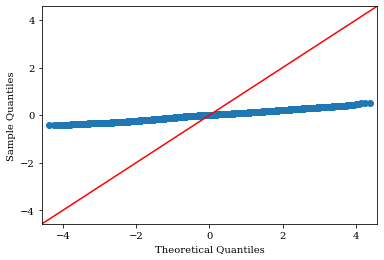


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
rda-nocorr


sum_sq        df             F         PR(>F)  \
glevel                    0.226225       2.0      8.085337   3.081346e-04   
landscape               306.626941       2.0  10958.916372   0.000000e+00   
demography               65.918686       4.0   1177.974381   0.000000e+00   
plevel_pleio              0.182042       1.0     13.012446   3.095112e-04   
slevel                    9.705334       1.0    693.741668  1.339816e-152   
cor_TPR_temp              5.434922       1.0    388.490711   2.176877e-86   
cor_TPR_sal               2.800040       1.0    200.148093   2.050704e-45   
cor_FPR_temp_neutSNPs    52.678167       1.0   3765.459262   0.000000e+00   
cor_FPR_sal_neutSNPs     39.687051       1.0   2836.848370   0.000000e+00   
final_LA                 50.811355       1.0   3632.018709   0.000000e+00   
Residual               2517.947100  179984.0           NaN            NaN   

                       perc_sum_sq  
glevel                        0.01  
landscape                    10.05  
demography                    2.16  
plevel_pleio                  0.01  
slevel                        0.32  
cor_TPR_temp                  0.18  
cor_TPR_sal                   0.09  
cor_FPR_temp_neutSNPs         1.73  
cor_FPR_sal_neutSNPs          1.30  
final_LA                      1.66  
Residual                     82.50

Model:              OLS              Adj. R-squared:     0.760       
Dependent Variable: score            AIC:                -257662.4544
Date:               2024-01-11 12:43 BIC:                -257500.8430
No. Observations:   180000           Log-Likelihood:     1.2885e+05  
Df Model:           15               F-statistic:        3.794e+04   
Df Residuals:       179984           Prob (F-statistic): 0.00        
R-squared:          0.760            Scale:              0.013990    


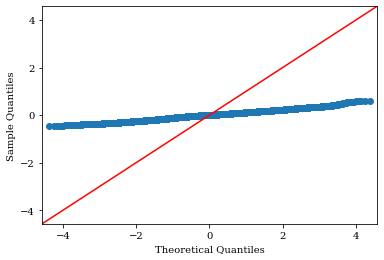


simple_evo score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
rda-structcorr


sum_sq        df            F         PR(>F)  \
glevel                   45.183955       2.0   697.276816  2.206334e-302   
landscape                26.489685       2.0   408.787659  7.375340e-178   
demography              698.887475       4.0  5392.600513   0.000000e+00   
plevel_pleio              0.012631       1.0     0.389828   5.323905e-01   
slevel                   56.518051       1.0  1744.368183   0.000000e+00   
cor_TPR_temp             10.778840       1.0   332.677190   2.929410e-74   
cor_TPR_sal               0.791575       1.0    24.431114   7.708379e-07   
cor_FPR_temp_neutSNPs     3.949453       1.0   121.895581   2.484678e-28   
cor_FPR_sal_neutSNPs     44.629499       1.0  1377.440952  2.317338e-300   
final_LA                 34.472323       1.0  1063.950769  1.085328e-232   
Residual               5831.535409  179984.0          NaN            NaN   

                       perc_sum_sq  
glevel                        0.67  
landscape                     0.39  
demography                   10.35  
plevel_pleio                  0.00  
slevel                        0.84  
cor_TPR_temp                  0.16  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.06  
cor_FPR_sal_neutSNPs          0.66  
final_LA                      0.51  
Residual                     86.35

Model:              OLS              Adj. R-squared:     0.373       
Dependent Variable: score            AIC:                -106491.9020
Date:               2024-01-11 12:44 BIC:                -106330.2906
No. Observations:   180000           Log-Likelihood:     53262.      
Df Model:           15               F-statistic:        7151.       
Df Residuals:       179984           Prob (F-statistic): 0.00        
R-squared:          0.373            Scale:              0.032400    


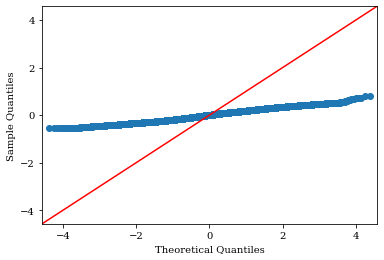

In [15]:
formula_key = 'simple_evo'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 7.886516       1.0   214.125215   1.844221e-48   
glevel                    5.764251       2.0    78.252022   1.072395e-34   
landscape               135.018574       2.0  1832.931198   0.000000e+00   
demography              292.450519       4.0  1985.066446   0.000000e+00   
plevel_pleio              0.158082       1.0     4.292061   3.829214e-02   
slevel                   10.791155       1.0   292.988493   1.251741e-65   
cor_TPR_temp              0.006589       1.0     0.178896   6.723240e-01   
cor_TPR_sal               0.221052       1.0     6.001749   1.429265e-02   
cor_FPR_temp_neutSNPs     0.247984       1.0     6.732960   9.465508e-03   
cor_FPR_sal_neutSNPs      9.433703       1.0   256.132596   1.310425e-57   
final_LA                  3.919193       1.0   106.409233   6.094658e-25   
final_LA:architecture    22.797070      11.0    56.268972  2.061682e-125   
final_LA:landscape       79.377228       2.0  1077.577648   0.000000e+00   
final_LA:C(garden)     1951.909841      99.0   535.312276   0.000000e+00   
final_LA:slevel          17.337361       1.0   470.723228  3.037196e-104   
Residual               6624.924298  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.09  
glevel                        0.06  
landscape                     1.47  
demography                    3.19  
plevel_pleio                  0.00  
slevel                        0.12  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.10  
final_LA                      0.04  
final_LA:architecture         0.25  
final_LA:landscape            0.87  
final_LA:C(garden)           21.30  
final_LA:slevel               0.19  
Residual                     72.31

Model:              OLS              Adj. R-squared:     0.415      
Dependent Variable: score            AIC:                -83307.3511
Date:               2024-01-11 12:44 BIC:                -82014.4599
No. Observations:   180000           Log-Likelihood:     41782.     
Df Model:           127              F-statistic:        1006.      
Df Residuals:       179872           Prob (F-statistic): 0.00       
R-squared:          0.415            Scale:              0.036831   


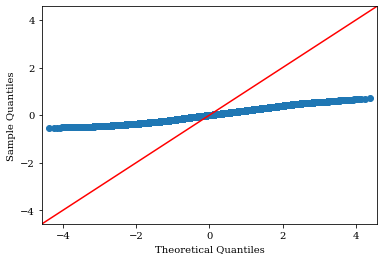


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
Intercept                 0.137791       1.0     8.932721   2.801445e-03   
glevel                    1.527972       2.0    49.527738   3.135432e-22   
landscape                 3.694031       2.0   119.738463   1.078530e-52   
demography               44.020872       4.0   713.447139   0.000000e+00   
plevel_pleio              0.143192       1.0     9.282839   2.313441e-03   
slevel                    1.321616       1.0    85.677829   2.139957e-20   
cor_TPR_temp              0.604145       1.0    39.165568   3.902193e-10   
cor_TPR_sal               0.070557       1.0     4.574051   3.246107e-02   
cor_FPR_temp_neutSNPs     5.556470       1.0   360.215252   3.029460e-80   
cor_FPR_sal_neutSNPs      0.048353       1.0     3.134664   7.664585e-02   
final_LA                  4.755601       1.0   308.296483   5.861450e-69   
final_LA:architecture     3.999023      11.0    23.568087   3.515902e-49   
final_LA:landscape        7.716853       2.0   250.134376  3.302230e-109   
final_LA:C(garden)     5059.567638      99.0  3313.152010   0.000000e+00   
final_LA:slevel           0.077560       1.0     5.028097   2.494050e-02   
Residual               2774.600199  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
glevel                        0.02  
landscape                     0.05  
demography                    0.56  
plevel_pleio                  0.00  
slevel                        0.02  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.07  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.06  
final_LA:architecture         0.05  
final_LA:landscape            0.10  
final_LA:C(garden)           63.98  
final_LA:slevel               0.00  
Residual                     35.09

Model:              OLS              Adj. R-squared:     0.782       
Dependent Variable: score            AIC:                -239967.1616
Date:               2024-01-11 12:44 BIC:                -238674.2705
No. Observations:   180000           Log-Likelihood:     1.2011e+05  
Df Model:           127              F-statistic:        5073.       
Df Residuals:       179872           Prob (F-statistic): 0.00        
R-squared:          0.782            Scale:              0.015425    


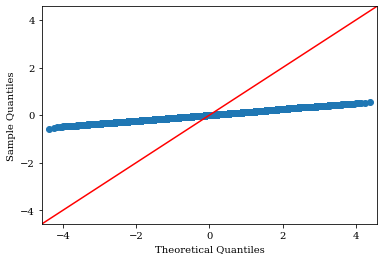


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df            F         PR(>F)  \
Intercept                 0.429528       1.0    37.977807   7.170501e-10   
glevel                    0.101804       2.0     4.500644   1.110310e-02   
landscape               108.039393       2.0  4776.285687   0.000000e+00   
demography               88.049078       4.0  1946.269500   0.000000e+00   
plevel_pleio              0.009644       1.0     0.852655   3.558035e-01   
slevel                    0.738167       1.0    65.266839   6.581305e-16   
cor_TPR_temp              0.662701       1.0    58.594341   1.947311e-14   
cor_TPR_sal               0.691704       1.0    61.158685   5.293831e-15   
cor_FPR_temp_neutSNPs    10.922546       1.0   965.744055  1.830324e-211   
cor_FPR_sal_neutSNPs      0.786732       1.0    69.560859   7.460689e-17   
final_LA                  6.363040       1.0   562.604032  3.544014e-124   
final_LA:architecture     2.656438      11.0    21.352326   4.368081e-44   
final_LA:landscape       76.520618       2.0  3382.880272   0.000000e+00   
final_LA:C(garden)      355.634909      99.0   317.619637   0.000000e+00   
final_LA:slevel           0.033294       1.0     2.943795   8.620971e-02   
Residual               2034.348762  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.02  
glevel                        0.00  
landscape                     4.02  
demography                    3.28  
plevel_pleio                  0.00  
slevel                        0.03  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.41  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      0.24  
final_LA:architecture         0.10  
final_LA:landscape            2.85  
final_LA:C(garden)           13.24  
final_LA:slevel               0.00  
Residual                     75.74

Model:              OLS              Adj. R-squared:     0.696       
Dependent Variable: score            AIC:                -295826.7264
Date:               2024-01-11 12:44 BIC:                -294533.8352
No. Observations:   180000           Log-Likelihood:     1.4804e+05  
Df Model:           127              F-statistic:        3242.       
Df Residuals:       179872           Prob (F-statistic): 0.00        
R-squared:          0.696            Scale:              0.011310    


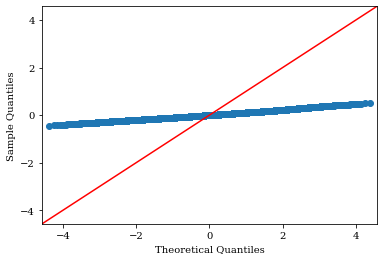


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F         PR(>F)  \
Intercept                 2.898415       1.0   321.654552   7.299129e-72   
glevel                    0.712874       2.0    39.555980   6.680868e-18   
landscape                75.924672       2.0  4212.908757   0.000000e+00   
demography               63.870331       4.0  1772.018695   0.000000e+00   
plevel_pleio              0.116939       1.0    12.977382   3.153615e-04   
slevel                    1.244562       1.0   138.116510   7.059657e-32   
cor_TPR_temp              2.514324       1.0   279.029694   1.362472e-62   
cor_TPR_sal               0.119579       1.0    13.270401   2.697052e-04   
cor_FPR_temp_neutSNPs    33.544882       1.0  3722.677333   0.000000e+00   
cor_FPR_sal_neutSNPs     32.463290       1.0  3602.646585   0.000000e+00   
final_LA                  8.703893       1.0   965.923406  1.673981e-211   
final_LA:architecture     5.589087      11.0    56.386786  1.091025e-125   
final_LA:landscape       23.419845       2.0  1299.520524   0.000000e+00   
final_LA:C(garden)      427.316939      99.0   479.009404   0.000000e+00   
final_LA:slevel           0.018386       1.0     2.040353   1.531758e-01   
Residual               1620.818698  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.13  
glevel                        0.03  
landscape                     3.30  
demography                    2.78  
plevel_pleio                  0.01  
slevel                        0.05  
cor_TPR_temp                  0.11  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.46  
cor_FPR_sal_neutSNPs          1.41  
final_LA                      0.38  
final_LA:architecture         0.24  
final_LA:landscape            1.02  
final_LA:C(garden)           18.58  
final_LA:slevel               0.00  
Residual                     70.49

Model:              OLS              Adj. R-squared:     0.832       
Dependent Variable: score            AIC:                -336730.7109
Date:               2024-01-11 12:44 BIC:                -335437.8197
No. Observations:   180000           Log-Likelihood:     1.6849e+05  
Df Model:           127              F-statistic:        7031.       
Df Residuals:       179872           Prob (F-statistic): 0.00        
R-squared:          0.832            Scale:              0.0090110   


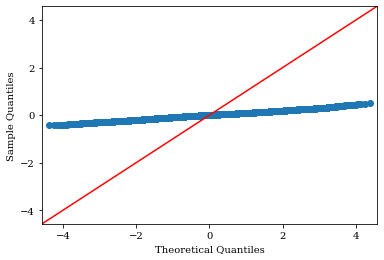


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F         PR(>F)  \
Intercept                 1.552797       1.0   143.253960   5.324233e-33   
glevel                    0.875405       2.0    40.380447   2.930425e-18   
landscape               141.046203       2.0  6506.139547   0.000000e+00   
demography               62.217131       4.0  1434.967153   0.000000e+00   
plevel_pleio              0.097373       1.0     8.983229   2.725060e-03   
slevel                    0.875238       1.0    80.745432   2.591452e-19   
cor_TPR_temp              3.789210       1.0   349.575189   6.219244e-78   
cor_TPR_sal               0.390956       1.0    36.067782   1.909356e-09   
cor_FPR_temp_neutSNPs    43.182218       1.0  3983.794422   0.000000e+00   
cor_FPR_sal_neutSNPs     30.814494       1.0  2842.804624   0.000000e+00   
final_LA                 10.768227       1.0   993.427478  1.895041e-217   
final_LA:architecture     9.458026      11.0    79.323121  1.381930e-179   
final_LA:landscape       57.853812       2.0  2668.664336   0.000000e+00   
final_LA:C(garden)      417.296406      99.0   388.867296   0.000000e+00   
final_LA:slevel           0.019102       1.0     1.762233   1.843480e-01   
Residual               1949.717065  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.06  
glevel                        0.03  
landscape                     5.17  
demography                    2.28  
plevel_pleio                  0.00  
slevel                        0.03  
cor_TPR_temp                  0.14  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.58  
cor_FPR_sal_neutSNPs          1.13  
final_LA                      0.39  
final_LA:architecture         0.35  
final_LA:landscape            2.12  
final_LA:C(garden)           15.29  
final_LA:slevel               0.00  
Residual                     71.42

Model:              OLS              Adj. R-squared:     0.814       
Dependent Variable: score            AIC:                -303475.1931
Date:               2024-01-11 12:44 BIC:                -302182.3019
No. Observations:   180000           Log-Likelihood:     1.5187e+05  
Df Model:           127              F-statistic:        6196.       
Df Residuals:       179872           Prob (F-statistic): 0.00        
R-squared:          0.814            Scale:              0.010839    


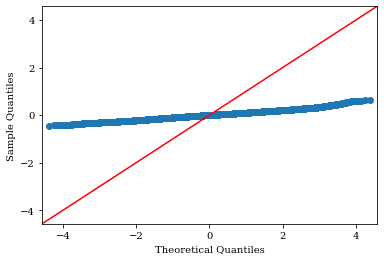


simple_evo_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept               158.001115       1.0  5200.346769   0.000000e+00   
glevel                   22.634025       2.0   372.480848  3.695630e-162   
landscape               134.364717       2.0  2211.196805   0.000000e+00   
demography              627.987729       4.0  5167.295761   0.000000e+00   
plevel_pleio              0.890536       1.0    29.310538   6.173807e-08   
slevel                   88.192723       1.0  2902.718385   0.000000e+00   
cor_TPR_temp              6.092794       1.0   200.534305   1.689400e-45   
cor_TPR_sal               0.223698       1.0     7.362664   6.659839e-03   
cor_FPR_temp_neutSNPs     0.837786       1.0    27.574338   1.513424e-07   
cor_FPR_sal_neutSNPs     45.469844       1.0  1496.565100   0.000000e+00   
final_LA                 77.548646       1.0  2552.386116   0.000000e+00   
final_LA:architecture   104.162621      11.0   311.667391   0.000000e+00   
final_LA:landscape      156.079543       2.0  2568.550708   0.000000e+00   
final_LA:C(garden)      176.567833      99.0    58.701412   0.000000e+00   
final_LA:slevel          85.293151       1.0  2807.283755   0.000000e+00   
Residual               5465.015650  179872.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     2.21  
glevel                        0.32  
landscape                     1.88  
demography                    8.78  
plevel_pleio                  0.01  
slevel                        1.23  
cor_TPR_temp                  0.09  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.64  
final_LA                      1.08  
final_LA:architecture         1.46  
final_LA:landscape            2.18  
final_LA:C(garden)            2.47  
final_LA:slevel               1.19  
Residual                     76.44

Model:              OLS              Adj. R-squared:     0.412       
Dependent Variable: score            AIC:                -117952.3038
Date:               2024-01-11 12:44 BIC:                -116659.4127
No. Observations:   180000           Log-Likelihood:     59104.      
Df Model:           127              F-statistic:        995.6       
Df Residuals:       179872           Prob (F-statistic): 0.00        
R-squared:          0.413            Scale:              0.030383    


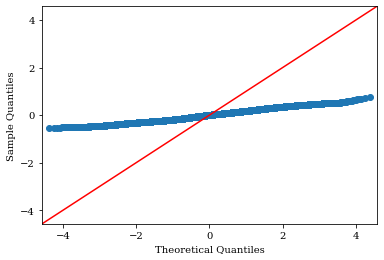

In [16]:
formula_key = 'simple_evo_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='comb_anova'></a>
### combined factors (combines factors from 'simple*' models into fewer factors)
[top](#home)


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
architecture             35.473193      11.0    85.867542  5.504392e-195   
landscape               109.438083       2.0  1457.001219   0.000000e+00   
demography              322.558594       4.0  2147.187941   0.000000e+00   
C(garden)              1941.690095      99.0   522.235216   0.000000e+00   
cor_TPR_temp              0.024475       1.0     0.651692   4.195096e-01   
cor_TPR_sal               3.093137       1.0    82.360815   1.144791e-19   
cor_FPR_temp_neutSNPs     0.282232       1.0     7.514978   6.119406e-03   
cor_FPR_sal_neutSNPs     14.452538       1.0   384.827025   1.360765e-85   
final_LA                  6.137120       1.0   163.412799   2.110306e-37   
Residual               6755.486285  179878.0          NaN            NaN   

                       perc_sum_sq  
architecture                  0.39  
landscape                     1.19  
demography                    3.51  
C(garden)                    21.13  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.03  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.07  
Residual                     73.52

Model:              OLS              Adj. R-squared:     0.403      
Dependent Variable: score            AIC:                -79806.4688
Date:               2024-01-11 12:44 BIC:                -78574.1819
No. Observations:   180000           Log-Likelihood:     40025.     
Df Model:           121              F-statistic:        1007.      
Df Residuals:       179878           Prob (F-statistic): 0.00       
R-squared:          0.404            Scale:              0.037556   


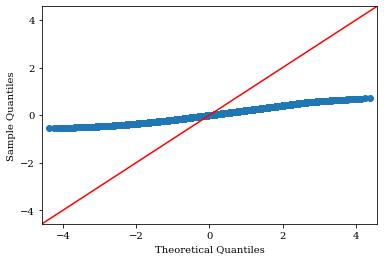


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
architecture             20.401706      11.0   113.980963  3.510935e-261   
landscape                45.947129       2.0  1411.844602   0.000000e+00   
demography               30.224483       4.0   464.362774   0.000000e+00   
C(garden)              4962.472456      99.0  3080.501510   0.000000e+00   
cor_TPR_temp              0.982304       1.0    60.367668   7.910769e-15   
cor_TPR_sal               0.968789       1.0    59.537077   1.206240e-14   
cor_FPR_temp_neutSNPs     2.566174       1.0   157.704684   3.718451e-36   
cor_FPR_sal_neutSNPs      0.038710       1.0     2.378945   1.229823e-01   
final_LA                 62.639796       1.0  3849.540076   0.000000e+00   
Residual               2926.978544  179878.0          NaN            NaN   

                       perc_sum_sq  
architecture                  0.25  
landscape                     0.57  
demography                    0.38  
C(garden)                    61.62  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.03  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.78  
Residual                     36.35

Model:              OLS              Adj. R-squared:     0.770       
Dependent Variable: score            AIC:                -230355.6393
Date:               2024-01-11 12:44 BIC:                -229123.3524
No. Observations:   180000           Log-Likelihood:     1.1530e+05  
Df Model:           121              F-statistic:        4970.       
Df Residuals:       179878           Prob (F-statistic): 0.00        
R-squared:          0.770            Scale:              0.016272    


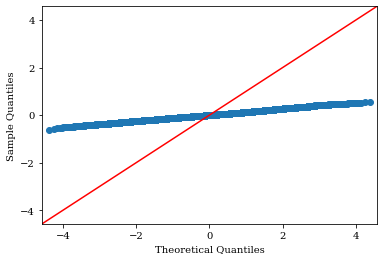


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
lfmm2


sum_sq        df            F         PR(>F)  \
architecture             13.264718      11.0    97.490403  2.393944e-222   
landscape                55.343142       2.0  2237.125581   0.000000e+00   
demography               78.874810       4.0  1594.170908   0.000000e+00   
C(garden)               391.270017      99.0   319.519906   0.000000e+00   
cor_TPR_temp              4.249533       1.0   343.556162   1.264676e-76   
cor_TPR_sal               3.794774       1.0   306.790890   1.245762e-68   
cor_FPR_temp_neutSNPs    16.298524       1.0  1317.664403  1.815517e-287   
cor_FPR_sal_neutSNPs      0.000236       1.0     0.019094   8.900976e-01   
final_LA                 37.736958       1.0  3050.868107   0.000000e+00   
Residual               2224.956403  179878.0          NaN            NaN   

                       perc_sum_sq  
architecture                  0.47  
landscape                     1.96  
demography                    2.79  
C(garden)                    13.85  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.13  
cor_FPR_temp_neutSNPs         0.58  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      1.34  
Residual                     78.74

Model:              OLS              Adj. R-squared:     0.667       
Dependent Variable: score            AIC:                -279717.6434
Date:               2024-01-11 12:44 BIC:                -278485.3565
No. Observations:   180000           Log-Likelihood:     1.3998e+05  
Df Model:           121              F-statistic:        2984.       
Df Residuals:       179878           Prob (F-statistic): 0.00        
R-squared:          0.667            Scale:              0.012369    


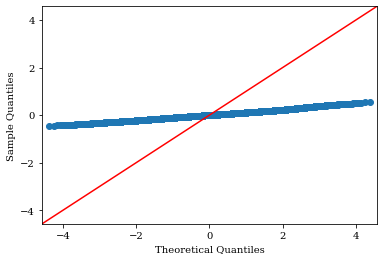


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
GF


sum_sq        df             F         PR(>F)  \
architecture             25.900646      11.0    243.304068   0.000000e+00   
landscape               289.022817       2.0  14932.536599   0.000000e+00   
demography               72.532922       4.0   1873.728375   0.000000e+00   
C(garden)               392.397617      99.0    409.564796   0.000000e+00   
cor_TPR_temp              4.509216       1.0    465.942712  3.311691e-103   
cor_TPR_sal               2.506138       1.0    258.962201   3.173104e-58   
cor_FPR_temp_neutSNPs    41.351461       1.0   4272.895944   0.000000e+00   
cor_FPR_sal_neutSNPs     37.848714       1.0   3910.952872   0.000000e+00   
final_LA                 50.102077       1.0   5177.107478   0.000000e+00   
Residual               1740.790857  179878.0           NaN            NaN   

                       perc_sum_sq  
architecture                  0.97  
landscape                    10.88  
demography                    2.73  
C(garden)                    14.77  
cor_TPR_temp                  0.17  
cor_TPR_sal                   0.09  
cor_FPR_temp_neutSNPs         1.56  
cor_FPR_sal_neutSNPs          1.42  
final_LA                      1.89  
Residual                     65.52

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -323889.2467
Date:               2024-01-11 12:44 BIC:                -322656.9598
No. Observations:   180000           Log-Likelihood:     1.6207e+05  
Df Model:           121              F-statistic:        6769.       
Df Residuals:       179878           Prob (F-statistic): 0.00        
R-squared:          0.820            Scale:              0.0096776   


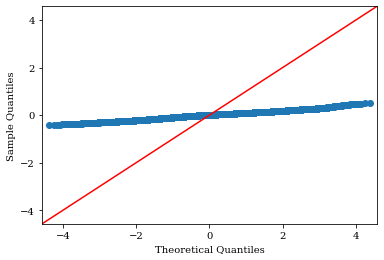


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-nocorr


sum_sq        df             F         PR(>F)  \
architecture             25.548094      11.0    196.942467   0.000000e+00   
landscape               305.125414       2.0  12936.653185   0.000000e+00   
demography               65.336399       4.0   1385.060519   0.000000e+00   
C(garden)               384.324179      99.0    329.181988   0.000000e+00   
cor_TPR_temp              6.951444       1.0    589.452178  5.346166e-130   
cor_TPR_sal               4.211152       1.0    357.087327   1.449142e-79   
cor_FPR_temp_neutSNPs    51.087038       1.0   4331.958394   0.000000e+00   
cor_FPR_sal_neutSNPs     39.718901       1.0   3367.989821   0.000000e+00   
final_LA                 53.577603       1.0   4543.147412   0.000000e+00   
Residual               2121.311764  179878.0           NaN            NaN   

                       perc_sum_sq  
architecture                  0.84  
landscape                     9.98  
demography                    2.14  
C(garden)                    12.57  
cor_TPR_temp                  0.23  
cor_TPR_sal                   0.14  
cor_FPR_temp_neutSNPs         1.67  
cor_FPR_sal_neutSNPs          1.30  
final_LA                      1.75  
Residual                     69.39

Model:              OLS              Adj. R-squared:     0.797       
Dependent Variable: score            AIC:                -288304.1235
Date:               2024-01-11 12:44 BIC:                -287071.8366
No. Observations:   180000           Log-Likelihood:     1.4427e+05  
Df Model:           121              F-statistic:        5857.       
Df Residuals:       179878           Prob (F-statistic): 0.00        
R-squared:          0.798            Scale:              0.011793    


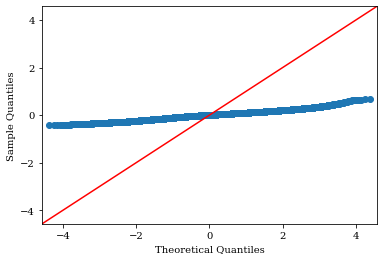


combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-structcorr


sum_sq        df            F         PR(>F)  \
architecture             86.643238      11.0   251.373559   0.000000e+00   
landscape                27.827984       2.0   444.047425  4.237950e-193   
demography              689.518260       4.0  5501.275403   0.000000e+00   
C(garden)               184.307173      99.0    59.413433   0.000000e+00   
cor_TPR_temp             13.581079       1.0   433.422934   3.798590e-96   
cor_TPR_sal               1.102722       1.0    35.191962   2.992977e-09   
cor_FPR_temp_neutSNPs     3.370728       1.0   107.572528   3.389811e-25   
cor_FPR_sal_neutSNPs     44.814269       1.0  1430.190603  9.813690e-312   
final_LA                 28.193520       1.0   899.760462  3.404124e-197   
Residual               5636.382317  179878.0          NaN            NaN   

                       perc_sum_sq  
architecture                  1.29  
landscape                     0.41  
demography                   10.27  
C(garden)                     2.74  
cor_TPR_temp                  0.20  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.05  
cor_FPR_sal_neutSNPs          0.67  
final_LA                      0.42  
Residual                     83.93

Model:              OLS              Adj. R-squared:     0.394       
Dependent Variable: score            AIC:                -112406.7244
Date:               2024-01-11 12:44 BIC:                -111174.4375
No. Observations:   180000           Log-Likelihood:     56325.      
Df Model:           121              F-statistic:        968.1       
Df Residuals:       179878           Prob (F-statistic): 0.00        
R-squared:          0.394            Scale:              0.031334    


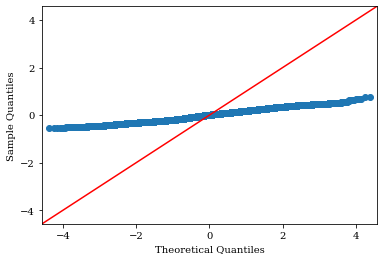

In [17]:
formula_key = 'combined'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 6.428730       1.0   201.928939   8.389883e-46   
architecture             15.471462      11.0    44.178610   4.320965e-97   
landscape               135.124124       2.0  2122.150887   0.000000e+00   
demography              290.608128       4.0  2282.028833   0.000000e+00   
C(garden)               901.165763      99.0   285.918892   0.000000e+00   
cor_TPR_temp              0.005057       1.0     0.158856   6.902128e-01   
cor_TPR_sal               0.110834       1.0     3.481347   6.206582e-02   
cor_FPR_temp_neutSNPs     0.244783       1.0     7.688720   5.557274e-03   
cor_FPR_sal_neutSNPs      9.402995       1.0   295.351763   3.832445e-66   
final_LA                  3.978564       1.0   124.968249   5.286883e-29   
final_LA:architecture    20.326716      11.0    58.042740  1.420733e-129   
final_LA:landscape       78.964513       2.0  1240.153177   0.000000e+00   
final_LA:C(garden)      911.385509      99.0   289.161379   0.000000e+00   
final_LA:slevel          10.858828       1.0   341.080036   4.367618e-76   
Residual               5723.137665  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.08  
architecture                  0.19  
landscape                     1.67  
demography                    3.58  
C(garden)                    11.12  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.12  
final_LA                      0.05  
final_LA:architecture         0.25  
final_LA:landscape            0.97  
final_LA:C(garden)           11.24  
final_LA:slevel               0.13  
Residual                     70.59

Model:              OLS              Adj. R-squared:     0.494       
Dependent Variable: score            AIC:                -109433.2656
Date:               2024-01-11 12:44 BIC:                -107069.6990
No. Observations:   180000           Log-Likelihood:     54951.      
Df Model:           233              F-statistic:        755.8       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.495            Scale:              0.031837    


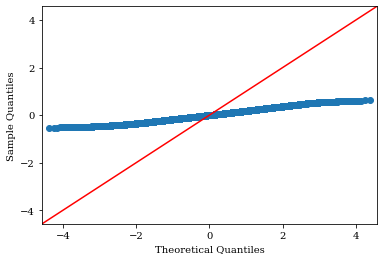


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df           F         PR(>F)  \
Intercept                 1.733292       1.0  128.364851   9.559289e-30   
architecture              4.284174      11.0   28.843554   2.272341e-61   
landscape                 4.397687       2.0  162.842836   2.199082e-71   
demography               43.202734       4.0  799.881382   0.000000e+00   
C(garden)               345.684857      99.0  258.594636   0.000000e+00   
cor_TPR_temp              0.562713       1.0   41.673657   1.081256e-10   
cor_TPR_sal               0.179127       1.0   13.265887   2.703555e-04   
cor_FPR_temp_neutSNPs     5.512504       1.0  408.247283   1.113400e-90   
cor_FPR_sal_neutSNPs      0.042078       1.0    3.116238   7.751725e-02   
final_LA                  7.048779       1.0  522.021301  2.247397e-115   
final_LA:architecture     2.799619      11.0   18.848664   2.355468e-38   
final_LA:landscape        8.275174       2.0  306.423100  1.407551e-133   
final_LA:C(garden)      442.780039      99.0  331.228114   0.000000e+00   
final_LA:slevel           0.011466       1.0    0.849144   3.567959e-01   
Residual               2427.354474  179766.0         NaN            NaN   

                       perc_sum_sq  
Intercept                     0.05  
architecture                  0.13  
landscape                     0.13  
demography                    1.31  
C(garden)                    10.49  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.17  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      0.21  
final_LA:architecture         0.08  
final_LA:landscape            0.25  
final_LA:C(garden)           13.44  
final_LA:slevel               0.00  
Residual                     73.69

Model:              OLS              Adj. R-squared:     0.809       
Dependent Variable: score            AIC:                -263822.0065
Date:               2024-01-11 12:45 BIC:                -261458.4398
No. Observations:   180000           Log-Likelihood:     1.3215e+05  
Df Model:           233              F-statistic:        3269.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.013503    


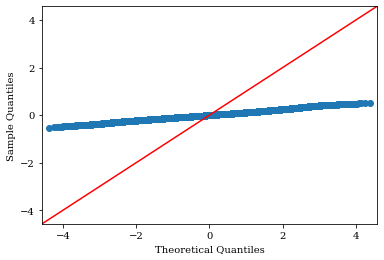


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df            F         PR(>F)  \
Intercept                 1.362503       1.0   132.133795   1.433560e-30   
architecture              4.542520      11.0    40.047989   1.932831e-87   
landscape               110.266675       2.0  5346.761154   0.000000e+00   
demography               87.563609       4.0  2122.951939   0.000000e+00   
C(garden)               177.140650      99.0   173.523995   0.000000e+00   
cor_TPR_temp              0.485841       1.0    47.116273   6.711347e-12   
cor_TPR_sal               0.545480       1.0    52.899913   3.524048e-13   
cor_FPR_temp_neutSNPs    11.092776       1.0  1075.763385  3.048622e-235   
cor_FPR_sal_neutSNPs      0.856569       1.0    83.069008   8.002054e-20   
final_LA                 11.780607       1.0  1142.468347  1.188953e-249   
final_LA:architecture     3.710746      11.0    32.714863   2.349437e-70   
final_LA:landscape       77.837108       2.0  3774.271983   0.000000e+00   
final_LA:C(garden)      141.505541      99.0   138.616444   0.000000e+00   
final_LA:slevel           0.735059       1.0    71.285053   3.114225e-17   
Residual               1853.664168  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.05  
architecture                  0.18  
landscape                     4.44  
demography                    3.53  
C(garden)                     7.13  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.45  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      0.47  
final_LA:architecture         0.15  
final_LA:landscape            3.13  
final_LA:C(garden)            5.70  
final_LA:slevel               0.03  
Residual                     74.65

Model:              OLS              Adj. R-squared:     0.723       
Dependent Variable: score            AIC:                -312356.7851
Date:               2024-01-11 12:45 BIC:                -309993.2185
No. Observations:   180000           Log-Likelihood:     1.5641e+05  
Df Model:           233              F-statistic:        2013.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.723            Scale:              0.010312    


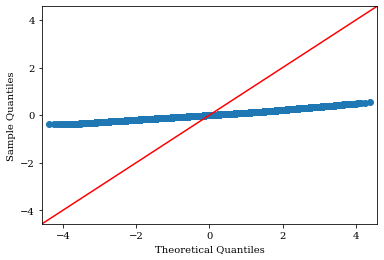


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F         PR(>F)  \
Intercept                 0.370525       1.0    42.759126   6.207727e-11   
architecture              3.528930      11.0    37.022114   2.210104e-80   
landscape                76.917059       2.0  4438.166324   0.000000e+00   
demography               64.513579       4.0  1861.238576   0.000000e+00   
C(garden)                61.531391      99.0    71.725310   0.000000e+00   
cor_TPR_temp              2.367385       1.0   273.199382   2.529272e-61   
cor_TPR_sal               0.070418       1.0     8.126291   4.363287e-03   
cor_FPR_temp_neutSNPs    33.743260       1.0  3894.017887   0.000000e+00   
cor_FPR_sal_neutSNPs     32.164154       1.0  3711.786875   0.000000e+00   
final_LA                  7.034540       1.0   811.795472  3.675739e-178   
final_LA:architecture     2.300787      11.0    24.137627   1.713416e-50   
final_LA:landscape       23.993886       2.0  1384.463470   0.000000e+00   
final_LA:C(garden)       96.450713      99.0   112.429724   0.000000e+00   
final_LA:slevel           0.031614       1.0     3.648259   5.612943e-02   
Residual               1557.746046  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.02  
architecture                  0.18  
landscape                     3.92  
demography                    3.29  
C(garden)                     3.13  
cor_TPR_temp                  0.12  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         1.72  
cor_FPR_sal_neutSNPs          1.64  
final_LA                      0.36  
final_LA:architecture         0.12  
final_LA:landscape            1.22  
final_LA:C(garden)            4.91  
final_LA:slevel               0.00  
Residual                     79.36

Model:              OLS              Adj. R-squared:     0.839       
Dependent Variable: score            AIC:                -343663.1731
Date:               2024-01-11 12:45 BIC:                -341299.6065
No. Observations:   180000           Log-Likelihood:     1.7207e+05  
Df Model:           233              F-statistic:        4017.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.839            Scale:              0.0086654   


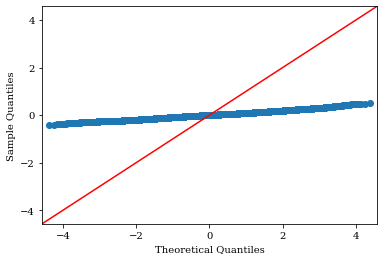


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F         PR(>F)  \
Intercept                 0.023235       1.0     2.221254   1.361242e-01   
architecture              4.560746      11.0    39.637154   1.758432e-86   
landscape               142.645086       2.0  6818.456720   0.000000e+00   
demography               62.966013       4.0  1504.892464   0.000000e+00   
C(garden)                66.573056      99.0    64.286912   0.000000e+00   
cor_TPR_temp              3.607337       1.0   344.862519   6.577738e-77   
cor_TPR_sal               0.270211       1.0    25.832255   3.727848e-07   
cor_FPR_temp_neutSNPs    43.511384       1.0  4159.701447   0.000000e+00   
cor_FPR_sal_neutSNPs     30.437442       1.0  2909.828667   0.000000e+00   
final_LA                  9.168132       1.0   876.476171  3.708721e-192   
final_LA:architecture     3.701220      11.0    32.167067   4.406542e-69   
final_LA:landscape       58.776539       2.0  2809.527476   0.000000e+00   
final_LA:C(garden)       99.545283      99.0    96.126860   0.000000e+00   
final_LA:slevel           0.077241       1.0     7.384277   6.580283e-03   
Residual               1880.391536  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
architecture                  0.19  
landscape                     5.93  
demography                    2.62  
C(garden)                     2.77  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.81  
cor_FPR_sal_neutSNPs          1.26  
final_LA                      0.38  
final_LA:architecture         0.15  
final_LA:landscape            2.44  
final_LA:C(garden)            4.14  
final_LA:slevel               0.00  
Residual                     78.15

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -309779.9578
Date:               2024-01-11 12:45 BIC:                -307416.3912
No. Observations:   180000           Log-Likelihood:     1.5512e+05  
Df Model:           233              F-statistic:        3528.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.821            Scale:              0.010460    


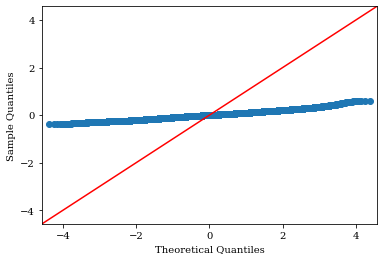


combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept                87.852280       1.0  2908.489540   0.000000e+00   
architecture            113.233926      11.0   340.799030   0.000000e+00   
landscape               140.432048       2.0  2324.613222   0.000000e+00   
demography              630.861851       4.0  5221.421397   0.000000e+00   
C(garden)                20.501152      99.0     6.855791   4.864517e-87   
cor_TPR_temp              5.960410       1.0   197.328853   8.442936e-45   
cor_TPR_sal               0.286841       1.0     9.496315   2.059160e-03   
cor_FPR_temp_neutSNPs     0.906164       1.0    30.000016   4.326194e-08   
cor_FPR_sal_neutSNPs     44.517570       1.0  1473.824994  3.863593e-321   
final_LA                 46.861960       1.0  1551.439768   0.000000e+00   
final_LA:architecture   104.292920      11.0   313.889373   0.000000e+00   
final_LA:landscape      160.191430       2.0  2651.696112   0.000000e+00   
final_LA:C(garden)       12.761812      99.0     4.267678   1.764016e-41   
final_LA:slevel          61.706502       1.0  2042.891966   0.000000e+00   
Residual               5429.915669  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     1.28  
architecture                  1.65  
landscape                     2.05  
demography                    9.20  
C(garden)                     0.30  
cor_TPR_temp                  0.09  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.65  
final_LA                      0.68  
final_LA:architecture         1.52  
final_LA:landscape            2.34  
final_LA:C(garden)            0.19  
final_LA:slevel               0.90  
Residual                     79.15

Model:              OLS              Adj. R-squared:     0.416       
Dependent Variable: score            AIC:                -118900.1126
Date:               2024-01-11 12:45 BIC:                -116536.5460
No. Observations:   180000           Log-Likelihood:     59684.      
Df Model:           233              F-statistic:        550.9       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.417            Scale:              0.030205    


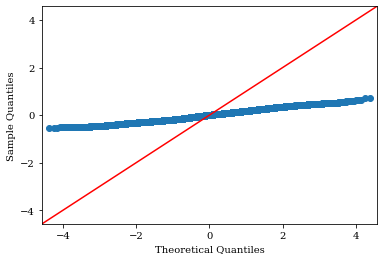

In [18]:
formula_key = 'combined_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='sanity_anova'></a>
### sanity check
[top](#home)


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
landscape               169.212481       2.0  2241.175503  0.000000e+00   
demography              421.750971       4.0  2792.991203  0.000000e+00   
C(garden)              1941.690095      99.0   519.539042  0.000000e+00   
cor_TPR_temp              4.103888       1.0   108.709867  1.910343e-25   
cor_TPR_sal               0.000453       1.0     0.012010  9.127346e-01   
cor_FPR_temp_neutSNPs     0.379125       1.0    10.042829  1.529678e-03   
cor_FPR_sal_neutSNPs     15.522619       1.0   411.186135  2.560486e-91   
final_LA                 80.367610       1.0  2128.896377  0.000000e+00   
Residual               6790.959478  179889.0          NaN           NaN   

                       perc_sum_sq  
landscape                     1.80  
demography                    4.48  
C(garden)                    20.60  
cor_TPR_temp                  0.04  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.16  
final_LA                      0.85  
Residual                     72.06

Model:              OLS              Adj. R-squared:     0.400      
Dependent Variable: score            AIC:                -78885.7582
Date:               2024-01-11 12:45 BIC:                -77764.5791
No. Observations:   180000           Log-Likelihood:     39554.     
Df Model:           110              F-statistic:        1093.      
Df Residuals:       179889           Prob (F-statistic): 0.00       
R-squared:          0.401            Scale:              0.037751   


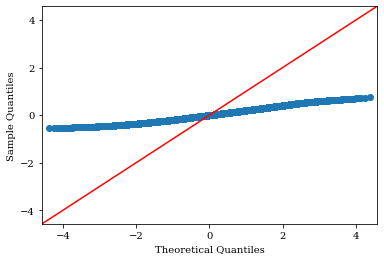


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
RONA-temp_opt


sum_sq        df              F        PR(>F)  \
landscape                72.945432       2.0    2226.058333  0.000000e+00   
demography               28.705842       4.0     438.004662  0.000000e+00   
C(garden)              4962.472456      99.0    3059.365417  0.000000e+00   
cor_TPR_temp              1.530182       1.0      93.392415  4.342321e-22   
cor_TPR_sal               1.459844       1.0      89.099450  3.797127e-21   
cor_FPR_temp_neutSNPs     2.734315       1.0     166.884879  3.686174e-38   
cor_FPR_sal_neutSNPs      0.027932       1.0       1.704771  1.916669e-01   
final_LA               3765.744972       1.0  229836.681970  0.000000e+00   
Residual               2947.380250  179889.0            NaN           NaN   

                       perc_sum_sq  
landscape                     0.62  
demography                    0.24  
C(garden)                    42.12  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.02  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     31.96  
Residual                     25.01

Model:              OLS              Adj. R-squared:     0.768       
Dependent Variable: score            AIC:                -229127.3507
Date:               2024-01-11 12:45 BIC:                -228006.1717
No. Observations:   180000           Log-Likelihood:     1.1467e+05  
Df Model:           110              F-statistic:        5418.       
Df Residuals:       179889           Prob (F-statistic): 0.00        
R-squared:          0.768            Scale:              0.016384    


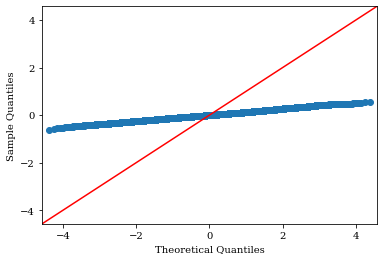


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
lfmm2


sum_sq        df              F         PR(>F)  \
landscape                70.263078       2.0    2823.571532   0.000000e+00   
demography               76.271418       4.0    1532.510457   0.000000e+00   
C(garden)               391.270017      99.0     317.645709   0.000000e+00   
cor_TPR_temp              4.452898       1.0     357.885731   9.718458e-80   
cor_TPR_sal               3.088611       1.0     248.236034   6.862182e-56   
cor_FPR_temp_neutSNPs    17.952638       1.0    1442.878968  1.804854e-314   
cor_FPR_sal_neutSNPs      0.000569       1.0       0.045718   8.306887e-01   
final_LA               2495.496152       1.0  200566.558522   0.000000e+00   
Residual               2238.221120  179889.0            NaN            NaN   

                       perc_sum_sq  
landscape                     1.33  
demography                    1.44  
C(garden)                     7.39  
cor_TPR_temp                  0.08  
cor_TPR_sal                   0.06  
cor_FPR_temp_neutSNPs         0.34  
cor_FPR_sal_neutSNPs          0.00  
final_LA                     47.11  
Residual                     42.25

Model:              OLS              Adj. R-squared:     0.665       
Dependent Variable: score            AIC:                -278669.7078
Date:               2024-01-11 12:45 BIC:                -277548.5288
No. Observations:   180000           Log-Likelihood:     1.3945e+05  
Df Model:           110              F-statistic:        3253.       
Df Residuals:       179889           Prob (F-statistic): 0.00        
R-squared:          0.665            Scale:              0.012442    


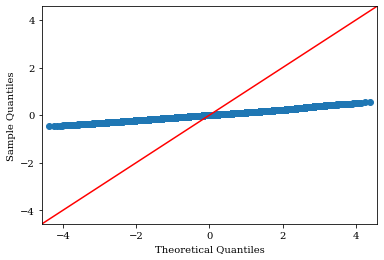


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
GF


sum_sq        df              F        PR(>F)  \
landscape               345.291664       2.0   17579.235558  0.000000e+00   
demography              102.729929       4.0    2615.055334  0.000000e+00   
C(garden)               392.397617      99.0     403.585035  0.000000e+00   
cor_TPR_temp              3.765407       1.0     383.403270  2.773846e-85   
cor_TPR_sal               3.203890       1.0     326.228187  7.393608e-73   
cor_FPR_temp_neutSNPs    44.769769       1.0    4558.571169  0.000000e+00   
cor_FPR_sal_neutSNPs     37.207097       1.0    3788.520766  0.000000e+00   
final_LA               3990.150106       1.0  406287.182077  0.000000e+00   
Residual               1766.691503  179889.0            NaN           NaN   

                       perc_sum_sq  
landscape                     5.16  
demography                    1.54  
C(garden)                     5.87  
cor_TPR_temp                  0.06  
cor_TPR_sal                   0.05  
cor_FPR_temp_neutSNPs         0.67  
cor_FPR_sal_neutSNPs          0.56  
final_LA                     59.68  
Residual                     26.42

Model:              OLS              Adj. R-squared:     0.817       
Dependent Variable: score            AIC:                -321252.8150
Date:               2024-01-11 12:45 BIC:                -320131.6359
No. Observations:   180000           Log-Likelihood:     1.6074e+05  
Df Model:           110              F-statistic:        7313.       
Df Residuals:       179889           Prob (F-statistic): 0.00        
R-squared:          0.817            Scale:              0.0098210   


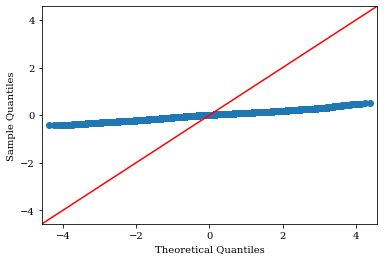


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-nocorr


sum_sq        df              F         PR(>F)  \
landscape               352.465069       2.0   14766.820616   0.000000e+00   
demography               85.637869       4.0    1793.935279   0.000000e+00   
C(garden)               384.324179      99.0     325.284542   0.000000e+00   
cor_TPR_temp              4.457724       1.0     373.520233   3.892963e-83   
cor_TPR_sal               6.068756       1.0     508.511283  1.916493e-112   
cor_FPR_temp_neutSNPs    55.263392       1.0    4630.612616   0.000000e+00   
cor_FPR_sal_neutSNPs     38.886897       1.0    3258.398526   0.000000e+00   
final_LA               3828.014640       1.0  320755.788028   0.000000e+00   
Residual               2146.859858  179889.0            NaN            NaN   

                       perc_sum_sq  
landscape                     5.11  
demography                    1.24  
C(garden)                     5.57  
cor_TPR_temp                  0.06  
cor_TPR_sal                   0.09  
cor_FPR_temp_neutSNPs         0.80  
cor_FPR_sal_neutSNPs          0.56  
final_LA                     55.46  
Residual                     31.10

Model:              OLS              Adj. R-squared:     0.795       
Dependent Variable: score            AIC:                -286171.2374
Date:               2024-01-11 12:45 BIC:                -285050.0583
No. Observations:   180000           Log-Likelihood:     1.4320e+05  
Df Model:           110              F-statistic:        6347.       
Df Residuals:       179889           Prob (F-statistic): 0.00        
R-squared:          0.795            Scale:              0.011934    


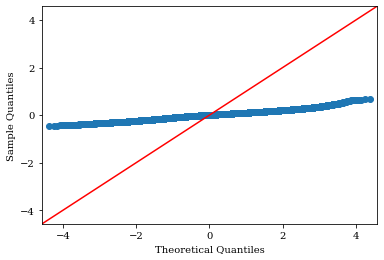


withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
rda-structcorr


sum_sq        df            F         PR(>F)  \
landscape                48.886419       2.0   768.311182   0.000000e+00   
demography              644.344286       4.0  5063.337924   0.000000e+00   
C(garden)               184.307173      99.0    58.517527   0.000000e+00   
cor_TPR_temp              4.861825       1.0   152.819314   4.335436e-35   
cor_TPR_sal               6.055748       1.0   190.347302   2.809343e-43   
cor_FPR_temp_neutSNPs     1.151418       1.0    36.191953   1.791509e-09   
cor_FPR_sal_neutSNPs     43.846692       1.0  1378.211134  1.583057e-300   
final_LA                102.723649       1.0  3228.861074   0.000000e+00   
Residual               5723.025555  179889.0          NaN            NaN   

                       perc_sum_sq  
landscape                     0.72  
demography                    9.53  
C(garden)                     2.73  
cor_TPR_temp                  0.07  
cor_TPR_sal                   0.09  
cor_FPR_temp_neutSNPs         0.02  
cor_FPR_sal_neutSNPs          0.65  
final_LA                      1.52  
Residual                     84.67

Model:              OLS              Adj. R-squared:     0.385       
Dependent Variable: score            AIC:                -109682.7916
Date:               2024-01-11 12:45 BIC:                -108561.6126
No. Observations:   180000           Log-Likelihood:     54952.      
Df Model:           110              F-statistic:        1024.       
Df Residuals:       179889           Prob (F-statistic): 0.00        
R-squared:          0.385            Scale:              0.031814    


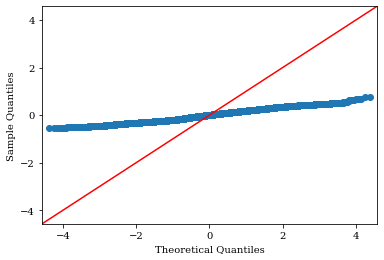

In [19]:
formula_key = 'withLA_woArch'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 0.233134       1.0     7.303528   6.882581e-03   
landscape               152.022366       2.0  2381.249907   0.000000e+00   
demography              283.556451       4.0  2220.787606   0.000000e+00   
C(garden)               901.165763      99.0   285.165494   0.000000e+00   
cor_TPR_temp              0.070735       1.0     2.215954   1.365924e-01   
cor_TPR_sal               1.842070       1.0    57.707679   3.055732e-14   
cor_FPR_temp_neutSNPs     0.072240       1.0     2.263104   1.324900e-01   
cor_FPR_sal_neutSNPs      8.263255       1.0   258.868166   3.326407e-58   
final_LA                  0.350506       1.0    10.980510   9.209326e-04   
final_LA:architecture    40.576831      11.0   115.561435  6.665063e-265   
final_LA:landscape       86.874235       2.0  1360.781769   0.000000e+00   
final_LA:C(garden)      911.385509      99.0   288.399437   0.000000e+00   
final_LA:slevel          20.554935       1.0   643.937308  8.284014e-142   
Residual               5738.609127  179777.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.00  
landscape                     1.87  
demography                    3.48  
C(garden)                    11.06  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.10  
final_LA                      0.00  
final_LA:architecture         0.50  
final_LA:landscape            1.07  
final_LA:C(garden)           11.19  
final_LA:slevel               0.25  
Residual                     70.45

Model:              OLS              Adj. R-squared:     0.493       
Dependent Variable: score            AIC:                -108969.3249
Date:               2024-01-11 12:45 BIC:                -106716.8660
No. Observations:   180000           Log-Likelihood:     54708.      
Df Model:           222              F-statistic:        789.0       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.493            Scale:              0.031921    



withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
Intercept                16.614341       1.0  1228.338884  3.428499e-268   
landscape                13.178237       2.0   487.149677  1.011140e-211   
demography               42.356605       4.0   782.881879   0.000000e+00   
C(garden)               345.684857      99.0   258.154828   0.000000e+00   
cor_TPR_temp              0.386364       1.0    28.564813   9.072391e-08   
cor_TPR_sal               0.046611       1.0     3.446100   6.340284e-02   
cor_FPR_temp_neutSNPs     5.035835       1.0   372.311637   7.127405e-83   
cor_FPR_sal_neutSNPs      0.015124       1.0     1.118141   2.903205e-01   
final_LA                 40.880723       1.0  3022.411993   0.000000e+00   
final_LA:architecture    35.123530      11.0   236.069872   0.000000e+00   
final_LA:landscape       55.171688       2.0  2039.488998   0.000000e+00   
final_LA:C(garden)      442.780039      99.0   330.664773   0.000000e+00   
final_LA:slevel          17.028709       1.0  1258.974156  8.377965e-275   
Residual               2431.638648  179777.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.48  
landscape                     0.38  
demography                    1.23  
C(garden)                    10.03  
cor_TPR_temp                  0.01  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.15  
cor_FPR_sal_neutSNPs          0.00  
final_LA                      1.19  
final_LA:architecture         1.02  
final_LA:landscape            1.60  
final_LA:C(garden)           12.85  
final_LA:slevel               0.49  
Residual                     70.57

Model:              OLS              Adj. R-squared:     0.808       
Dependent Variable: score            AIC:                -263526.5944
Date:               2024-01-11 12:46 BIC:                -261274.1356
No. Observations:   180000           Log-Likelihood:     1.3199e+05  
Df Model:           222              F-statistic:        3424.       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.013526    



withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df             F         PR(>F)  \
Intercept                 3.740775       1.0    361.910974   1.296914e-80   
landscape               162.875966       2.0   7878.927775   0.000000e+00   
demography               87.521470       4.0   2116.872610   0.000000e+00   
C(garden)               177.140650      99.0    173.110396   0.000000e+00   
cor_TPR_temp              0.859667       1.0     83.170720   7.600904e-20   
cor_TPR_sal               0.666130       1.0     64.446507   9.978122e-16   
cor_FPR_temp_neutSNPs    10.978813       1.0   1062.173624  2.632306e-232   
cor_FPR_sal_neutSNPs      0.826778       1.0     79.988748   3.799963e-19   
final_LA                 37.164529       1.0   3595.578271   0.000000e+00   
final_LA:architecture    30.065292      11.0    264.431297   0.000000e+00   
final_LA:landscape      218.618815       2.0  10575.420614   0.000000e+00   
final_LA:C(garden)      141.505541      99.0    138.286047   0.000000e+00   
final_LA:slevel          21.341610       1.0   2064.749159   0.000000e+00   
Residual               1858.206688  179777.0           NaN            NaN   

                       perc_sum_sq  
Intercept                     0.14  
landscape                     5.92  
demography                    3.18  
C(garden)                     6.44  
cor_TPR_temp                  0.03  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.40  
cor_FPR_sal_neutSNPs          0.03  
final_LA                      1.35  
final_LA:architecture         1.09  
final_LA:landscape            7.95  
final_LA:C(garden)            5.14  
final_LA:slevel               0.78  
Residual                     67.53

Model:              OLS              Adj. R-squared:     0.722       
Dependent Variable: score            AIC:                -311938.2234
Date:               2024-01-11 12:46 BIC:                -309685.7646
No. Observations:   180000           Log-Likelihood:     1.5619e+05  
Df Model:           222              F-statistic:        2106.       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.722            Scale:              0.010336    



withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F        PR(>F)  \
Intercept                 0.022233       1.0     2.560032  1.095981e-01   
landscape                93.818683       2.0  5401.496076  0.000000e+00   
demography               65.613418       4.0  1888.806199  0.000000e+00   
C(garden)                61.531391      99.0    71.567570  0.000000e+00   
cor_TPR_temp              2.394037       1.0   275.667490  7.343968e-62   
cor_TPR_sal               0.504902       1.0    58.138179  2.455283e-14   
cor_FPR_temp_neutSNPs    34.834775       1.0  4011.139261  0.000000e+00   
cor_FPR_sal_neutSNPs     31.693398       1.0  3649.417374  0.000000e+00   
final_LA                 35.188916       1.0  4051.917701  0.000000e+00   
final_LA:architecture    38.230143      11.0   400.191600  0.000000e+00   
final_LA:landscape       92.153778       2.0  5305.641242  0.000000e+00   
final_LA:C(garden)       96.450713      99.0   112.182465  0.000000e+00   
final_LA:slevel          21.222796       1.0  2443.753084  0.000000e+00   
Residual               1561.274975  179777.0          NaN           NaN   

                       perc_sum_sq  
Intercept                     0.00  
landscape                     4.39  
demography                    3.07  
C(garden)                     2.88  
cor_TPR_temp                  0.11  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         1.63  
cor_FPR_sal_neutSNPs          1.48  
final_LA                      1.65  
final_LA:architecture         1.79  
final_LA:landscape            4.32  
final_LA:C(garden)            4.52  
final_LA:slevel               0.99  
Residual                     73.13

Model:              OLS              Adj. R-squared:     0.838       
Dependent Variable: score            AIC:                -343277.8609
Date:               2024-01-11 12:46 BIC:                -341025.4021
No. Observations:   180000           Log-Likelihood:     1.7186e+05  
Df Model:           222              F-statistic:        4205.       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.839            Scale:              0.0086845   


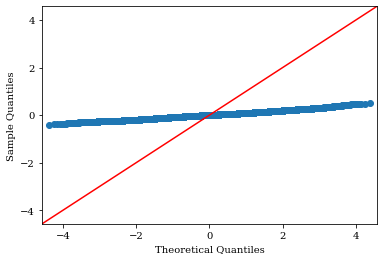


withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F        PR(>F)  \
Intercept                 0.149809       1.0    14.288054  1.569078e-04   
landscape               165.002765       2.0  7868.555174  0.000000e+00   
demography               63.292574       4.0  1509.129594  0.000000e+00   
C(garden)                66.573056      99.0    64.135291  0.000000e+00   
cor_TPR_temp              3.665596       1.0   349.605563  6.125974e-78   
cor_TPR_sal               1.039557       1.0    99.147596  2.376572e-23   
cor_FPR_temp_neutSNPs    44.675203       1.0  4260.889817  0.000000e+00   
cor_FPR_sal_neutSNPs     30.087678       1.0  2869.607152  0.000000e+00   
final_LA                 39.516425       1.0  3768.872254  0.000000e+00   
final_LA:architecture    33.690063      11.0   292.107632  0.000000e+00   
final_LA:landscape      142.458539       2.0  6793.479351  0.000000e+00   
final_LA:C(garden)       99.545283      99.0    95.900144  0.000000e+00   
final_LA:slevel          15.874502       1.0  1514.027921  0.000000e+00   
Residual               1884.952281  179777.0          NaN           NaN   

                       perc_sum_sq  
Intercept                     0.01  
landscape                     6.37  
demography                    2.44  
C(garden)                     2.57  
cor_TPR_temp                  0.14  
cor_TPR_sal                   0.04  
cor_FPR_temp_neutSNPs         1.72  
cor_FPR_sal_neutSNPs          1.16  
final_LA                      1.53  
final_LA:architecture         1.30  
final_LA:landscape            5.50  
final_LA:C(garden)            3.84  
final_LA:slevel               0.61  
Residual                     72.76

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -309365.9102
Date:               2024-01-11 12:46 BIC:                -307113.4514
No. Observations:   180000           Log-Likelihood:     1.5491e+05  
Df Model:           222              F-statistic:        3692.       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.820            Scale:              0.010485    


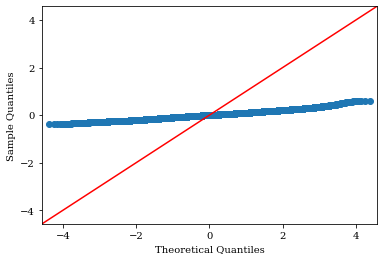


withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept                27.687648       1.0   897.973644  8.294296e-197   
landscape                64.584855       2.0  1047.317163   0.000000e+00   
demography              611.741286       4.0  4960.041728   0.000000e+00   
C(garden)                20.501152      99.0     6.716153   1.767592e-84   
cor_TPR_temp             11.299956       1.0   366.483388   1.316211e-81   
cor_TPR_sal               3.214223       1.0   104.244602   1.815936e-24   
cor_FPR_temp_neutSNPs     0.221277       1.0     7.176513   7.387084e-03   
cor_FPR_sal_neutSNPs     51.975347       1.0  1685.679207   0.000000e+00   
final_LA                  0.019644       1.0     0.637097   4.247650e-01   
final_LA:architecture    30.783425      11.0    90.761523  1.665301e-206   
final_LA:landscape       77.198592       2.0  1251.863316   0.000000e+00   
final_LA:C(garden)       12.761812      99.0     4.180755   4.797549e-40   
final_LA:slevel           0.001080       1.0     0.035026   8.515414e-01   
Residual               5543.149595  179777.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.43  
landscape                     1.00  
demography                    9.48  
C(garden)                     0.32  
cor_TPR_temp                  0.18  
cor_TPR_sal                   0.05  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.81  
final_LA                      0.00  
final_LA:architecture         0.48  
final_LA:landscape            1.20  
final_LA:C(garden)            0.20  
final_LA:slevel               0.00  
Residual                     85.87

Model:              OLS              Adj. R-squared:     0.404       
Dependent Variable: score            AIC:                -115207.0468
Date:               2024-01-11 12:46 BIC:                -112954.5879
No. Observations:   180000           Log-Likelihood:     57827.      
Df Model:           222              F-statistic:        549.8       
Df Residuals:       179777           Prob (F-statistic): 0.00        
R-squared:          0.404            Scale:              0.030833    


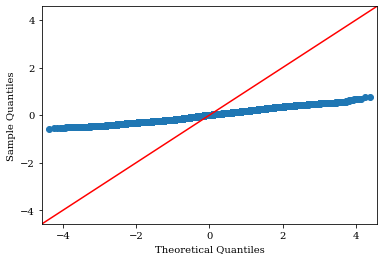

In [20]:
formula_key = 'withLA_woArch_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
RONA-sal_opt


sum_sq        df            F        PR(>F)  \
architecture            109.703683      11.0   265.312681  0.000000e+00   
landscape               136.475938       2.0  1815.329977  0.000000e+00   
demography              409.801989       4.0  2725.483498  0.000000e+00   
C(garden)              1941.690095      99.0   521.764115  0.000000e+00   
cor_TPR_temp              0.140829       1.0     3.746472  5.292066e-02   
cor_TPR_sal               3.283895       1.0    87.361234  9.139097e-21   
cor_FPR_temp_neutSNPs     0.722233       1.0    19.213516  1.169490e-05   
cor_FPR_sal_neutSNPs     14.765093       1.0   392.794737  2.528889e-87   
Residual               6761.623405  179879.0          NaN           NaN   

                       perc_sum_sq  
architecture                  1.17  
landscape                     1.46  
demography                    4.37  
C(garden)                    20.70  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.04  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.16  
Residual                     72.10

Model:              OLS              Adj. R-squared:     0.403      
Dependent Variable: score            AIC:                -79645.0194
Date:               2024-01-11 12:46 BIC:                -78422.8333
No. Observations:   180000           Log-Likelihood:     39944.     
Df Model:           120              F-statistic:        1013.      
Df Residuals:       179879           Prob (F-statistic): 0.00       
R-squared:          0.403            Scale:              0.037590   


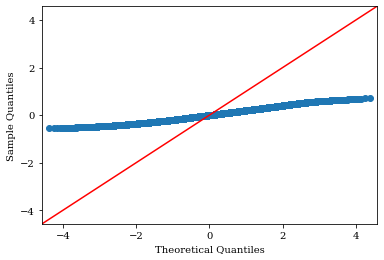


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
RONA-temp_opt


sum_sq        df             F         PR(>F)  \
architecture           3723.506882      11.0  20366.865307   0.000000e+00   
landscape                20.474008       2.0    615.938836  2.588018e-267   
demography               74.543386       4.0   1121.279395   0.000000e+00   
C(garden)              4962.472456      99.0   3015.974257   0.000000e+00   
cor_TPR_temp              2.863286       1.0    172.277830   2.453550e-39   
cor_TPR_sal               1.331430       1.0     80.109349   3.575043e-19   
cor_FPR_temp_neutSNPs     6.859089       1.0    412.696876   1.202912e-91   
cor_FPR_sal_neutSNPs      0.106139       1.0      6.386165   1.150218e-02   
Residual               2989.618340  179879.0           NaN            NaN   

                       perc_sum_sq  
architecture                 31.60  
landscape                     0.17  
demography                    0.63  
C(garden)                    42.12  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.06  
cor_FPR_sal_neutSNPs          0.00  
Residual                     25.37

Model:              OLS              Adj. R-squared:     0.765       
Dependent Variable: score            AIC:                -226546.1292
Date:               2024-01-11 12:46 BIC:                -225323.9430
No. Observations:   180000           Log-Likelihood:     1.1339e+05  
Df Model:           120              F-statistic:        4875.       
Df Residuals:       179879           Prob (F-statistic): 0.00        
R-squared:          0.765            Scale:              0.016620    


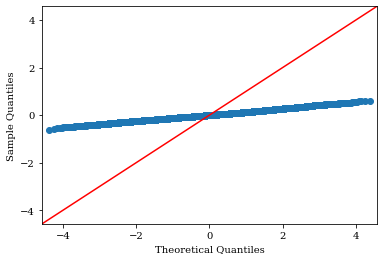


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
lfmm2


sum_sq        df             F         PR(>F)  \
architecture           2471.023912      11.0  17858.255199   0.000000e+00   
landscape                50.914483       2.0   2023.793077   0.000000e+00   
demography              104.428195       4.0   2075.451280   0.000000e+00   
C(garden)               391.270017      99.0    314.192734   0.000000e+00   
cor_TPR_temp              6.814968       1.0    541.774568  1.166391e-119   
cor_TPR_sal               4.326119       1.0    343.916644   1.055905e-76   
cor_FPR_temp_neutSNPs    10.824538       1.0    860.526278  1.046470e-188   
cor_FPR_sal_neutSNPs      0.007186       1.0      0.571233   4.497702e-01   
Residual               2262.693361  179879.0           NaN            NaN   

                       perc_sum_sq  
architecture                 46.60  
landscape                     0.96  
demography                    1.97  
C(garden)                     7.38  
cor_TPR_temp                  0.13  
cor_TPR_sal                   0.08  
cor_FPR_temp_neutSNPs         0.20  
cor_FPR_sal_neutSNPs          0.00  
Residual                     42.67

Model:              OLS              Adj. R-squared:     0.662       
Dependent Variable: score            AIC:                -276692.3071
Date:               2024-01-11 12:46 BIC:                -275470.1209
No. Observations:   180000           Log-Likelihood:     1.3847e+05  
Df Model:           120              F-statistic:        2934.       
Df Residuals:       179879           Prob (F-statistic): 0.00        
R-squared:          0.662            Scale:              0.012579    


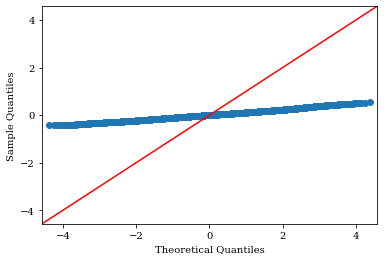


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
GF


sum_sq        df             F         PR(>F)  \
architecture           3965.948675      11.0  36213.061827   0.000000e+00   
landscape               260.525836       2.0  13083.732161   0.000000e+00   
demography               44.648657       4.0   1121.138458   0.000000e+00   
C(garden)               392.397617      99.0    398.109012   0.000000e+00   
cor_TPR_temp              7.591265       1.0    762.473970  1.745737e-167   
cor_TPR_sal               3.009964       1.0    302.323619   1.166836e-67   
cor_FPR_temp_neutSNPs    31.180574       1.0   3131.806697   0.000000e+00   
cor_FPR_sal_neutSNPs     39.291975       1.0   3946.523611   0.000000e+00   
Residual               1790.892933  179879.0           NaN            NaN   

                       perc_sum_sq  
architecture                 60.68  
landscape                     3.99  
demography                    0.68  
C(garden)                     6.00  
cor_TPR_temp                  0.12  
cor_TPR_sal                   0.05  
cor_FPR_temp_neutSNPs         0.48  
cor_FPR_sal_neutSNPs          0.60  
Residual                     27.40

Model:              OLS              Adj. R-squared:     0.815       
Dependent Variable: score            AIC:                -318783.7798
Date:               2024-01-11 12:46 BIC:                -317561.5937
No. Observations:   180000           Log-Likelihood:     1.5951e+05  
Df Model:           120              F-statistic:        6593.       
Df Residuals:       179879           Prob (F-statistic): 0.00        
R-squared:          0.815            Scale:              0.0099561   


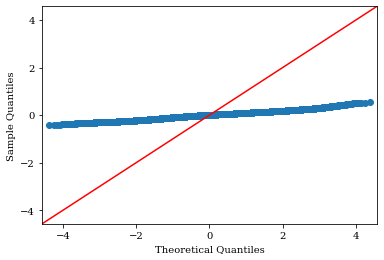


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
rda-nocorr


sum_sq        df             F         PR(>F)  \
architecture           3799.985132      11.0  28571.464824   0.000000e+00   
landscape               278.847589       2.0  11531.351035   0.000000e+00   
demography               43.776888       4.0    905.165905   0.000000e+00   
C(garden)               384.324179      99.0    321.074495   0.000000e+00   
cor_TPR_temp             10.834255       1.0    896.070863  2.138431e-196   
cor_TPR_sal               4.880691       1.0    403.668278   1.099257e-89   
cor_FPR_temp_neutSNPs    39.389265       1.0   3257.775660   0.000000e+00   
cor_FPR_sal_neutSNPs     41.247844       1.0   3411.493483   0.000000e+00   
Residual               2174.889367  179879.0           NaN            NaN   

                       perc_sum_sq  
architecture                 56.06  
landscape                     4.11  
demography                    0.65  
C(garden)                     5.67  
cor_TPR_temp                  0.16  
cor_TPR_sal                   0.07  
cor_FPR_temp_neutSNPs         0.58  
cor_FPR_sal_neutSNPs          0.61  
Residual                     32.09

Model:              OLS              Adj. R-squared:     0.792       
Dependent Variable: score            AIC:                -283816.3577
Date:               2024-01-11 12:46 BIC:                -282594.1715
No. Observations:   180000           Log-Likelihood:     1.4203e+05  
Df Model:           120              F-statistic:        5723.       
Df Residuals:       179879           Prob (F-statistic): 0.00        
R-squared:          0.792            Scale:              0.012091    


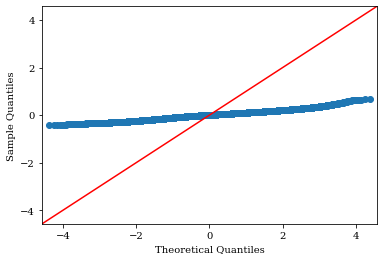


woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
rda-structcorr


sum_sq        df            F         PR(>F)  \
architecture            161.173367      11.0   465.279225   0.000000e+00   
landscape                52.902583       2.0   839.962609   0.000000e+00   
demography              661.666565       4.0  5252.816956   0.000000e+00   
C(garden)               184.307173      99.0    59.118052   0.000000e+00   
cor_TPR_temp             17.365948       1.0   551.456885  9.266258e-122   
cor_TPR_sal               0.877427       1.0    27.862763   1.303827e-07   
cor_FPR_temp_neutSNPs     1.385233       1.0    43.988169   3.312964e-11   
cor_FPR_sal_neutSNPs     45.992671       1.0  1460.500465  2.871272e-318   
Residual               5664.575837  179879.0          NaN            NaN   

                       perc_sum_sq  
architecture                  2.37  
landscape                     0.78  
demography                    9.74  
C(garden)                     2.71  
cor_TPR_temp                  0.26  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.02  
cor_FPR_sal_neutSNPs          0.68  
Residual                     83.42

Model:              OLS              Adj. R-squared:     0.391       
Dependent Variable: score            AIC:                -111510.5981
Date:               2024-01-11 12:46 BIC:                -110288.4119
No. Observations:   180000           Log-Likelihood:     55876.      
Df Model:           120              F-statistic:        963.8       
Df Residuals:       179879           Prob (F-statistic): 0.00        
R-squared:          0.391            Scale:              0.031491    


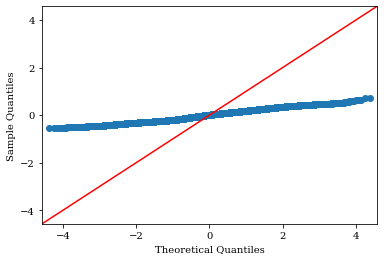

In [21]:
formula_key = 'woLA_withArch'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-sal_opt


sum_sq        df            F         PR(>F)  \
Intercept                 6.428730       1.0   201.928939   8.389883e-46   
architecture             15.471462      11.0    44.178610   4.320965e-97   
landscape               135.124124       2.0  2122.150887   0.000000e+00   
demography              290.608128       4.0  2282.028833   0.000000e+00   
C(garden)               901.165763      99.0   285.918892   0.000000e+00   
cor_TPR_temp              0.005057       1.0     0.158856   6.902128e-01   
cor_TPR_sal               0.110834       1.0     3.481347   6.206582e-02   
cor_FPR_temp_neutSNPs     0.244783       1.0     7.688720   5.557274e-03   
cor_FPR_sal_neutSNPs      9.402995       1.0   295.351763   3.832445e-66   
final_LA:architecture    21.166238      12.0    55.403319  2.667125e-134   
final_LA:landscape       78.964513       2.0  1240.153177   0.000000e+00   
final_LA:C(garden)      911.385509      99.0   289.161379   0.000000e+00   
final_LA:slevel           1.926610       1.0    60.515567   7.338381e-15   
Residual               5723.137665  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.08  
architecture                  0.19  
landscape                     1.67  
demography                    3.59  
C(garden)                    11.13  
cor_TPR_temp                  0.00  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.00  
cor_FPR_sal_neutSNPs          0.12  
final_LA:architecture         0.26  
final_LA:landscape            0.98  
final_LA:C(garden)           11.26  
final_LA:slevel               0.02  
Residual                     70.70

Model:              OLS              Adj. R-squared:     0.494       
Dependent Variable: score            AIC:                -109433.2656
Date:               2024-01-11 12:47 BIC:                -107069.6990
No. Observations:   180000           Log-Likelihood:     54951.      
Df Model:           233              F-statistic:        755.8       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.495            Scale:              0.031837    


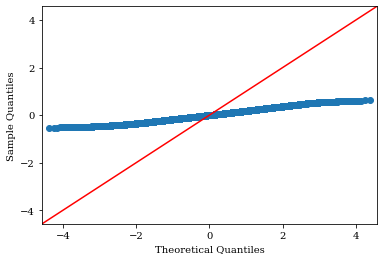


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
RONA-temp_opt


sum_sq        df            F         PR(>F)  \
Intercept                 1.733292       1.0   128.364851   9.559289e-30   
architecture              4.284174      11.0    28.843554   2.272341e-61   
landscape                 4.397687       2.0   162.842836   2.199082e-71   
demography               43.202734       4.0   799.881382   0.000000e+00   
C(garden)               345.684857      99.0   258.594636   0.000000e+00   
cor_TPR_temp              0.562713       1.0    41.673657   1.081256e-10   
cor_TPR_sal               0.179127       1.0    13.265887   2.703555e-04   
cor_FPR_temp_neutSNPs     5.512504       1.0   408.247283   1.113400e-90   
cor_FPR_sal_neutSNPs      0.042078       1.0     3.116238   7.751725e-02   
final_LA:architecture    25.564386      12.0   157.771473   0.000000e+00   
final_LA:landscape        8.275174       2.0   306.423100  1.407551e-133   
final_LA:C(garden)      442.780039      99.0   331.228114   0.000000e+00   
final_LA:slevel          19.090539       1.0  1413.814841  3.335153e-308   
Residual               2427.354474  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.05  
architecture                  0.13  
landscape                     0.13  
demography                    1.30  
C(garden)                    10.39  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         0.17  
cor_FPR_sal_neutSNPs          0.00  
final_LA:architecture         0.77  
final_LA:landscape            0.25  
final_LA:C(garden)           13.30  
final_LA:slevel               0.57  
Residual                     72.92

Model:              OLS              Adj. R-squared:     0.809       
Dependent Variable: score            AIC:                -263822.0065
Date:               2024-01-11 12:47 BIC:                -261458.4398
No. Observations:   180000           Log-Likelihood:     1.3215e+05  
Df Model:           233              F-statistic:        3269.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.013503    


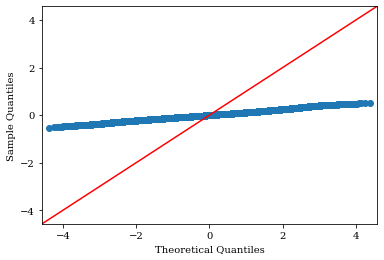


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
lfmm2


sum_sq        df            F         PR(>F)  \
Intercept                 1.362503       1.0   132.133795   1.433560e-30   
architecture              4.542520      11.0    40.047989   1.932831e-87   
landscape               110.266675       2.0  5346.761154   0.000000e+00   
demography               87.563609       4.0  2122.951939   0.000000e+00   
C(garden)               177.140650      99.0   173.523995   0.000000e+00   
cor_TPR_temp              0.485841       1.0    47.116273   6.711347e-12   
cor_TPR_sal               0.545480       1.0    52.899913   3.524048e-13   
cor_FPR_temp_neutSNPs    11.092776       1.0  1075.763385  3.048622e-235   
cor_FPR_sal_neutSNPs      0.856569       1.0    83.069008   8.002054e-20   
final_LA:architecture    23.344592      12.0   188.660745   0.000000e+00   
final_LA:landscape       77.837108       2.0  3774.271983   0.000000e+00   
final_LA:C(garden)      141.505541      99.0   138.616444   0.000000e+00   
final_LA:slevel          18.239570       1.0  1768.850347   0.000000e+00   
Residual               1853.664168  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     0.05  
architecture                  0.18  
landscape                     4.40  
demography                    3.49  
C(garden)                     7.06  
cor_TPR_temp                  0.02  
cor_TPR_sal                   0.02  
cor_FPR_temp_neutSNPs         0.44  
cor_FPR_sal_neutSNPs          0.03  
final_LA:architecture         0.93  
final_LA:landscape            3.10  
final_LA:C(garden)            5.64  
final_LA:slevel               0.73  
Residual                     73.90

Model:              OLS              Adj. R-squared:     0.723       
Dependent Variable: score            AIC:                -312356.7851
Date:               2024-01-11 12:47 BIC:                -309993.2185
No. Observations:   180000           Log-Likelihood:     1.5641e+05  
Df Model:           233              F-statistic:        2013.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.723            Scale:              0.010312    


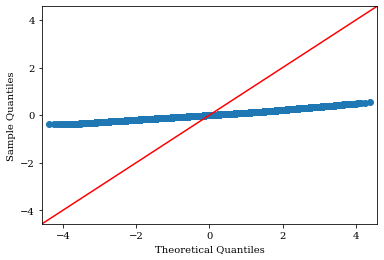


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
GF


sum_sq        df            F        PR(>F)  \
Intercept                 0.370525       1.0    42.759126  6.207727e-11   
architecture              3.528930      11.0    37.022114  2.210104e-80   
landscape                76.917059       2.0  4438.166324  0.000000e+00   
demography               64.513579       4.0  1861.238576  0.000000e+00   
C(garden)                61.531391      99.0    71.725310  0.000000e+00   
cor_TPR_temp              2.367385       1.0   273.199382  2.529272e-61   
cor_TPR_sal               0.070418       1.0     8.126291  4.363287e-03   
cor_FPR_temp_neutSNPs    33.743260       1.0  3894.017887  0.000000e+00   
cor_FPR_sal_neutSNPs     32.164154       1.0  3711.786875  0.000000e+00   
final_LA:architecture    20.618043      12.0   198.279169  0.000000e+00   
final_LA:landscape       23.993886       2.0  1384.463470  0.000000e+00   
final_LA:C(garden)       96.450713      99.0   112.429724  0.000000e+00   
final_LA:slevel          15.767641       1.0  1819.607041  0.000000e+00   
Residual               1557.746046  179766.0          NaN           NaN   

                       perc_sum_sq  
Intercept                     0.02  
architecture                  0.18  
landscape                     3.87  
demography                    3.24  
C(garden)                     3.09  
cor_TPR_temp                  0.12  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         1.70  
cor_FPR_sal_neutSNPs          1.62  
final_LA:architecture         1.04  
final_LA:landscape            1.21  
final_LA:C(garden)            4.85  
final_LA:slevel               0.79  
Residual                     78.29

Model:              OLS              Adj. R-squared:     0.839       
Dependent Variable: score            AIC:                -343663.1731
Date:               2024-01-11 12:47 BIC:                -341299.6065
No. Observations:   180000           Log-Likelihood:     1.7207e+05  
Df Model:           233              F-statistic:        4017.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.839            Scale:              0.0086654   


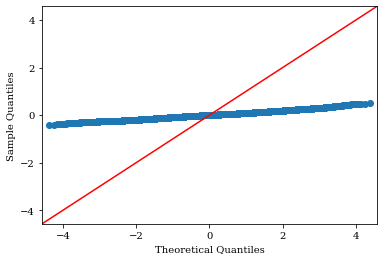


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-nocorr


sum_sq        df            F        PR(>F)  \
Intercept                 0.023235       1.0     2.221254  1.361242e-01   
architecture              4.560746      11.0    39.637154  1.758432e-86   
landscape               142.645086       2.0  6818.456720  0.000000e+00   
demography               62.966013       4.0  1504.892464  0.000000e+00   
C(garden)                66.573056      99.0    64.286912  0.000000e+00   
cor_TPR_temp              3.607337       1.0   344.862519  6.577738e-77   
cor_TPR_sal               0.270211       1.0    25.832255  3.727848e-07   
cor_FPR_temp_neutSNPs    43.511384       1.0  4159.701447  0.000000e+00   
cor_FPR_sal_neutSNPs     30.437442       1.0  2909.828667  0.000000e+00   
final_LA:architecture    26.307425      12.0   209.583150  0.000000e+00   
final_LA:landscape       58.776539       2.0  2809.527476  0.000000e+00   
final_LA:C(garden)       99.545283      99.0    96.126860  0.000000e+00   
final_LA:slevel          19.620693       1.0  1875.744151  0.000000e+00   
Residual               1880.391536  179766.0          NaN           NaN   

                       perc_sum_sq  
Intercept                     0.00  
architecture                  0.19  
landscape                     5.85  
demography                    2.58  
C(garden)                     2.73  
cor_TPR_temp                  0.15  
cor_TPR_sal                   0.01  
cor_FPR_temp_neutSNPs         1.78  
cor_FPR_sal_neutSNPs          1.25  
final_LA:architecture         1.08  
final_LA:landscape            2.41  
final_LA:C(garden)            4.08  
final_LA:slevel               0.80  
Residual                     77.09

Model:              OLS              Adj. R-squared:     0.820       
Dependent Variable: score            AIC:                -309779.9578
Date:               2024-01-11 12:47 BIC:                -307416.3912
No. Observations:   180000           Log-Likelihood:     1.5512e+05  
Df Model:           233              F-statistic:        3528.       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.821            Scale:              0.010460    


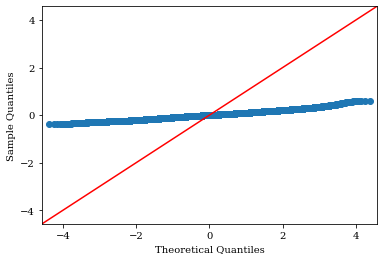


woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
rda-structcorr


sum_sq        df            F         PR(>F)  \
Intercept                87.852280       1.0  2908.489540   0.000000e+00   
architecture            113.233926      11.0   340.799030   0.000000e+00   
landscape               140.432048       2.0  2324.613222   0.000000e+00   
demography              630.861851       4.0  5221.421397   0.000000e+00   
C(garden)                20.501152      99.0     6.855791   4.864517e-87   
cor_TPR_temp              5.960410       1.0   197.328853   8.442936e-45   
cor_TPR_sal               0.286841       1.0     9.496315   2.059160e-03   
cor_FPR_temp_neutSNPs     0.906164       1.0    30.000016   4.326194e-08   
cor_FPR_sal_neutSNPs     44.517570       1.0  1473.824994  3.863593e-321   
final_LA:architecture   106.548058      12.0   293.953585   0.000000e+00   
final_LA:landscape      160.191430       2.0  2651.696112   0.000000e+00   
final_LA:C(garden)       12.761812      99.0     4.267678   1.764016e-41   
final_LA:slevel           0.000233       1.0     0.007699   9.300825e-01   
Residual               5429.915669  179766.0          NaN            NaN   

                       perc_sum_sq  
Intercept                     1.30  
architecture                  1.68  
landscape                     2.08  
demography                    9.34  
C(garden)                     0.30  
cor_TPR_temp                  0.09  
cor_TPR_sal                   0.00  
cor_FPR_temp_neutSNPs         0.01  
cor_FPR_sal_neutSNPs          0.66  
final_LA:architecture         1.58  
final_LA:landscape            2.37  
final_LA:C(garden)            0.19  
final_LA:slevel               0.00  
Residual                     80.40

Model:              OLS              Adj. R-squared:     0.416       
Dependent Variable: score            AIC:                -118900.1126
Date:               2024-01-11 12:47 BIC:                -116536.5460
No. Observations:   180000           Log-Likelihood:     59684.      
Df Model:           233              F-statistic:        550.9       
Df Residuals:       179766           Prob (F-statistic): 0.00        
R-squared:          0.417            Scale:              0.030205    


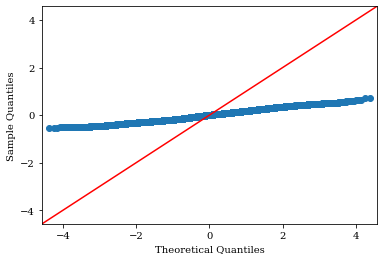

In [22]:
formula_key = 'woLA_withArch_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='sos'></a>
# 3. look at percent sum of squares of factors across methods

[top](#home)

In [23]:
def create_perc_boxplot(formula_key):
    """Calculate and visualize percent sum of squares from factors."""
    percdf = pd.DataFrame(
        [pd.Series(method_df['perc_sum_sq'], name=method)
         for method, method_df in res[formula_key].items()]
    )

    df = pd.DataFrame(columns=['factor', 'program', 'perc'])
    for factor in percdf.columns:
        for program in percdf.index:
            df.loc[nrow(df)] = [factor, program, percdf.loc[program, factor]]
#     print('set(df.factor) - set(mvp.factor_names) = ', set(df.factor) - set(mvp.factor_names))
#     print('set(mvp.factor_names) - set(df.factor) = ', set(mvp.factor_names) - set(df.factor))

    assert df.factor.notnull().all()

    ax = sns.boxplot(data=df, x='factor', y='perc')
    ax.set_ylabel('percentage sum of squares')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim((0, 100))
    plt.draw()  # so ticklabels populate after changing ylim
    ax.set_yticks(ax.get_yticks())  # supresses FixedLocator warning
    ax.set_title(f'{formula_key = }')
    ax.figure.set_size_inches(10, 5)
    
    # reset ylabels to percentages
    nums = [tick.get_text() for tick in ax.get_yticklabels()]
    ax.set_yticklabels([f'{num}%' for num in nums])
    
    # add horizontal lines
    for y in range(0, 100, 10):
        ax.axhline(y=y, color='gainsboro', zorder=0, alpha=0.3)
    
    mvp.update_ticklabels(ax)
    
    save_pdf(op.join(figdir, f'anova_sos_{formula_key}.pdf'))

    plt.show()       
    
    display(percdf)
    
    return df

<a id='ss_anova_sos'></a>
### super simple (excludes slevel)

[top](#home)

percentage sum of squares (super_simple factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_super_simple.pdf


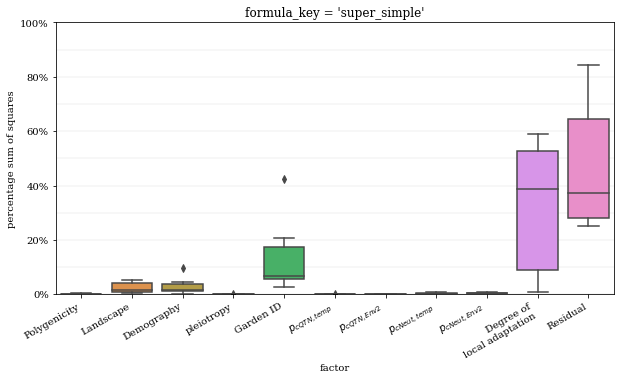

glevel  landscape  demography  plevel_pleio  C(garden)  \
RONA-sal_opt      0.17       1.59        4.60          0.00      20.61   
RONA-temp_opt     0.03       0.64        0.23          0.01      42.52   
lfmm2             0.01       1.34        1.45          0.00       7.50   
GF                0.05       5.24        1.59          0.01       5.97   
rda-nocorr        0.04       5.17        1.28          0.00       5.65   
rda-structcorr    0.29       0.81        9.54          0.04       2.73   

                cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt            0.01         0.04                   0.01   
RONA-temp_opt           0.01         0.00                   0.02   
lfmm2                   0.06         0.03                   0.35   
GF                      0.05         0.01                   0.71   
rda-nocorr              0.07         0.02                   0.84   
rda-structcorr          0.20         0.00                   0.03   

                cor_FPR_sal_neutSNPs  final_LA  Residual  
RONA-sal_opt                    0.16      0.93     71.88  
RONA-temp_opt                   0.00     31.35     25.19  
lfmm2                           0.00     46.37     42.88  
GF                              0.57     59.02     26.79  
rda-nocorr                      0.58     54.83     31.52  
rda-structcorr                  0.67      1.26     84.43

factor         program   perc
0     glevel    RONA-sal_opt   0.17
1     glevel   RONA-temp_opt   0.03
2     glevel           lfmm2   0.01
3     glevel              GF   0.05
4     glevel      rda-nocorr   0.04
..       ...             ...    ...
61  Residual   RONA-temp_opt  25.19
62  Residual           lfmm2  42.88
63  Residual              GF  26.79
64  Residual      rda-nocorr  31.52
65  Residual  rda-structcorr  84.43

[66 rows x 3 columns]

In [24]:
formula_key = 'super_simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df


percentage sum of squares (super_simple_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_super_simple_interactions.pdf


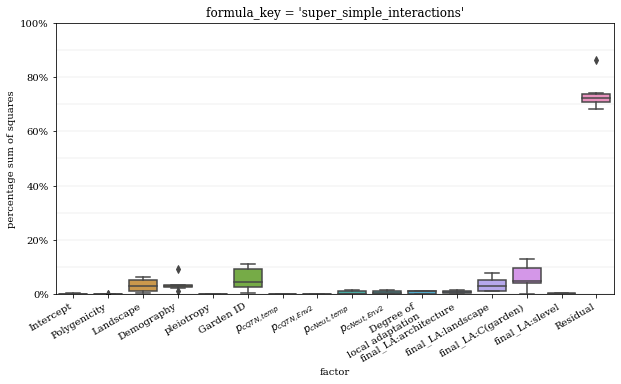

Intercept  glevel  landscape  demography  plevel_pleio  \
RONA-sal_opt         0.01    0.04       1.91        3.50          0.01   
RONA-temp_opt        0.35    0.03       0.42        1.26          0.01   
lfmm2                0.13    0.01       5.73        3.21          0.00   
GF                   0.00    0.03       4.45        3.12          0.01   
rda-nocorr           0.00    0.03       6.41        2.48          0.01   
rda-structcorr       0.54    0.16       0.82        9.43          0.00   

                C(garden)  cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt        11.09          0.00         0.00                   0.00   
RONA-temp_opt       10.11          0.02         0.00                   0.16   
lfmm2                6.50          0.02         0.03                   0.40   
GF                   2.91          0.12         0.01                   1.60   
rda-nocorr           2.59          0.15         0.02                   1.69   
rda-structcorr       0.32          0.10         0.00                   0.01   

                cor_FPR_sal_neutSNPs  final_LA  final_LA:architecture  \
RONA-sal_opt                    0.11      0.00                   0.31   
RONA-temp_opt                   0.00      0.95                   0.85   
lfmm2                           0.03      1.24                   1.07   
GF                              1.52      1.37                   1.62   
rda-nocorr                      1.19      1.26                   1.21   
rda-structcorr                  0.77      0.02                   0.38   

                final_LA:landscape  final_LA:C(garden)  final_LA:slevel  \
RONA-sal_opt                  1.07               11.22             0.14   
RONA-temp_opt                 1.64               12.94             0.20   
lfmm2                         7.86                5.19             0.38   
GF                            4.36                4.57             0.41   
rda-nocorr                    5.53                3.87             0.22   
rda-structcorr                1.06                0.20             0.02   

                Residual  
RONA-sal_opt       70.59  
RONA-temp_opt      71.05  
lfmm2              68.19  
GF                 73.90  
rda-nocorr         73.34  
rda-structcorr     86.17

factor         program   perc
0   Intercept    RONA-sal_opt   0.01
1   Intercept   RONA-temp_opt   0.35
2   Intercept           lfmm2   0.13
3   Intercept              GF   0.00
4   Intercept      rda-nocorr   0.00
..        ...             ...    ...
91   Residual   RONA-temp_opt  71.05
92   Residual           lfmm2  68.19
93   Residual              GF  73.90
94   Residual      rda-nocorr  73.34
95   Residual  rda-structcorr  86.17

[96 rows x 3 columns]

In [25]:
formula_key = 'super_simple_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

<a id='ss_evo_anova_sos'></a>
### super simple evo (excludes slevel)

[top](#home)



percentage sum of squares (super_simple_evo factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_super_simple_evo.pdf


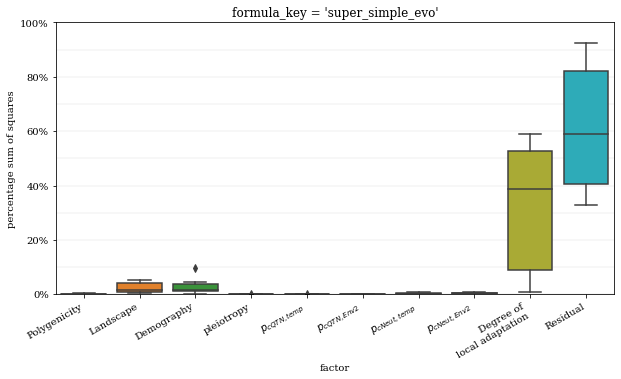

glevel  landscape  demography  plevel_pleio  cor_TPR_temp  \
RONA-sal_opt      0.17       1.59        4.60          0.00          0.01   
RONA-temp_opt     0.03       0.64        0.23          0.01          0.01   
lfmm2             0.01       1.34        1.45          0.00          0.06   
GF                0.05       5.24        1.59          0.01          0.05   
rda-nocorr        0.04       5.17        1.28          0.00          0.07   
rda-structcorr    0.29       0.81        9.54          0.04          0.20   

                cor_TPR_sal  cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  \
RONA-sal_opt           0.04                   0.01                  0.16   
RONA-temp_opt          0.00                   0.02                  0.00   
lfmm2                  0.03                   0.35                  0.00   
GF                     0.01                   0.71                  0.57   
rda-nocorr             0.02                   0.84                  0.58   
rda-structcorr         0.00                   0.03                  0.67   

                final_LA  Residual  
RONA-sal_opt        0.93     92.50  
RONA-temp_opt      31.35     67.71  
lfmm2              46.37     50.38  
GF                 59.02     32.76  
rda-nocorr         54.83     37.17  
rda-structcorr      1.26     87.16

factor         program   perc
0                  glevel    RONA-sal_opt   0.17
1                  glevel   RONA-temp_opt   0.03
2                  glevel           lfmm2   0.01
3                  glevel              GF   0.05
4                  glevel      rda-nocorr   0.04
5                  glevel  rda-structcorr   0.29
6               landscape    RONA-sal_opt   1.59
7               landscape   RONA-temp_opt   0.64
8               landscape           lfmm2   1.34
9               landscape              GF   5.24
10              landscape      rda-nocorr   5.17
11              landscape  rda-structcorr   0.81
12             demography    RONA-sal_opt   4.60
13             demography   RONA-temp_opt   0.23
14             demography           lfmm2   1.45
15             demography              GF   1.59
16             demography      rda-nocorr   1.28
17             demography  rda-structcorr   9.54
18           plevel_pleio    RONA-sal_opt   0.00
19           plevel_pleio   RONA-temp_opt   0.01
20           plevel_pleio           lfmm2   0.00
21           plevel_pleio              GF   0.01
22           plevel_pleio      rda-nocorr   0.00
23           plevel_pleio  rda-structcorr   0.04
24           cor_TPR_temp    RONA-sal_opt   0.01
25           cor_TPR_temp   RONA-temp_opt   0.01
26           cor_TPR_temp           lfmm2   0.06
27           cor_TPR_temp              GF   0.05
28           cor_TPR_temp      rda-nocorr   0.07
29           cor_TPR_temp  rda-structcorr   0.20
30            cor_TPR_sal    RONA-sal_opt   0.04
31            cor_TPR_sal   RONA-temp_opt   0.00
32            cor_TPR_sal           lfmm2   0.03
33            cor_TPR_sal              GF   0.01
34            cor_TPR_sal      rda-nocorr   0.02
35            cor_TPR_sal  rda-structcorr   0.00
36  cor_FPR_temp_neutSNPs    RONA-sal_opt   0.01
37  cor_FPR_temp_neutSNPs   RONA-temp_opt   0.02
38  cor_FPR_temp_neutSNPs           lfmm2   0.35
39  cor_FPR_temp_neutSNPs              GF   0.71
40  cor_FPR_temp_neutSNPs      rda-nocorr   0.84
41  cor_FPR_temp_neutSNPs  rda-structcorr   0.03
42   cor_FPR_sal_neutSNPs    RONA-sal_opt   0.16
43   cor_FPR_sal_neutSNPs   RONA-temp_opt   0.00
44   cor_FPR_sal_neutSNPs           lfmm2   0.00
45   cor_FPR_sal_neutSNPs              GF   0.57
46   cor_FPR_sal_neutSNPs      rda-nocorr   0.58
47   cor_FPR_sal_neutSNPs  rda-structcorr   0.67
48               final_LA    RONA-sal_opt   0.93
49               final_LA   RONA-temp_opt  31.35
50               final_LA           lfmm2  46.37
51               final_LA              GF  59.02
52               final_LA      rda-nocorr  54.83
53               final_LA  rda-structcorr   1.26
54               Residual    RONA-sal_opt  92.50
55               Residual   RONA-temp_opt  67.71
56               Residual           lfmm2  50.38
57               Residual              GF  32.76
58               Residual      rda-nocorr  37.17
59               Residual  rda-structcorr  87.16

In [26]:
formula_key = 'super_simple_evo'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (super_simple_evo_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_super_simple_evo_interactions.pdf


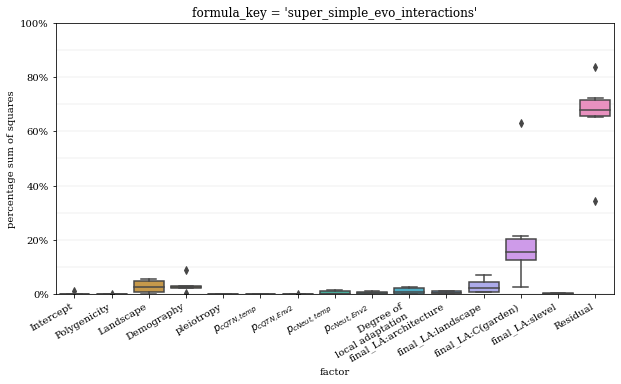

Intercept  glevel  landscape  demography  plevel_pleio  \
RONA-sal_opt         0.00    0.04       1.69        3.10          0.01   
RONA-temp_opt        0.09    0.01       0.18        0.54          0.00   
lfmm2                0.00    0.01       5.30        2.97          0.00   
GF                   0.09    0.02       3.79        2.66          0.01   
rda-nocorr           0.03    0.03       5.63        2.18          0.01   
rda-structcorr       1.18    0.16       0.79        9.13          0.00   

                cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt            0.00         0.00                   0.00   
RONA-temp_opt           0.01         0.00                   0.07   
lfmm2                   0.02         0.02                   0.37   
GF                      0.10         0.00                   1.36   
rda-nocorr              0.13         0.01                   1.48   
rda-structcorr          0.10         0.00                   0.01   

                cor_FPR_sal_neutSNPs  final_LA  final_LA:architecture  \
RONA-sal_opt                    0.10      0.04                   0.28   
RONA-temp_opt                   0.00      0.52                   0.36   
lfmm2                           0.03      1.50                   0.99   
GF                              1.29      2.57                   1.38   
rda-nocorr                      1.04      2.37                   1.07   
rda-structcorr                  0.75      0.02                   0.36   

                final_LA:landscape  final_LA:C(garden)  final_LA:slevel  \
RONA-sal_opt                  0.95               21.29             0.12   
RONA-temp_opt                 0.70               62.91             0.08   
lfmm2                         7.27               12.07             0.35   
GF                            3.71               17.24             0.35   
rda-nocorr                    4.86               14.27             0.20   
rda-structcorr                1.02                2.66             0.02   

                Residual  
RONA-sal_opt       72.39  
RONA-temp_opt      34.52  
lfmm2              69.09  
GF                 65.43  
rda-nocorr         66.70  
rda-structcorr     83.78

factor         program   perc
0   Intercept    RONA-sal_opt   0.00
1   Intercept   RONA-temp_opt   0.09
2   Intercept           lfmm2   0.00
3   Intercept              GF   0.09
4   Intercept      rda-nocorr   0.03
..        ...             ...    ...
85   Residual   RONA-temp_opt  34.52
86   Residual           lfmm2  69.09
87   Residual              GF  65.43
88   Residual      rda-nocorr  66.70
89   Residual  rda-structcorr  83.78

[90 rows x 3 columns]

In [27]:
formula_key = 'super_simple_evo_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

<a id='simp_anova_sos'></a>
### simple factors
    
[top](#home)

In [28]:
formula_key = 'simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (simple factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_simple.pdf


glevel  landscape  demography  plevel_pleio  slevel  \
RONA-sal_opt      0.05       1.30        3.62          0.00    0.15   
RONA-temp_opt     0.00       0.54        0.40          0.01    0.08   
lfmm2             0.00       1.98        2.81          0.00    0.19   
GF                0.00      10.96        2.74          0.00    0.49   
rda-nocorr        0.01      10.05        2.16          0.01    0.32   
rda-structcorr    0.67       0.39       10.35          0.00    0.84   

                C(garden)  cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt        21.12          0.00         0.02                   0.00   
RONA-temp_opt       61.71          0.02         0.00                   0.04   
lfmm2               13.87          0.14         0.08                   0.59   
GF                  14.81          0.15         0.05                   1.59   
rda-nocorr          12.59          0.18         0.09                   1.73   
rda-structcorr       2.73          0.16         0.01                   0.06   

                cor_FPR_sal_neutSNPs  final_LA  Residual  
RONA-sal_opt                    0.16      0.05     73.52  
RONA-temp_opt                   0.00      0.72     36.49  
lfmm2                           0.00      1.25     79.10  
GF                              1.43      1.78     65.99  
rda-nocorr                      1.30      1.66     69.91  
rda-structcorr                  0.66      0.51     83.62

factor         program   perc
0     glevel    RONA-sal_opt   0.05
1     glevel   RONA-temp_opt   0.00
2     glevel           lfmm2   0.00
3     glevel              GF   0.00
4     glevel      rda-nocorr   0.01
..       ...             ...    ...
67  Residual   RONA-temp_opt  36.49
68  Residual           lfmm2  79.10
69  Residual              GF  65.99
70  Residual      rda-nocorr  69.91
71  Residual  rda-structcorr  83.62

[72 rows x 3 columns]

percentage sum of squares (simple_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_simple_interactions.pdf


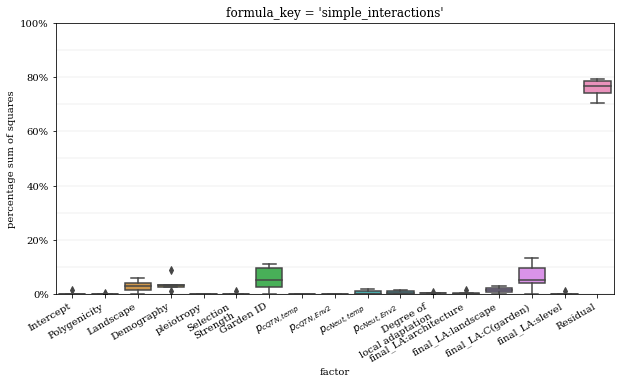

Intercept  glevel  landscape  demography  plevel_pleio  \
RONA-sal_opt         0.11    0.07       1.66        3.60          0.00   
RONA-temp_opt        0.07    0.05       0.11        1.33          0.00   
lfmm2                0.02    0.00       4.36        3.55          0.00   
GF                   0.05    0.04       3.86        3.25          0.01   
rda-nocorr           0.01    0.04       5.85        2.58          0.00   
rda-structcorr       1.71    0.33       1.94        9.07          0.01   

                slevel  C(garden)  cor_TPR_temp  cor_TPR_sal  \
RONA-sal_opt      0.13      11.09          0.00         0.00   
RONA-temp_opt     0.04      10.48          0.02         0.00   
lfmm2             0.03       7.15          0.03         0.03   
GF                0.06       3.13          0.13         0.01   
rda-nocorr        0.04       2.76          0.16         0.02   
rda-structcorr    1.27       0.30          0.09         0.00   

                cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  final_LA  \
RONA-sal_opt                     0.00                  0.12      0.07   
RONA-temp_opt                    0.17                  0.00      0.29   
lfmm2                            0.44                  0.03      0.46   
GF                               1.71                  1.65      0.42   
rda-nocorr                       1.79                  1.28      0.43   
rda-structcorr                   0.01                  0.66      0.83   

                final_LA:architecture  final_LA:landscape  final_LA:C(garden)  \
RONA-sal_opt                     0.28                0.98               11.22   
RONA-temp_opt                    0.12                0.23               13.43   
lfmm2                            0.11                3.09                5.71   
GF                               0.28                1.19                4.91   
rda-nocorr                       0.39                2.40                4.13   
rda-structcorr                   1.50                2.25                0.18   

                final_LA:slevel  Residual  
RONA-sal_opt               0.21     70.45  
RONA-temp_opt              0.00     73.65  
lfmm2                      0.00     74.98  
GF                         0.00     79.30  
rda-nocorr                 0.00     78.12  
rda-structcorr             1.23     78.61

factor         program   perc
0    Intercept    RONA-sal_opt   0.11
1    Intercept   RONA-temp_opt   0.07
2    Intercept           lfmm2   0.02
3    Intercept              GF   0.05
4    Intercept      rda-nocorr   0.01
..         ...             ...    ...
97    Residual   RONA-temp_opt  73.65
98    Residual           lfmm2  74.98
99    Residual              GF  79.30
100   Residual      rda-nocorr  78.12
101   Residual  rda-structcorr  78.61

[102 rows x 3 columns]

In [29]:
formula_key = 'simple_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

<a id='simp_evo_anova_sos'></a>
### simple evo factors
    
[top](#home)

percentage sum of squares (simple_evo factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_simple_evo.pdf


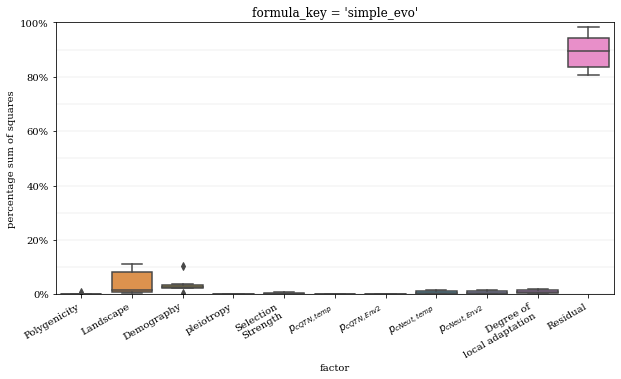

glevel  landscape  demography  plevel_pleio  slevel  \
RONA-sal_opt      0.05       1.30        3.62          0.00    0.15   
RONA-temp_opt     0.00       0.54        0.40          0.01    0.08   
lfmm2             0.00       1.98        2.81          0.00    0.19   
GF                0.00      10.96        2.74          0.00    0.49   
rda-nocorr        0.01      10.05        2.16          0.01    0.32   
rda-structcorr    0.67       0.39       10.35          0.00    0.84   

                cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt            0.00         0.02                   0.00   
RONA-temp_opt           0.02         0.00                   0.04   
lfmm2                   0.14         0.08                   0.59   
GF                      0.15         0.05                   1.59   
rda-nocorr              0.18         0.09                   1.73   
rda-structcorr          0.16         0.01                   0.06   

                cor_FPR_sal_neutSNPs  final_LA  Residual  
RONA-sal_opt                    0.16      0.05     94.64  
RONA-temp_opt                   0.00      0.72     98.20  
lfmm2                           0.00      1.25     92.96  
GF                              1.43      1.78     80.80  
rda-nocorr                      1.30      1.66     82.50  
rda-structcorr                  0.66      0.51     86.35

factor         program   perc
0     glevel    RONA-sal_opt   0.05
1     glevel   RONA-temp_opt   0.00
2     glevel           lfmm2   0.00
3     glevel              GF   0.00
4     glevel      rda-nocorr   0.01
..       ...             ...    ...
61  Residual   RONA-temp_opt  98.20
62  Residual           lfmm2  92.96
63  Residual              GF  80.80
64  Residual      rda-nocorr  82.50
65  Residual  rda-structcorr  86.35

[66 rows x 3 columns]

In [30]:
formula_key = 'simple_evo'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

In [31]:
formula_key = 'simple_evo_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (simple_evo_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_simple_evo_interactions.pdf


Intercept  glevel  landscape  demography  plevel_pleio  \
RONA-sal_opt         0.09    0.06       1.47        3.19          0.00   
RONA-temp_opt        0.00    0.02       0.05        0.56          0.00   
lfmm2                0.02    0.00       4.02        3.28          0.00   
GF                   0.13    0.03       3.30        2.78          0.01   
rda-nocorr           0.06    0.03       5.17        2.28          0.00   
rda-structcorr       2.21    0.32       1.88        8.78          0.01   

                slevel  cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt      0.12          0.00         0.00                   0.00   
RONA-temp_opt     0.02          0.01         0.00                   0.07   
lfmm2             0.03          0.02         0.03                   0.41   
GF                0.05          0.11         0.01                   1.46   
rda-nocorr        0.03          0.14         0.01                   1.58   
rda-structcorr    1.23          0.09         0.00                   0.01   

                cor_FPR_sal_neutSNPs  final_LA  final_LA:architecture  \
RONA-sal_opt                    0.10      0.04                   0.25   
RONA-temp_opt                   0.00      0.06                   0.05   
lfmm2                           0.03      0.24                   0.10   
GF                              1.41      0.38                   0.24   
rda-nocorr                      1.13      0.39                   0.35   
rda-structcorr                  0.64      1.08                   1.46   

                final_LA:landscape  final_LA:C(garden)  final_LA:slevel  \
RONA-sal_opt                  0.87               21.30             0.19   
RONA-temp_opt                 0.10               63.98             0.00   
lfmm2                         2.85               13.24             0.00   
GF                            1.02               18.58             0.00   
rda-nocorr                    2.12               15.29             0.00   
rda-structcorr                2.18                2.47             1.19   

                Residual  
RONA-sal_opt       72.31  
RONA-temp_opt      35.09  
lfmm2              75.74  
GF                 70.49  
rda-nocorr         71.42  
rda-structcorr     76.44

factor         program   perc
0   Intercept    RONA-sal_opt   0.09
1   Intercept   RONA-temp_opt   0.00
2   Intercept           lfmm2   0.02
3   Intercept              GF   0.13
4   Intercept      rda-nocorr   0.06
..        ...             ...    ...
91   Residual   RONA-temp_opt  35.09
92   Residual           lfmm2  75.74
93   Residual              GF  70.49
94   Residual      rda-nocorr  71.42
95   Residual  rda-structcorr  76.44

[96 rows x 3 columns]

<a id='comb_anova_sos'></a>
### combined factors

[top](#home)

percentage sum of squares (combined factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_combined.pdf


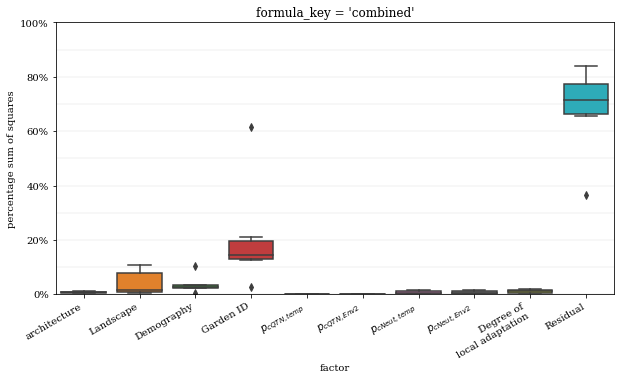

architecture  landscape  demography  C(garden)  cor_TPR_temp  \
RONA-sal_opt            0.39       1.19        3.51      21.13          0.00   
RONA-temp_opt           0.25       0.57        0.38      61.62          0.01   
lfmm2                   0.47       1.96        2.79      13.85          0.15   
GF                      0.97      10.88        2.73      14.77          0.17   
rda-nocorr              0.84       9.98        2.14      12.57          0.23   
rda-structcorr          1.29       0.41       10.27       2.74          0.20   

                cor_TPR_sal  cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  \
RONA-sal_opt           0.03                   0.00                  0.16   
RONA-temp_opt          0.01                   0.03                  0.00   
lfmm2                  0.13                   0.58                  0.00   
GF                     0.09                   1.56                  1.42   
rda-nocorr             0.14                   1.67                  1.30   
rda-structcorr         0.02                   0.05                  0.67   

                final_LA  Residual  
RONA-sal_opt        0.07     73.52  
RONA-temp_opt       0.78     36.35  
lfmm2               1.34     78.74  
GF                  1.89     65.52  
rda-nocorr          1.75     69.39  
rda-structcorr      0.42     83.93

factor         program   perc
0            architecture    RONA-sal_opt   0.39
1            architecture   RONA-temp_opt   0.25
2            architecture           lfmm2   0.47
3            architecture              GF   0.97
4            architecture      rda-nocorr   0.84
5            architecture  rda-structcorr   1.29
6               landscape    RONA-sal_opt   1.19
7               landscape   RONA-temp_opt   0.57
8               landscape           lfmm2   1.96
9               landscape              GF  10.88
10              landscape      rda-nocorr   9.98
11              landscape  rda-structcorr   0.41
12             demography    RONA-sal_opt   3.51
13             demography   RONA-temp_opt   0.38
14             demography           lfmm2   2.79
15             demography              GF   2.73
16             demography      rda-nocorr   2.14
17             demography  rda-structcorr  10.27
18              C(garden)    RONA-sal_opt  21.13
19              C(garden)   RONA-temp_opt  61.62
20              C(garden)           lfmm2  13.85
21              C(garden)              GF  14.77
22              C(garden)      rda-nocorr  12.57
23              C(garden)  rda-structcorr   2.74
24           cor_TPR_temp    RONA-sal_opt   0.00
25           cor_TPR_temp   RONA-temp_opt   0.01
26           cor_TPR_temp           lfmm2   0.15
27           cor_TPR_temp              GF   0.17
28           cor_TPR_temp      rda-nocorr   0.23
29           cor_TPR_temp  rda-structcorr   0.20
30            cor_TPR_sal    RONA-sal_opt   0.03
31            cor_TPR_sal   RONA-temp_opt   0.01
32            cor_TPR_sal           lfmm2   0.13
33            cor_TPR_sal              GF   0.09
34            cor_TPR_sal      rda-nocorr   0.14
35            cor_TPR_sal  rda-structcorr   0.02
36  cor_FPR_temp_neutSNPs    RONA-sal_opt   0.00
37  cor_FPR_temp_neutSNPs   RONA-temp_opt   0.03
38  cor_FPR_temp_neutSNPs           lfmm2   0.58
39  cor_FPR_temp_neutSNPs              GF   1.56
40  cor_FPR_temp_neutSNPs      rda-nocorr   1.67
41  cor_FPR_temp_neutSNPs  rda-structcorr   0.05
42   cor_FPR_sal_neutSNPs    RONA-sal_opt   0.16
43   cor_FPR_sal_neutSNPs   RONA-temp_opt   0.00
44   cor_FPR_sal_neutSNPs           lfmm2   0.00
45   cor_FPR_sal_neutSNPs              GF   1.42
46   cor_FPR_sal_neutSNPs      rda-nocorr   1.30
47   cor_FPR_sal_neutSNPs  rda-structcorr   0.67
48               final_LA    RONA-sal_opt   0.07
49               final_LA   RONA-temp_opt   0.78
50               final_LA           lfmm2   1.34
51               final_LA              GF   1.89
52               final_LA      rda-nocorr   1.75
53               final_LA  rda-structcorr   0.42
54               Residual    RONA-sal_opt  73.52
55               Residual   RONA-temp_opt  36.35
56               Residual           lfmm2  78.74
57               Residual              GF  65.52
58               Residual      rda-nocorr  69.39
59               Residual  rda-structcorr  83.93

In [32]:
formula_key = 'combined'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (combined_interactions factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_combined_interactions.pdf


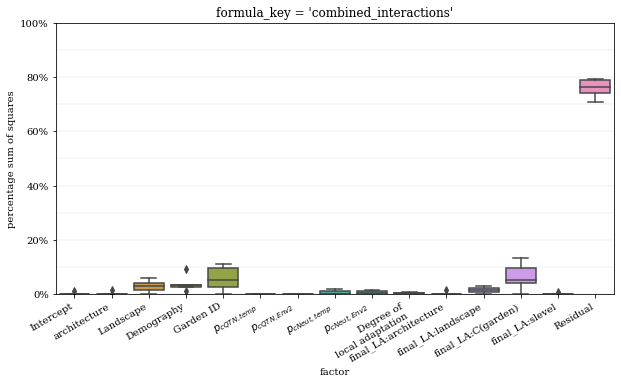

Intercept  architecture  landscape  demography  C(garden)  \
RONA-sal_opt         0.08          0.19       1.67        3.58      11.12   
RONA-temp_opt        0.05          0.13       0.13        1.31      10.49   
lfmm2                0.05          0.18       4.44        3.53       7.13   
GF                   0.02          0.18       3.92        3.29       3.13   
rda-nocorr           0.00          0.19       5.93        2.62       2.77   
rda-structcorr       1.28          1.65       2.05        9.20       0.30   

                cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt            0.00         0.00                   0.00   
RONA-temp_opt           0.02         0.01                   0.17   
lfmm2                   0.02         0.02                   0.45   
GF                      0.12         0.00                   1.72   
rda-nocorr              0.15         0.01                   1.81   
rda-structcorr          0.09         0.00                   0.01   

                cor_FPR_sal_neutSNPs  final_LA  final_LA:architecture  \
RONA-sal_opt                    0.12      0.05                   0.25   
RONA-temp_opt                   0.00      0.21                   0.08   
lfmm2                           0.03      0.47                   0.15   
GF                              1.64      0.36                   0.12   
rda-nocorr                      1.26      0.38                   0.15   
rda-structcorr                  0.65      0.68                   1.52   

                final_LA:landscape  final_LA:C(garden)  final_LA:slevel  \
RONA-sal_opt                  0.97               11.24             0.13   
RONA-temp_opt                 0.25               13.44             0.00   
lfmm2                         3.13                5.70             0.03   
GF                            1.22                4.91             0.00   
rda-nocorr                    2.44                4.14             0.00   
rda-structcorr                2.34                0.19             0.90   

                Residual  
RONA-sal_opt       70.59  
RONA-temp_opt      73.69  
lfmm2              74.65  
GF                 79.36  
rda-nocorr         78.15  
rda-structcorr     79.15

factor         program   perc
0   Intercept    RONA-sal_opt   0.08
1   Intercept   RONA-temp_opt   0.05
2   Intercept           lfmm2   0.05
3   Intercept              GF   0.02
4   Intercept      rda-nocorr   0.00
..        ...             ...    ...
85   Residual   RONA-temp_opt  73.69
86   Residual           lfmm2  74.65
87   Residual              GF  79.36
88   Residual      rda-nocorr  78.15
89   Residual  rda-structcorr  79.15

[90 rows x 3 columns]

In [33]:
formula_key = 'combined_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

<a id='sanity_anova_sos'></a>
### sanity check

look for confounding between local adaptation and 'combined' architecture

[top](#home)

percentage sum of squares (withLA_woArch factors)
score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_withLA_woArch.pdf


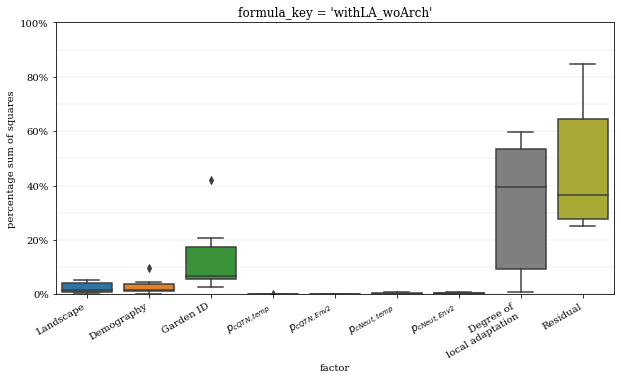

landscape  demography  C(garden)  cor_TPR_temp  cor_TPR_sal  \
RONA-sal_opt         1.80        4.48      20.60          0.04         0.00   
RONA-temp_opt        0.62        0.24      42.12          0.01         0.01   
lfmm2                1.33        1.44       7.39          0.08         0.06   
GF                   5.16        1.54       5.87          0.06         0.05   
rda-nocorr           5.11        1.24       5.57          0.06         0.09   
rda-structcorr       0.72        9.53       2.73          0.07         0.09   

                cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  final_LA  \
RONA-sal_opt                     0.00                  0.16      0.85   
RONA-temp_opt                    0.02                  0.00     31.96   
lfmm2                            0.34                  0.00     47.11   
GF                               0.67                  0.56     59.68   
rda-nocorr                       0.80                  0.56     55.46   
rda-structcorr                   0.02                  0.65      1.52   

                Residual  
RONA-sal_opt       72.06  
RONA-temp_opt      25.01  
lfmm2              42.25  
GF                 26.42  
rda-nocorr         31.10  
rda-structcorr     84.67

factor         program   perc
0               landscape    RONA-sal_opt   1.80
1               landscape   RONA-temp_opt   0.62
2               landscape           lfmm2   1.33
3               landscape              GF   5.16
4               landscape      rda-nocorr   5.11
5               landscape  rda-structcorr   0.72
6              demography    RONA-sal_opt   4.48
7              demography   RONA-temp_opt   0.24
8              demography           lfmm2   1.44
9              demography              GF   1.54
10             demography      rda-nocorr   1.24
11             demography  rda-structcorr   9.53
12              C(garden)    RONA-sal_opt  20.60
13              C(garden)   RONA-temp_opt  42.12
14              C(garden)           lfmm2   7.39
15              C(garden)              GF   5.87
16              C(garden)      rda-nocorr   5.57
17              C(garden)  rda-structcorr   2.73
18           cor_TPR_temp    RONA-sal_opt   0.04
19           cor_TPR_temp   RONA-temp_opt   0.01
20           cor_TPR_temp           lfmm2   0.08
21           cor_TPR_temp              GF   0.06
22           cor_TPR_temp      rda-nocorr   0.06
23           cor_TPR_temp  rda-structcorr   0.07
24            cor_TPR_sal    RONA-sal_opt   0.00
25            cor_TPR_sal   RONA-temp_opt   0.01
26            cor_TPR_sal           lfmm2   0.06
27            cor_TPR_sal              GF   0.05
28            cor_TPR_sal      rda-nocorr   0.09
29            cor_TPR_sal  rda-structcorr   0.09
30  cor_FPR_temp_neutSNPs    RONA-sal_opt   0.00
31  cor_FPR_temp_neutSNPs   RONA-temp_opt   0.02
32  cor_FPR_temp_neutSNPs           lfmm2   0.34
33  cor_FPR_temp_neutSNPs              GF   0.67
34  cor_FPR_temp_neutSNPs      rda-nocorr   0.80
35  cor_FPR_temp_neutSNPs  rda-structcorr   0.02
36   cor_FPR_sal_neutSNPs    RONA-sal_opt   0.16
37   cor_FPR_sal_neutSNPs   RONA-temp_opt   0.00
38   cor_FPR_sal_neutSNPs           lfmm2   0.00
39   cor_FPR_sal_neutSNPs              GF   0.56
40   cor_FPR_sal_neutSNPs      rda-nocorr   0.56
41   cor_FPR_sal_neutSNPs  rda-structcorr   0.65
42               final_LA    RONA-sal_opt   0.85
43               final_LA   RONA-temp_opt  31.96
44               final_LA           lfmm2  47.11
45               final_LA              GF  59.68
46               final_LA      rda-nocorr  55.46
47               final_LA  rda-structcorr   1.52
48               Residual    RONA-sal_opt  72.06
49               Residual   RONA-temp_opt  25.01
50               Residual           lfmm2  42.25
51               Residual              GF  26.42
52               Residual      rda-nocorr  31.10
53               Residual  rda-structcorr  84.67

In [34]:
formula_key = 'withLA_woArch'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (withLA_woArch_interactions factors)
score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_withLA_woArch_interactions.pdf


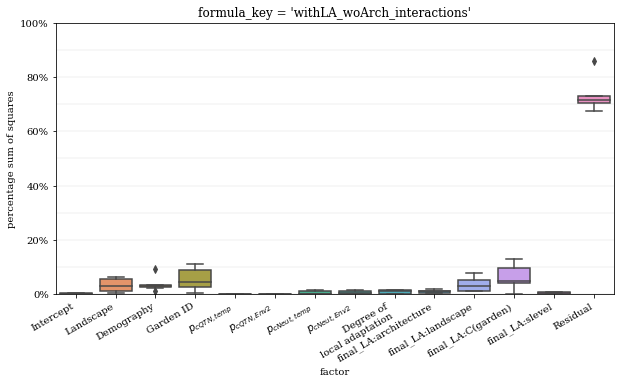

Intercept  landscape  demography  C(garden)  cor_TPR_temp  \
RONA-sal_opt         0.00       1.87        3.48      11.06          0.00   
RONA-temp_opt        0.48       0.38        1.23      10.03          0.01   
lfmm2                0.14       5.92        3.18       6.44          0.03   
GF                   0.00       4.39        3.07       2.88          0.11   
rda-nocorr           0.01       6.37        2.44       2.57          0.14   
rda-structcorr       0.43       1.00        9.48       0.32          0.18   

                cor_TPR_sal  cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  \
RONA-sal_opt           0.02                   0.00                  0.10   
RONA-temp_opt          0.00                   0.15                  0.00   
lfmm2                  0.02                   0.40                  0.03   
GF                     0.02                   1.63                  1.48   
rda-nocorr             0.04                   1.72                  1.16   
rda-structcorr         0.05                   0.00                  0.81   

                final_LA  final_LA:architecture  final_LA:landscape  \
RONA-sal_opt        0.00                   0.50                1.07   
RONA-temp_opt       1.19                   1.02                1.60   
lfmm2               1.35                   1.09                7.95   
GF                  1.65                   1.79                4.32   
rda-nocorr          1.53                   1.30                5.50   
rda-structcorr      0.00                   0.48                1.20   

                final_LA:C(garden)  final_LA:slevel  Residual  
RONA-sal_opt                 11.19             0.25     70.45  
RONA-temp_opt                12.85             0.49     70.57  
lfmm2                         5.14             0.78     67.53  
GF                            4.52             0.99     73.13  
rda-nocorr                    3.84             0.61     72.76  
rda-structcorr                0.20             0.00     85.87

factor         program   perc
0   Intercept    RONA-sal_opt   0.00
1   Intercept   RONA-temp_opt   0.48
2   Intercept           lfmm2   0.14
3   Intercept              GF   0.00
4   Intercept      rda-nocorr   0.01
..        ...             ...    ...
79   Residual   RONA-temp_opt  70.57
80   Residual           lfmm2  67.53
81   Residual              GF  73.13
82   Residual      rda-nocorr  72.76
83   Residual  rda-structcorr  85.87

[84 rows x 3 columns]

In [35]:
formula_key = 'withLA_woArch_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

In [36]:
formula_key = 'woLA_withArch'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (woLA_withArch factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_woLA_withArch.pdf


architecture  landscape  demography  C(garden)  cor_TPR_temp  \
RONA-sal_opt            1.17       1.46        4.37      20.70          0.00   
RONA-temp_opt          31.60       0.17        0.63      42.12          0.02   
lfmm2                  46.60       0.96        1.97       7.38          0.13   
GF                     60.68       3.99        0.68       6.00          0.12   
rda-nocorr             56.06       4.11        0.65       5.67          0.16   
rda-structcorr          2.37       0.78        9.74       2.71          0.26   

                cor_TPR_sal  cor_FPR_temp_neutSNPs  cor_FPR_sal_neutSNPs  \
RONA-sal_opt           0.04                   0.01                  0.16   
RONA-temp_opt          0.01                   0.06                  0.00   
lfmm2                  0.08                   0.20                  0.00   
GF                     0.05                   0.48                  0.60   
rda-nocorr             0.07                   0.58                  0.61   
rda-structcorr         0.01                   0.02                  0.68   

                Residual  
RONA-sal_opt       72.10  
RONA-temp_opt      25.37  
lfmm2              42.67  
GF                 27.40  
rda-nocorr         32.09  
rda-structcorr     83.42

factor         program   perc
0            architecture    RONA-sal_opt   1.17
1            architecture   RONA-temp_opt  31.60
2            architecture           lfmm2  46.60
3            architecture              GF  60.68
4            architecture      rda-nocorr  56.06
5            architecture  rda-structcorr   2.37
6               landscape    RONA-sal_opt   1.46
7               landscape   RONA-temp_opt   0.17
8               landscape           lfmm2   0.96
9               landscape              GF   3.99
10              landscape      rda-nocorr   4.11
11              landscape  rda-structcorr   0.78
12             demography    RONA-sal_opt   4.37
13             demography   RONA-temp_opt   0.63
14             demography           lfmm2   1.97
15             demography              GF   0.68
16             demography      rda-nocorr   0.65
17             demography  rda-structcorr   9.74
18              C(garden)    RONA-sal_opt  20.70
19              C(garden)   RONA-temp_opt  42.12
20              C(garden)           lfmm2   7.38
21              C(garden)              GF   6.00
22              C(garden)      rda-nocorr   5.67
23              C(garden)  rda-structcorr   2.71
24           cor_TPR_temp    RONA-sal_opt   0.00
25           cor_TPR_temp   RONA-temp_opt   0.02
26           cor_TPR_temp           lfmm2   0.13
27           cor_TPR_temp              GF   0.12
28           cor_TPR_temp      rda-nocorr   0.16
29           cor_TPR_temp  rda-structcorr   0.26
30            cor_TPR_sal    RONA-sal_opt   0.04
31            cor_TPR_sal   RONA-temp_opt   0.01
32            cor_TPR_sal           lfmm2   0.08
33            cor_TPR_sal              GF   0.05
34            cor_TPR_sal      rda-nocorr   0.07
35            cor_TPR_sal  rda-structcorr   0.01
36  cor_FPR_temp_neutSNPs    RONA-sal_opt   0.01
37  cor_FPR_temp_neutSNPs   RONA-temp_opt   0.06
38  cor_FPR_temp_neutSNPs           lfmm2   0.20
39  cor_FPR_temp_neutSNPs              GF   0.48
40  cor_FPR_temp_neutSNPs      rda-nocorr   0.58
41  cor_FPR_temp_neutSNPs  rda-structcorr   0.02
42   cor_FPR_sal_neutSNPs    RONA-sal_opt   0.16
43   cor_FPR_sal_neutSNPs   RONA-temp_opt   0.00
44   cor_FPR_sal_neutSNPs           lfmm2   0.00
45   cor_FPR_sal_neutSNPs              GF   0.60
46   cor_FPR_sal_neutSNPs      rda-nocorr   0.61
47   cor_FPR_sal_neutSNPs  rda-structcorr   0.68
48               Residual    RONA-sal_opt  72.10
49               Residual   RONA-temp_opt  25.37
50               Residual           lfmm2  42.67
51               Residual              GF  27.40
52               Residual      rda-nocorr  32.09
53               Residual  rda-structcorr  83.42

In [37]:
formula_key = 'woLA_withArch_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (woLA_withArch_interactions factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_woLA_withArch_interactions.pdf


Intercept  architecture  landscape  demography  C(garden)  \
RONA-sal_opt         0.08          0.19       1.67        3.59      11.13   
RONA-temp_opt        0.05          0.13       0.13        1.30      10.39   
lfmm2                0.05          0.18       4.40        3.49       7.06   
GF                   0.02          0.18       3.87        3.24       3.09   
rda-nocorr           0.00          0.19       5.85        2.58       2.73   
rda-structcorr       1.30          1.68       2.08        9.34       0.30   

                cor_TPR_temp  cor_TPR_sal  cor_FPR_temp_neutSNPs  \
RONA-sal_opt            0.00         0.00                   0.00   
RONA-temp_opt           0.02         0.01                   0.17   
lfmm2                   0.02         0.02                   0.44   
GF                      0.12         0.00                   1.70   
rda-nocorr              0.15         0.01                   1.78   
rda-structcorr          0.09         0.00                   0.01   

                cor_FPR_sal_neutSNPs  final_LA:architecture  \
RONA-sal_opt                    0.12                   0.26   
RONA-temp_opt                   0.00                   0.77   
lfmm2                           0.03                   0.93   
GF                              1.62                   1.04   
rda-nocorr                      1.25                   1.08   
rda-structcorr                  0.66                   1.58   

                final_LA:landscape  final_LA:C(garden)  final_LA:slevel  \
RONA-sal_opt                  0.98               11.26             0.02   
RONA-temp_opt                 0.25               13.30             0.57   
lfmm2                         3.10                5.64             0.73   
GF                            1.21                4.85             0.79   
rda-nocorr                    2.41                4.08             0.80   
rda-structcorr                2.37                0.19             0.00   

                Residual  
RONA-sal_opt       70.70  
RONA-temp_opt      72.92  
lfmm2              73.90  
GF                 78.29  
rda-nocorr         77.09  
rda-structcorr     80.40

factor         program   perc
0   Intercept    RONA-sal_opt   0.08
1   Intercept   RONA-temp_opt   0.05
2   Intercept           lfmm2   0.05
3   Intercept              GF   0.02
4   Intercept      rda-nocorr   0.00
..        ...             ...    ...
79   Residual   RONA-temp_opt  72.92
80   Residual           lfmm2  73.90
81   Residual              GF  78.29
82   Residual      rda-nocorr  77.09
83   Residual  rda-structcorr  80.40

[84 rows x 3 columns]

<a id='vis'></a>
# 4. visualize rank of sum of squares
[top](#home)

In [38]:
def show_slope_graph(formula_key):
    """Create a slope graph, """
#     programs = [sums.name for sums in sos[formula_key]]
    colors = [(mvp.boxplot_kwargs['palette'][program], ) for program in programs]  # ( , ) create tuple with comma

    ax = slope_graph(*sos[formula_key],
                     labels=programs,
                     colors=colors,
                     figsize=(7, 8),
                     ascending=False,
                     all_yticks=True
                    )

#     ax.spines[:].set_visible(False)
    ax.set_ylabel('factor rank by sum of squares (first is greatest)\n')
    plt.title(f'{formula_key = }')

    plt.show()

    pass

super_simple_ibe


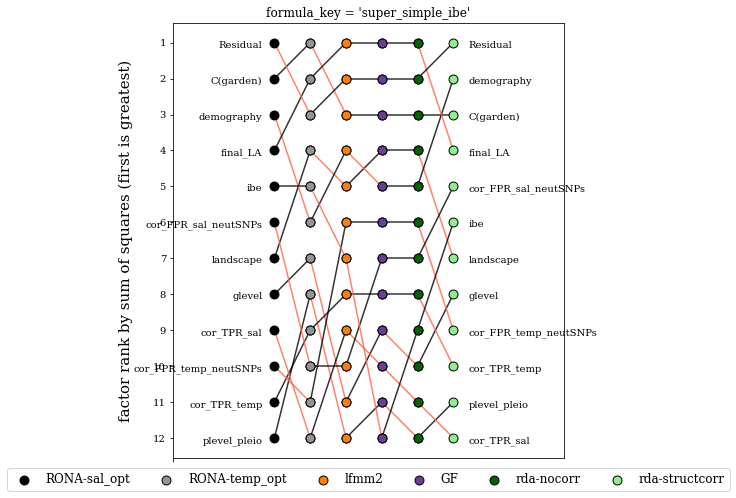




super_simple





super_simple_interactions


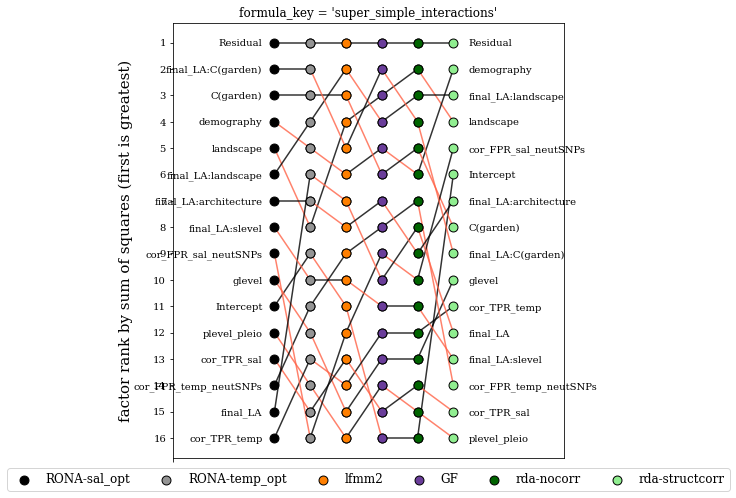




super_simple_evo





super_simple_evo_interactions


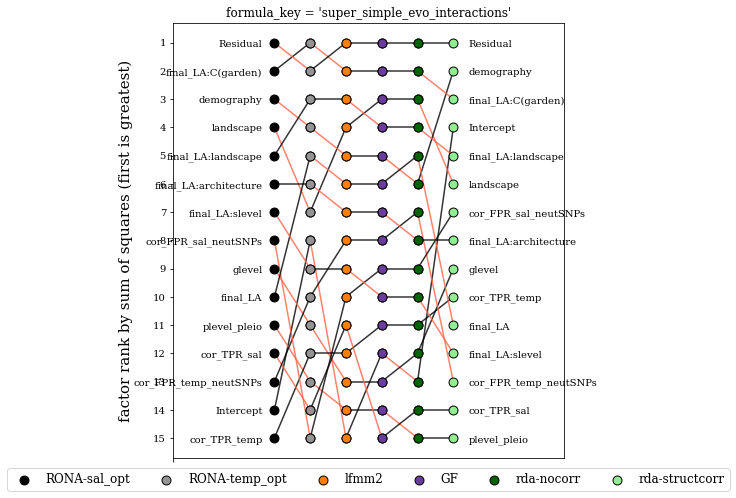




simple


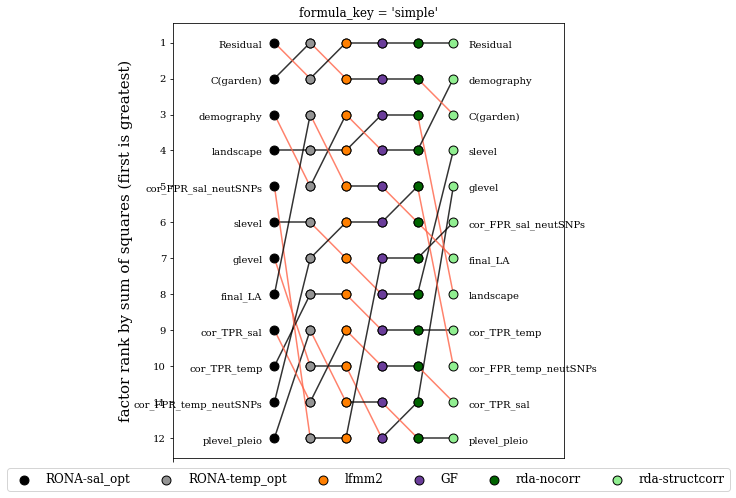




simple_interactions


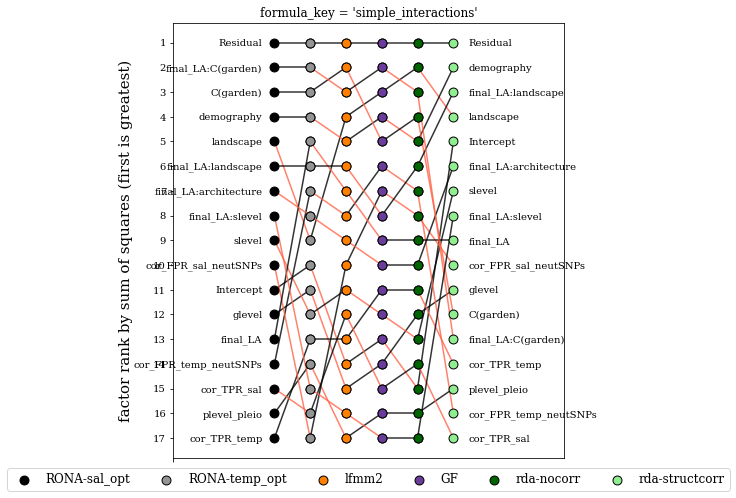




simple_evo


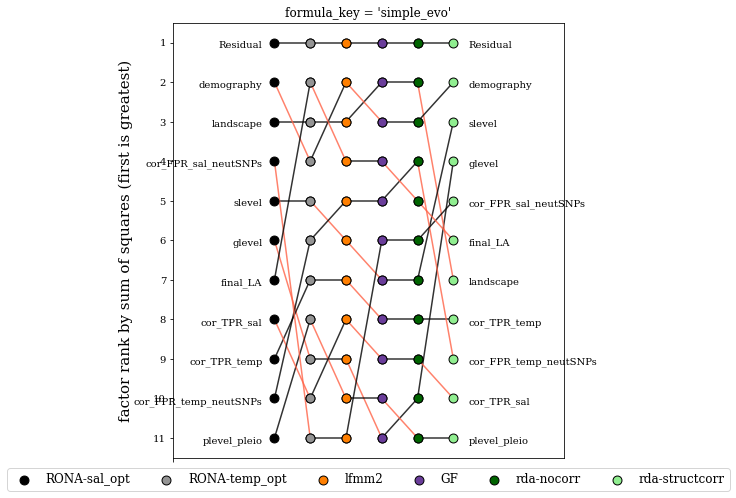




simple_evo_interactions


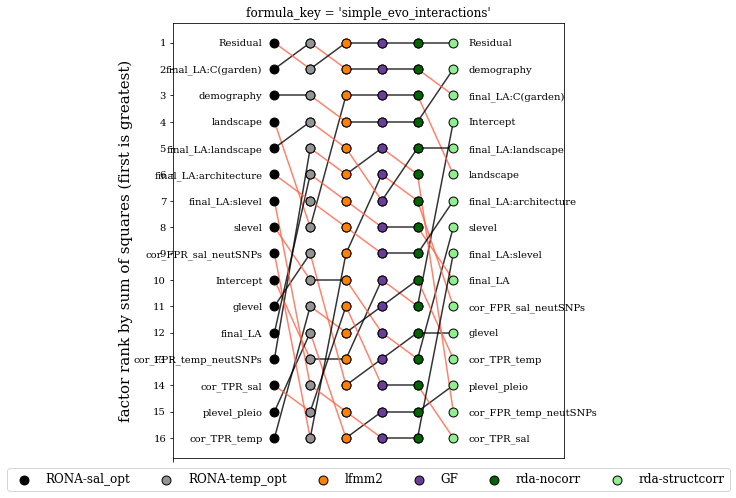




combined


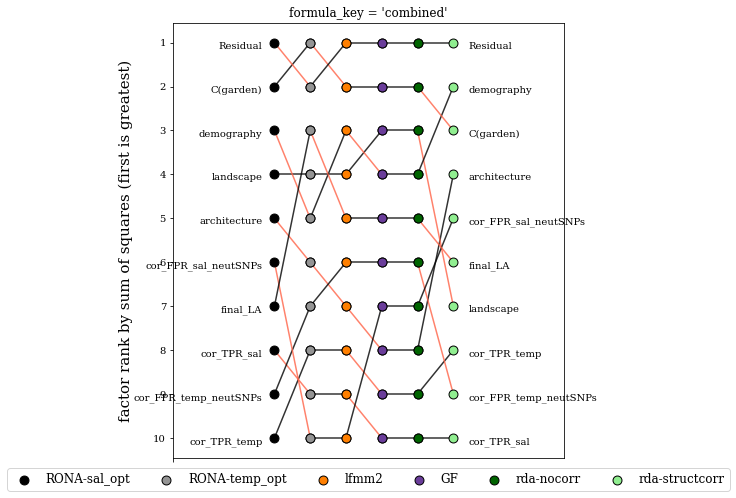




combined_interactions


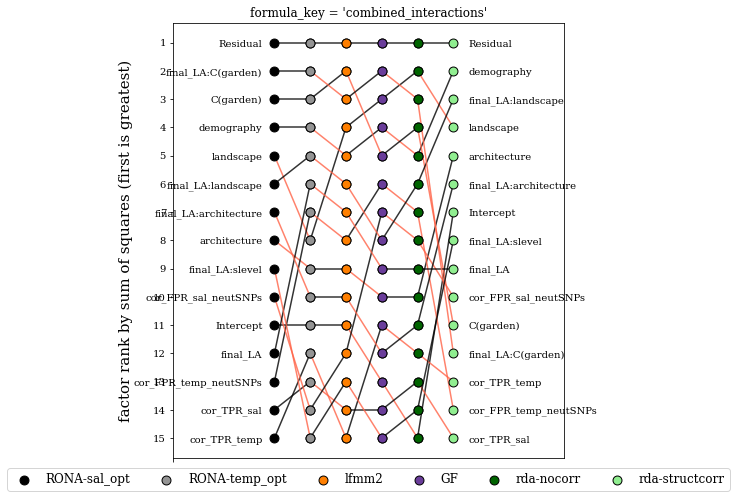




withLA_woArch


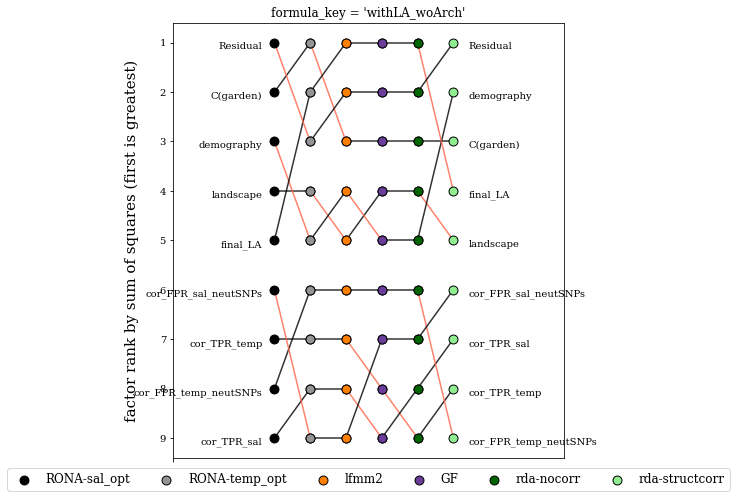




withLA_woArch_interactions


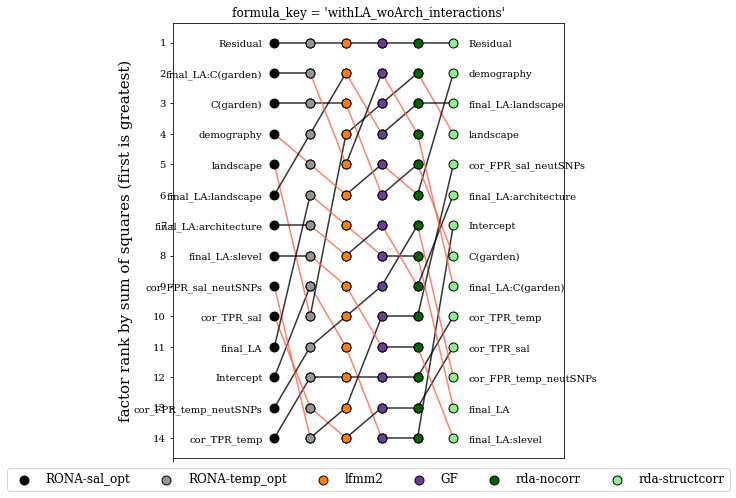




woLA_withArch


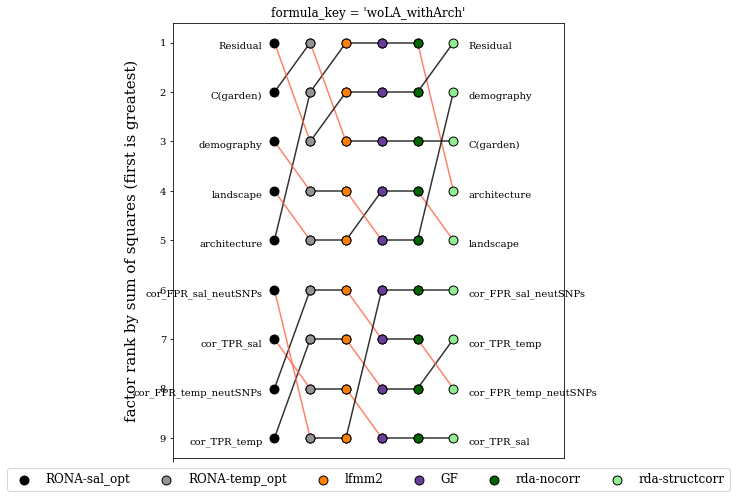




woLA_withArch_interactions


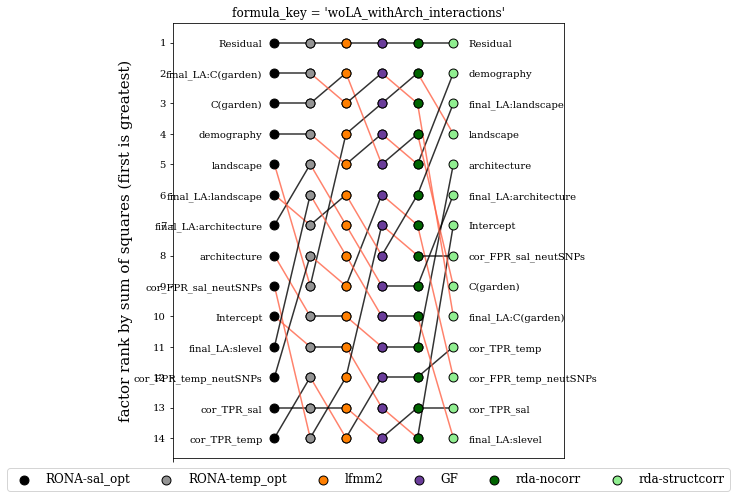

In [39]:
for formula_key in keys(sos):
    print(ColorText(formula_key).bold())
    show_slope_graph(formula_key)
    print('\n\n')

<a id='figs'></a>
# 5. make figs

[top](#home)

In [40]:
def cleanup_fig(g, loc='center left', bbox_to_anchor=None, color_by=None, fontsize=9,
                replace=None, ncol=1):
    """Make the fig look rull pretty."""
    
    g.figure.set_size_inches((8, 4))
    
    adjust_box_widths(list(g.axes[0]), 0.85)
    
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels,
          xlabel=None)
    
    g.ax.set_ylabel("Performance (Kendall's $\\tau$)", fontsize=12)

    mvp.jitter_fliers(g)
    
    g.tight_layout()
    
    # line at tau = 0
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

    mvp.add_legend(g.figure, color_by=color_by, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize,
                   ncol=ncol)

    mvp.update_ticklabels(g.axes.flat[0], replace=replace, fontsize=fontsize+1)
    
    pass
        

<a id='landscape'></a>
### performance by landscape by program

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/landscape_by_method_performance.pdf


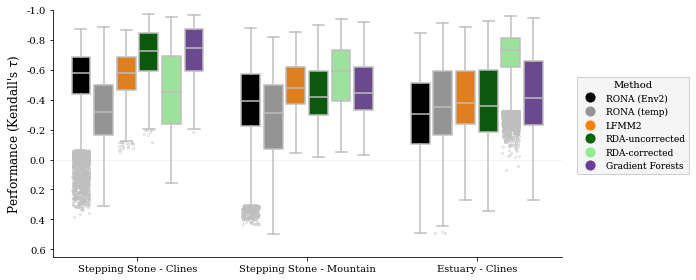

In [41]:
g = sns.catplot(data=bcs_garden_data,
                x='landscape',
                y='score',
                order=['SS-Clines', 'SS-Mtn', 'Est-Clines'],
                hue='program',
                hue_order=mvp.hue_order['program'],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, bbox_to_anchor=(1, 0.55), color_by='program')

save_pdf(op.join(figdir, 'landscape_by_method_performance.pdf'))

plt.show()

<a id='proland'></a>
### performance of program by landscape

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/method_by_landscape_performance.pdf


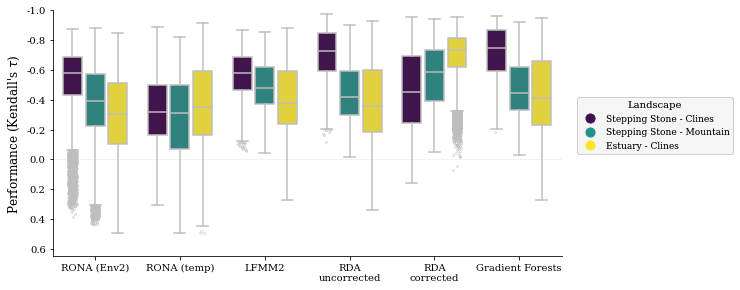

In [42]:
g = sns.catplot(data=bcs_garden_data,
                x='program',
                y='score',
                order=['RONA-sal_opt', 'RONA-temp_opt', 'lfmm2', 'rda-nocorr', 'rda-structcorr', 'GF'],
                hue='landscape',
                hue_order=['SS-Clines', 'SS-Mtn', 'Est-Clines'],
                kind='box',
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, bbox_to_anchor=(1, 0.55), color_by='landscape', replace=('-', '\n'))

save_pdf(op.join(figdir, 'method_by_landscape_performance.pdf'))

plt.show()

<a id='genic'></a>
### performance by program  by genic level

In [43]:
g = sns.catplot(data=bcs_garden_data,
                x='program',
                y='score',
                hue='glevel',
                hue_order=['oligogenic', 'mod-polygenic', 'highly-polygenic'],
                kind='box',
                order=mvp.hue_order['program'],
                legend=False,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, color_by='glevel', bbox_to_anchor=(1, 0.55), replace=('-', '\n'))

save_pdf(op.join(figdir, 'method_by_glevel_performance.pdf'))

plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/method_by_glevel_performance.pdf


<a id='demo'></a>
### performance by program by demography

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/method_by_demography_performance.pdf


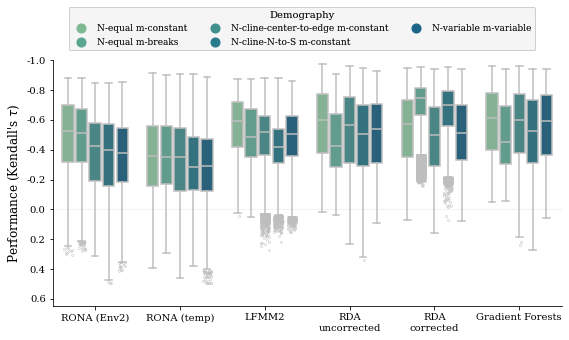

In [44]:
g = sns.catplot(data=bcs_garden_data,
                x='program',
                y='score',
                hue='demography',
                hue_order=mvp.hue_order['demography'],
                kind='box',
                order=mvp.hue_order['program'],
                legend=False,
                **mvp.boxplot_kwargs
               )

# cleanup_fig(g, xlabel='Program', color_by='demography', bbox_to_anchor=(1, 0.55), replace=('-', '\n'))
cleanup_fig(g, color_by='demography', loc='upper center',
            bbox_to_anchor=(0.53, 1.15), replace=('-', '\n'), ncol=3)

save_pdf(op.join(figdir, 'method_by_demography_performance.pdf'))

plt.show()

# save objects

In [45]:
for basename in ['lms', 'res', 'sos']:
    pkl = op.join(summarydir, f'{basename}.pkl')
    
    pkldump(globals()[basename], pkl)
    
    print(pkl)

/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/lms.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/res.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/sos.pkl


In [46]:
formatclock(dt.now() - t1)

'0-00:09:48'